<a href="https://colab.research.google.com/github/sawesky/deep-stegano/blob/masterpsnr/Diplomski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2023-05-29 14:09:31--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  15.4MB/s    in 19s     

2023-05-29 14:09:50 (12.2 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [2]:
!unzip /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [3]:
!pip install Keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.utils as image #mora da se doda da prekrsi preprocessing image 
import keras.backend as K

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [5]:
### Constants ###
DATA_DIR = "./tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [6]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)


In [7]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [8]:
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

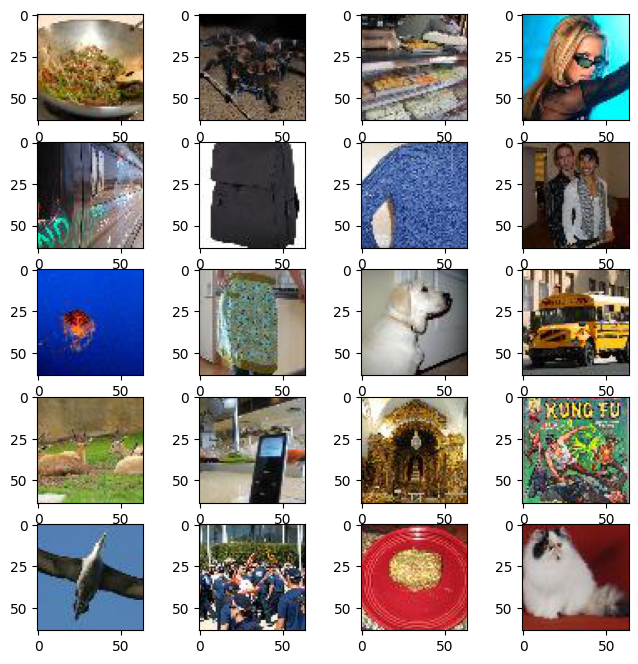

In [9]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [10]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    loss = beta * tf.reduce_sum(tf.square(s_true - s_pred)/(64*64))
    return loss

def psnr_loss(y_true, y_pred):
    n = tf.reduce_max(y_true)  # Max pixel value in y_true
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    psnr = 10 * tf.math.log(10.0) / tf.math.log(10.0) * tf.math.log(n**2 / mse)
    return 1 / psnr

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = beta * psnr_loss(s_true, s_pred)
    c_loss = psnr_loss(c_true, c_pred)
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C = Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x3)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x4)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x5)
    x = concatenate([x3, x4, x5])
  
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x3)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x4)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x5)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(reveal_input)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(reveal_input)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(reveal_input)
    
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x3)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x4)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x5)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(50, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(50, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder
 

In [11]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [12]:
NB_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
K.set_value(autoencoder_model.optimizer.lr,lr)
K.set_value(reveal_model.optimizer.lr,lr)
m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        aeloss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3))
        ae_loss.append(aeloss)

        revloss = reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S)
        rev_loss.append(revloss)
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


Epoch 1 | Batch:   0 of 1000. Loss AE       0.15 | Loss Rev      27.59:   3%|▎         | 1/32 [00:22<11:38, 22.54s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch:  32 of 1000. Loss AE      -0.04 | Loss Rev     216.15:   6%|▋         | 2/32 [00:22<04:41,  9.39s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch:  64 of 1000. Loss AE       0.01 | Loss Rev     150.68:   9%|▉         | 3/32 [00:22<02:30,  5.18s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch:  96 of 1000. Loss AE       0.05 | Loss Rev     120.25:  12%|█▎        | 4/32 [00:23<01:29,  3.20s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 128 of 1000. Loss AE       0.06 | Loss Rev     101.43:  16%|█▌        | 5/32 [00:23<00:56,  2.11s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 160 of 1000. Loss AE       0.08 | Loss Rev      88.59:  19%|█▉        | 6/32 [00:23<00:37,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 192 of 1000. Loss AE       0.08 | Loss Rev      79.19:  22%|██▏       | 7/32 [00:23<00:25,  1.03s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 224 of 1000. Loss AE       0.09 | Loss Rev      71.81:  25%|██▌       | 8/32 [00:23<00:18,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 256 of 1000. Loss AE       0.09 | Loss Rev      65.29:  28%|██▊       | 9/32 [00:23<00:13,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 288 of 1000. Loss AE       0.09 | Loss Rev      60.77:  31%|███▏      | 10/32 [00:24<00:09,  2.24it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 320 of 1000. Loss AE       0.09 | Loss Rev      56.11:  34%|███▍      | 11/32 [00:24<00:07,  2.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 352 of 1000. Loss AE       0.09 | Loss Rev      52.50:  38%|███▊      | 12/32 [00:24<00:06,  3.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch: 384 of 1000. Loss AE       0.09 | Loss Rev      49.40:  41%|████      | 13/32 [00:24<00:04,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 416 of 1000. Loss AE       0.09 | Loss Rev      46.66:  44%|████▍     | 14/32 [00:24<00:04,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 448 of 1000. Loss AE       0.08 | Loss Rev      44.19:  47%|████▋     | 15/32 [00:24<00:03,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 480 of 1000. Loss AE       0.08 | Loss Rev      42.33:  50%|█████     | 16/32 [00:25<00:03,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 512 of 1000. Loss AE       0.08 | Loss Rev      40.45:  53%|█████▎    | 17/32 [00:25<00:02,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 544 of 1000. Loss AE       0.08 | Loss Rev      38.65:  56%|█████▋    | 18/32 [00:25<00:02,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 576 of 1000. Loss AE       0.08 | Loss Rev      37.10:  59%|█████▉    | 19/32 [00:25<00:02,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 608 of 1000. Loss AE       0.08 | Loss Rev      35.65:  62%|██████▎   | 20/32 [00:25<00:02,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 640 of 1000. Loss AE       0.08 | Loss Rev      34.32:  66%|██████▌   | 21/32 [00:25<00:01,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 672 of 1000. Loss AE       0.08 | Loss Rev      33.05:  69%|██████▉   | 22/32 [00:26<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 704 of 1000. Loss AE       0.08 | Loss Rev      31.90:  72%|███████▏  | 23/32 [00:26<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 736 of 1000. Loss AE       0.08 | Loss Rev      30.82:  75%|███████▌  | 24/32 [00:26<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 768 of 1000. Loss AE       0.08 | Loss Rev      29.80:  78%|███████▊  | 25/32 [00:26<00:01,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 800 of 1000. Loss AE       0.08 | Loss Rev      28.90:  81%|████████▏ | 26/32 [00:26<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 832 of 1000. Loss AE       0.08 | Loss Rev      28.07:  84%|████████▍ | 27/32 [00:26<00:00,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 1 | Batch: 864 of 1000. Loss AE       0.08 | Loss Rev      27.37:  88%|████████▊ | 28/32 [00:27<00:00,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 896 of 1000. Loss AE       0.08 | Loss Rev      26.76:  91%|█████████ | 29/32 [00:27<00:00,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 928 of 1000. Loss AE       0.08 | Loss Rev      26.16:  94%|█████████▍| 30/32 [00:27<00:00,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 960 of 1000. Loss AE       0.08 | Loss Rev      25.48:  97%|█████████▋| 31/32 [00:27<00:00,  6.04it/s]

1/1 [==============================] - 0s 495ms/step


Epoch 1 | Batch: 992 of 1000. Loss AE       0.08 | Loss Rev      24.75: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch:   0 of 1000. Loss AE       0.06 | Loss Rev       5.84:   3%|▎         | 1/32 [00:00<00:05,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch:  32 of 1000. Loss AE       0.06 | Loss Rev       5.62:   6%|▋         | 2/32 [00:00<00:05,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch:  64 of 1000. Loss AE       0.07 | Loss Rev       5.59:   9%|▉         | 3/32 [00:00<00:04,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch:  96 of 1000. Loss AE       0.07 | Loss Rev       5.87:  12%|█▎        | 4/32 [00:00<00:04,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 128 of 1000. Loss AE       0.07 | Loss Rev       5.93:  16%|█▌        | 5/32 [00:00<00:04,  6.01it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 2 | Batch: 160 of 1000. Loss AE       0.07 | Loss Rev       5.86:  19%|█▉        | 6/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 2 | Batch: 192 of 1000. Loss AE       0.07 | Loss Rev       6.06:  22%|██▏       | 7/32 [00:01<00:04,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 224 of 1000. Loss AE       0.07 | Loss Rev       5.98:  25%|██▌       | 8/32 [00:01<00:04,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 256 of 1000. Loss AE       0.07 | Loss Rev       5.95:  28%|██▊       | 9/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 288 of 1000. Loss AE       0.06 | Loss Rev       5.76:  31%|███▏      | 10/32 [00:01<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 320 of 1000. Loss AE       0.06 | Loss Rev       5.63:  34%|███▍      | 11/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 352 of 1000. Loss AE       0.06 | Loss Rev       5.44:  38%|███▊      | 12/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 384 of 1000. Loss AE       0.06 | Loss Rev       5.35:  41%|████      | 13/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 416 of 1000. Loss AE       0.06 | Loss Rev       5.25:  44%|████▍     | 14/32 [00:02<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 448 of 1000. Loss AE       0.06 | Loss Rev       5.10:  47%|████▋     | 15/32 [00:02<00:02,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 480 of 1000. Loss AE       0.06 | Loss Rev       5.02:  50%|█████     | 16/32 [00:02<00:02,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 512 of 1000. Loss AE       0.06 | Loss Rev       4.89:  53%|█████▎    | 17/32 [00:02<00:02,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 544 of 1000. Loss AE       0.06 | Loss Rev       4.82:  56%|█████▋    | 18/32 [00:03<00:02,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 576 of 1000. Loss AE       0.06 | Loss Rev       4.72:  59%|█████▉    | 19/32 [00:03<00:02,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 608 of 1000. Loss AE       0.06 | Loss Rev       4.66:  62%|██████▎   | 20/32 [00:03<00:02,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 640 of 1000. Loss AE       0.06 | Loss Rev       4.65:  66%|██████▌   | 21/32 [00:03<00:01,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 672 of 1000. Loss AE       0.06 | Loss Rev       4.67:  69%|██████▉   | 22/32 [00:03<00:01,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 704 of 1000. Loss AE       0.06 | Loss Rev       4.59:  72%|███████▏  | 23/32 [00:03<00:01,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 736 of 1000. Loss AE       0.06 | Loss Rev       4.59:  75%|███████▌  | 24/32 [00:04<00:01,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 768 of 1000. Loss AE       0.06 | Loss Rev       4.56:  78%|███████▊  | 25/32 [00:04<00:01,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch: 800 of 1000. Loss AE       0.06 | Loss Rev       4.56:  81%|████████▏ | 26/32 [00:04<00:01,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 832 of 1000. Loss AE       0.06 | Loss Rev       4.51:  84%|████████▍ | 27/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 864 of 1000. Loss AE       0.06 | Loss Rev       4.50:  88%|████████▊ | 28/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 896 of 1000. Loss AE       0.06 | Loss Rev       4.43:  91%|█████████ | 29/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 928 of 1000. Loss AE       0.06 | Loss Rev       4.39:  94%|█████████▍| 30/32 [00:05<00:00,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 960 of 1000. Loss AE       0.06 | Loss Rev       4.34:  97%|█████████▋| 31/32 [00:05<00:00,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 992 of 1000. Loss AE       0.06 | Loss Rev       4.23: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch:   0 of 1000. Loss AE       0.05 | Loss Rev       2.92:   3%|▎         | 1/32 [00:00<00:05,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch:  32 of 1000. Loss AE       0.05 | Loss Rev       3.05:   6%|▋         | 2/32 [00:00<00:05,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch:  64 of 1000. Loss AE       0.05 | Loss Rev       3.20:   9%|▉         | 3/32 [00:00<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch:  96 of 1000. Loss AE       0.05 | Loss Rev       3.07:  12%|█▎        | 4/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 128 of 1000. Loss AE       0.05 | Loss Rev       3.11:  16%|█▌        | 5/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 160 of 1000. Loss AE       0.05 | Loss Rev       3.02:  19%|█▉        | 6/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 192 of 1000. Loss AE       0.05 | Loss Rev       3.03:  22%|██▏       | 7/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 224 of 1000. Loss AE       0.05 | Loss Rev       2.94:  25%|██▌       | 8/32 [00:01<00:04,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 256 of 1000. Loss AE       0.05 | Loss Rev       2.95:  28%|██▊       | 9/32 [00:01<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 288 of 1000. Loss AE       0.05 | Loss Rev       2.90:  31%|███▏      | 10/32 [00:01<00:03,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 320 of 1000. Loss AE       0.05 | Loss Rev       2.93:  34%|███▍      | 11/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 352 of 1000. Loss AE       0.05 | Loss Rev       2.87:  38%|███▊      | 12/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 384 of 1000. Loss AE       0.05 | Loss Rev       2.83:  41%|████      | 13/32 [00:02<00:03,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 416 of 1000. Loss AE       0.05 | Loss Rev       2.84:  44%|████▍     | 14/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 448 of 1000. Loss AE       0.05 | Loss Rev       2.82:  47%|████▋     | 15/32 [00:02<00:02,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 480 of 1000. Loss AE       0.05 | Loss Rev       2.79:  50%|█████     | 16/32 [00:02<00:02,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 512 of 1000. Loss AE       0.05 | Loss Rev       2.77:  53%|█████▎    | 17/32 [00:02<00:02,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 544 of 1000. Loss AE       0.05 | Loss Rev       2.77:  56%|█████▋    | 18/32 [00:03<00:02,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 576 of 1000. Loss AE       0.05 | Loss Rev       2.74:  59%|█████▉    | 19/32 [00:03<00:02,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 608 of 1000. Loss AE       0.05 | Loss Rev       2.74:  62%|██████▎   | 20/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 640 of 1000. Loss AE       0.05 | Loss Rev       2.72:  66%|██████▌   | 21/32 [00:03<00:01,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 672 of 1000. Loss AE       0.05 | Loss Rev       2.69:  69%|██████▉   | 22/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3 | Batch: 704 of 1000. Loss AE       0.05 | Loss Rev       2.68:  72%|███████▏  | 23/32 [00:03<00:01,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 736 of 1000. Loss AE       0.05 | Loss Rev       2.67:  75%|███████▌  | 24/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 768 of 1000. Loss AE       0.05 | Loss Rev       2.66:  78%|███████▊  | 25/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 800 of 1000. Loss AE       0.05 | Loss Rev       2.67:  81%|████████▏ | 26/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3 | Batch: 832 of 1000. Loss AE       0.05 | Loss Rev       2.67:  84%|████████▍ | 27/32 [00:04<00:00,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 864 of 1000. Loss AE       0.05 | Loss Rev       2.65:  88%|████████▊ | 28/32 [00:04<00:00,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 896 of 1000. Loss AE       0.05 | Loss Rev       2.67:  91%|█████████ | 29/32 [00:04<00:00,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 928 of 1000. Loss AE       0.05 | Loss Rev       2.65:  94%|█████████▍| 30/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 960 of 1000. Loss AE       0.05 | Loss Rev       2.67:  97%|█████████▋| 31/32 [00:05<00:00,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 992 of 1000. Loss AE       0.05 | Loss Rev       2.61: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch:   0 of 1000. Loss AE       0.05 | Loss Rev       2.16:   3%|▎         | 1/32 [00:00<00:05,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch:  32 of 1000. Loss AE       0.05 | Loss Rev       2.20:   6%|▋         | 2/32 [00:00<00:04,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch:  64 of 1000. Loss AE       0.05 | Loss Rev       2.25:   9%|▉         | 3/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch:  96 of 1000. Loss AE       0.05 | Loss Rev       2.47:  12%|█▎        | 4/32 [00:00<00:04,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 128 of 1000. Loss AE       0.05 | Loss Rev       2.54:  16%|█▌        | 5/32 [00:00<00:04,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 160 of 1000. Loss AE       0.05 | Loss Rev       2.59:  19%|█▉        | 6/32 [00:01<00:04,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 192 of 1000. Loss AE       0.05 | Loss Rev       2.55:  22%|██▏       | 7/32 [00:01<00:04,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 224 of 1000. Loss AE       0.05 | Loss Rev       2.45:  25%|██▌       | 8/32 [00:01<00:04,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 256 of 1000. Loss AE       0.05 | Loss Rev       2.43:  28%|██▊       | 9/32 [00:01<00:03,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 288 of 1000. Loss AE       0.05 | Loss Rev       2.36:  31%|███▏      | 10/32 [00:01<00:03,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 320 of 1000. Loss AE       0.05 | Loss Rev       2.45:  34%|███▍      | 11/32 [00:01<00:03,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 352 of 1000. Loss AE       0.05 | Loss Rev       2.44:  38%|███▊      | 12/32 [00:02<00:03,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 384 of 1000. Loss AE       0.05 | Loss Rev       2.47:  41%|████      | 13/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 416 of 1000. Loss AE       0.05 | Loss Rev       2.46:  44%|████▍     | 14/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 448 of 1000. Loss AE       0.05 | Loss Rev       2.46:  47%|████▋     | 15/32 [00:02<00:02,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 480 of 1000. Loss AE       0.05 | Loss Rev       2.45:  50%|█████     | 16/32 [00:02<00:02,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 512 of 1000. Loss AE       0.05 | Loss Rev       2.46:  53%|█████▎    | 17/32 [00:02<00:02,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 4 | Batch: 544 of 1000. Loss AE       0.05 | Loss Rev       2.47:  56%|█████▋    | 18/32 [00:03<00:02,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 576 of 1000. Loss AE       0.05 | Loss Rev       2.46:  59%|█████▉    | 19/32 [00:03<00:02,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 608 of 1000. Loss AE       0.05 | Loss Rev       2.45:  62%|██████▎   | 20/32 [00:03<00:01,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 640 of 1000. Loss AE       0.05 | Loss Rev       2.44:  66%|██████▌   | 21/32 [00:03<00:01,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 672 of 1000. Loss AE       0.05 | Loss Rev       2.45:  69%|██████▉   | 22/32 [00:03<00:01,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 704 of 1000. Loss AE       0.05 | Loss Rev       2.43:  72%|███████▏  | 23/32 [00:03<00:01,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 736 of 1000. Loss AE       0.05 | Loss Rev       2.43:  75%|███████▌  | 24/32 [00:04<00:01,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 768 of 1000. Loss AE       0.05 | Loss Rev       2.41:  78%|███████▊  | 25/32 [00:04<00:01,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 800 of 1000. Loss AE       0.05 | Loss Rev       2.39:  81%|████████▏ | 26/32 [00:04<00:00,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 832 of 1000. Loss AE       0.05 | Loss Rev       2.39:  84%|████████▍ | 27/32 [00:04<00:00,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 864 of 1000. Loss AE       0.05 | Loss Rev       2.38:  88%|████████▊ | 28/32 [00:04<00:00,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 896 of 1000. Loss AE       0.05 | Loss Rev       2.37:  91%|█████████ | 29/32 [00:04<00:00,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 928 of 1000. Loss AE       0.05 | Loss Rev       2.36:  94%|█████████▍| 30/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 960 of 1000. Loss AE       0.05 | Loss Rev       2.35:  97%|█████████▋| 31/32 [00:05<00:00,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 992 of 1000. Loss AE       0.05 | Loss Rev       2.29: 100%|██████████| 32/32 [00:05<00:00,  6.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch:   0 of 1000. Loss AE       0.05 | Loss Rev       1.94:   3%|▎         | 1/32 [00:00<00:05,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch:  32 of 1000. Loss AE       0.05 | Loss Rev       1.89:   6%|▋         | 2/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch:  64 of 1000. Loss AE       0.05 | Loss Rev       1.88:   9%|▉         | 3/32 [00:00<00:04,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch:  96 of 1000. Loss AE       0.05 | Loss Rev       1.91:  12%|█▎        | 4/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 128 of 1000. Loss AE       0.05 | Loss Rev       1.94:  16%|█▌        | 5/32 [00:00<00:04,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 160 of 1000. Loss AE       0.05 | Loss Rev       1.92:  19%|█▉        | 6/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 192 of 1000. Loss AE       0.05 | Loss Rev       1.92:  22%|██▏       | 7/32 [00:01<00:04,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 224 of 1000. Loss AE       0.05 | Loss Rev       1.89:  25%|██▌       | 8/32 [00:01<00:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 256 of 1000. Loss AE       0.05 | Loss Rev       1.91:  28%|██▊       | 9/32 [00:01<00:03,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 288 of 1000. Loss AE       0.05 | Loss Rev       1.93:  31%|███▏      | 10/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 320 of 1000. Loss AE       0.05 | Loss Rev       1.96:  34%|███▍      | 11/32 [00:01<00:03,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 352 of 1000. Loss AE       0.05 | Loss Rev       1.95:  38%|███▊      | 12/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 384 of 1000. Loss AE       0.05 | Loss Rev       1.93:  41%|████      | 13/32 [00:02<00:03,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 416 of 1000. Loss AE       0.05 | Loss Rev       1.93:  44%|████▍     | 14/32 [00:02<00:03,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 448 of 1000. Loss AE       0.05 | Loss Rev       1.96:  47%|████▋     | 15/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 480 of 1000. Loss AE       0.05 | Loss Rev       1.95:  50%|█████     | 16/32 [00:02<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 512 of 1000. Loss AE       0.05 | Loss Rev       1.97:  53%|█████▎    | 17/32 [00:02<00:02,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 544 of 1000. Loss AE       0.05 | Loss Rev       1.97:  56%|█████▋    | 18/32 [00:03<00:02,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 576 of 1000. Loss AE       0.05 | Loss Rev       1.97:  59%|█████▉    | 19/32 [00:03<00:02,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 608 of 1000. Loss AE       0.05 | Loss Rev       1.98:  62%|██████▎   | 20/32 [00:03<00:02,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 640 of 1000. Loss AE       0.05 | Loss Rev       2.07:  66%|██████▌   | 21/32 [00:03<00:01,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 672 of 1000. Loss AE       0.05 | Loss Rev       2.07:  69%|██████▉   | 22/32 [00:03<00:01,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 704 of 1000. Loss AE       0.05 | Loss Rev       2.06:  72%|███████▏  | 23/32 [00:03<00:01,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 736 of 1000. Loss AE       0.05 | Loss Rev       2.05:  75%|███████▌  | 24/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 768 of 1000. Loss AE       0.05 | Loss Rev       2.05:  78%|███████▊  | 25/32 [00:04<00:01,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 800 of 1000. Loss AE       0.05 | Loss Rev       2.09:  81%|████████▏ | 26/32 [00:04<00:01,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 832 of 1000. Loss AE       0.05 | Loss Rev       2.08:  84%|████████▍ | 27/32 [00:04<00:00,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 864 of 1000. Loss AE       0.05 | Loss Rev       2.08:  88%|████████▊ | 28/32 [00:04<00:00,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 896 of 1000. Loss AE       0.05 | Loss Rev       2.09:  91%|█████████ | 29/32 [00:04<00:00,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 928 of 1000. Loss AE       0.05 | Loss Rev       2.08:  94%|█████████▍| 30/32 [00:05<00:00,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 960 of 1000. Loss AE       0.05 | Loss Rev       2.07:  97%|█████████▋| 31/32 [00:05<00:00,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 992 of 1000. Loss AE       0.05 | Loss Rev       2.02: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch:   0 of 1000. Loss AE       0.05 | Loss Rev       2.20:   3%|▎         | 1/32 [00:00<00:05,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch:  32 of 1000. Loss AE       0.05 | Loss Rev       2.00:   6%|▋         | 2/32 [00:00<00:05,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.90:   9%|▉         | 3/32 [00:00<00:04,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.90:  12%|█▎        | 4/32 [00:00<00:04,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 128 of 1000. Loss AE       0.05 | Loss Rev       1.94:  16%|█▌        | 5/32 [00:00<00:04,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.85:  19%|█▉        | 6/32 [00:01<00:04,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.80:  22%|██▏       | 7/32 [00:01<00:04,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.86:  25%|██▌       | 8/32 [00:01<00:04,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.91:  28%|██▊       | 9/32 [00:01<00:03,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.89:  31%|███▏      | 10/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.86:  34%|███▍      | 11/32 [00:01<00:03,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.84:  38%|███▊      | 12/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.84:  41%|████      | 13/32 [00:02<00:03,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.84:  44%|████▍     | 14/32 [00:02<00:02,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.81:  47%|████▋     | 15/32 [00:02<00:02,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.81:  50%|█████     | 16/32 [00:02<00:02,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.87:  53%|█████▎    | 17/32 [00:02<00:02,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.90:  56%|█████▋    | 18/32 [00:03<00:02,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.94:  59%|█████▉    | 19/32 [00:03<00:02,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.95:  62%|██████▎   | 20/32 [00:03<00:01,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.97:  66%|██████▌   | 21/32 [00:03<00:01,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.97:  69%|██████▉   | 22/32 [00:03<00:01,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.97:  72%|███████▏  | 23/32 [00:03<00:01,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.96:  75%|███████▌  | 24/32 [00:04<00:01,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.96:  78%|███████▊  | 25/32 [00:04<00:01,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.96:  81%|████████▏ | 26/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.99:  84%|████████▍ | 27/32 [00:04<00:00,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       2.00:  88%|████████▊ | 28/32 [00:04<00:00,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.98:  91%|█████████ | 29/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       2.00:  94%|█████████▍| 30/32 [00:05<00:00,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 960 of 1000. Loss AE       0.05 | Loss Rev       2.10:  97%|█████████▋| 31/32 [00:05<00:00,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 992 of 1000. Loss AE       0.05 | Loss Rev       2.05: 100%|██████████| 32/32 [00:05<00:00,  6.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch:   0 of 1000. Loss AE       0.05 | Loss Rev       2.05:   3%|▎         | 1/32 [00:00<00:05,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch:  32 of 1000. Loss AE       0.05 | Loss Rev       2.33:   6%|▋         | 2/32 [00:00<00:05,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch:  64 of 1000. Loss AE       0.05 | Loss Rev       2.73:   9%|▉         | 3/32 [00:00<00:04,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch:  96 of 1000. Loss AE       0.05 | Loss Rev       2.66:  12%|█▎        | 4/32 [00:00<00:04,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 128 of 1000. Loss AE       0.05 | Loss Rev       2.74:  16%|█▌        | 5/32 [00:00<00:04,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 160 of 1000. Loss AE       0.05 | Loss Rev       2.53:  19%|█▉        | 6/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 192 of 1000. Loss AE       0.05 | Loss Rev       2.49:  22%|██▏       | 7/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 224 of 1000. Loss AE       0.05 | Loss Rev       2.38:  25%|██▌       | 8/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 256 of 1000. Loss AE       0.05 | Loss Rev       2.32:  28%|██▊       | 9/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 288 of 1000. Loss AE       0.05 | Loss Rev       2.28:  31%|███▏      | 10/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 320 of 1000. Loss AE       0.05 | Loss Rev       2.27:  34%|███▍      | 11/32 [00:01<00:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 352 of 1000. Loss AE       0.05 | Loss Rev       2.21:  38%|███▊      | 12/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 384 of 1000. Loss AE       0.05 | Loss Rev       2.15:  41%|████      | 13/32 [00:02<00:03,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 416 of 1000. Loss AE       0.05 | Loss Rev       2.14:  44%|████▍     | 14/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 448 of 1000. Loss AE       0.05 | Loss Rev       2.12:  47%|████▋     | 15/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 480 of 1000. Loss AE       0.05 | Loss Rev       2.08:  50%|█████     | 16/32 [00:02<00:02,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 512 of 1000. Loss AE       0.05 | Loss Rev       2.09:  53%|█████▎    | 17/32 [00:02<00:02,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 544 of 1000. Loss AE       0.05 | Loss Rev       2.06:  56%|█████▋    | 18/32 [00:03<00:02,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 576 of 1000. Loss AE       0.05 | Loss Rev       2.06:  59%|█████▉    | 19/32 [00:03<00:02,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 608 of 1000. Loss AE       0.05 | Loss Rev       2.05:  62%|██████▎   | 20/32 [00:03<00:02,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 640 of 1000. Loss AE       0.05 | Loss Rev       2.02:  66%|██████▌   | 21/32 [00:03<00:01,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 672 of 1000. Loss AE       0.05 | Loss Rev       2.02:  69%|██████▉   | 22/32 [00:03<00:01,  5.96it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 704 of 1000. Loss AE       0.05 | Loss Rev       2.02:  72%|███████▏  | 23/32 [00:03<00:01,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 736 of 1000. Loss AE       0.05 | Loss Rev       2.01:  75%|███████▌  | 24/32 [00:04<00:01,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 768 of 1000. Loss AE       0.05 | Loss Rev       2.02:  78%|███████▊  | 25/32 [00:04<00:01,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 800 of 1000. Loss AE       0.05 | Loss Rev       2.03:  81%|████████▏ | 26/32 [00:04<00:00,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       2.01:  84%|████████▍ | 27/32 [00:04<00:00,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       2.03:  88%|████████▊ | 28/32 [00:04<00:00,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       2.02:  91%|█████████ | 29/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       2.03:  94%|█████████▍| 30/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 960 of 1000. Loss AE       0.05 | Loss Rev       2.06:  97%|█████████▋| 31/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 992 of 1000. Loss AE       0.05 | Loss Rev       2.01: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch:   0 of 1000. Loss AE       0.05 | Loss Rev       3.31:   3%|▎         | 1/32 [00:00<00:05,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch:  32 of 1000. Loss AE       0.05 | Loss Rev       2.67:   6%|▋         | 2/32 [00:00<00:04,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8 | Batch:  64 of 1000. Loss AE       0.05 | Loss Rev       2.88:   9%|▉         | 3/32 [00:00<00:04,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch:  96 of 1000. Loss AE       0.05 | Loss Rev       2.67:  12%|█▎        | 4/32 [00:00<00:04,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 128 of 1000. Loss AE       0.05 | Loss Rev       2.67:  16%|█▌        | 5/32 [00:00<00:04,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 160 of 1000. Loss AE       0.05 | Loss Rev       2.49:  19%|█▉        | 6/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 192 of 1000. Loss AE       0.05 | Loss Rev       2.51:  22%|██▏       | 7/32 [00:01<00:04,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 224 of 1000. Loss AE       0.05 | Loss Rev       2.42:  25%|██▌       | 8/32 [00:01<00:04,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 256 of 1000. Loss AE       0.05 | Loss Rev       2.38:  28%|██▊       | 9/32 [00:01<00:03,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 288 of 1000. Loss AE       0.05 | Loss Rev       2.30:  31%|███▏      | 10/32 [00:01<00:03,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 320 of 1000. Loss AE       0.05 | Loss Rev       2.26:  34%|███▍      | 11/32 [00:01<00:03,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 352 of 1000. Loss AE       0.05 | Loss Rev       2.20:  38%|███▊      | 12/32 [00:02<00:03,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 384 of 1000. Loss AE       0.05 | Loss Rev       2.15:  41%|████      | 13/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       2.12:  44%|████▍     | 14/32 [00:02<00:03,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       2.07:  47%|████▋     | 15/32 [00:02<00:02,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       2.04:  50%|█████     | 16/32 [00:02<00:02,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       2.02:  53%|█████▎    | 17/32 [00:02<00:02,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       2.00:  56%|█████▋    | 18/32 [00:03<00:02,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.97:  59%|█████▉    | 19/32 [00:03<00:02,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.96:  62%|██████▎   | 20/32 [00:03<00:01,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.95:  66%|██████▌   | 21/32 [00:03<00:01,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.93:  69%|██████▉   | 22/32 [00:03<00:01,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.93:  72%|███████▏  | 23/32 [00:03<00:01,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.90:  75%|███████▌  | 24/32 [00:04<00:01,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.88:  78%|███████▊  | 25/32 [00:04<00:01,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.87:  81%|████████▏ | 26/32 [00:04<00:01,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.87:  84%|████████▍ | 27/32 [00:04<00:00,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.87:  88%|████████▊ | 28/32 [00:04<00:00,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.85:  91%|█████████ | 29/32 [00:04<00:00,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.84:  94%|█████████▍| 30/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.83:  97%|█████████▋| 31/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.78: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.98:   3%|▎         | 1/32 [00:00<00:05,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.98:   6%|▋         | 2/32 [00:00<00:05,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.94:   9%|▉         | 3/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.89:  12%|█▎        | 4/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.80:  16%|█▌        | 5/32 [00:00<00:04,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.76:  19%|█▉        | 6/32 [00:00<00:04,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.70:  22%|██▏       | 7/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.69:  25%|██▌       | 8/32 [00:01<00:04,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.70:  28%|██▊       | 9/32 [00:01<00:03,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.72:  31%|███▏      | 10/32 [00:01<00:03,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.82:  34%|███▍      | 11/32 [00:01<00:03,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.95:  38%|███▊      | 12/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.97:  41%|████      | 13/32 [00:02<00:03,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       2.11:  44%|████▍     | 14/32 [00:02<00:03,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       2.21:  47%|████▋     | 15/32 [00:02<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       2.23:  50%|█████     | 16/32 [00:02<00:02,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       2.33:  53%|█████▎    | 17/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       2.28:  56%|█████▋    | 18/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       2.32:  59%|█████▉    | 19/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       2.27:  62%|██████▎   | 20/32 [00:03<00:02,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       2.28:  66%|██████▌   | 21/32 [00:03<00:01,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       2.24:  69%|██████▉   | 22/32 [00:03<00:01,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       2.24:  72%|███████▏  | 23/32 [00:03<00:01,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       2.21:  75%|███████▌  | 24/32 [00:04<00:01,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       2.19:  78%|███████▊  | 25/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       2.15:  81%|████████▏ | 26/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       2.13:  84%|████████▍ | 27/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       2.13:  88%|████████▊ | 28/32 [00:04<00:00,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       2.11:  91%|█████████ | 29/32 [00:04<00:00,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       2.08:  94%|█████████▍| 30/32 [00:05<00:00,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       2.07:  97%|█████████▋| 31/32 [00:05<00:00,  6.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 9 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       2.02: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.72:   3%|▎         | 1/32 [00:00<00:05,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.42:   6%|▋         | 2/32 [00:00<00:05,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.40:   9%|▉         | 3/32 [00:00<00:04,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.47:  12%|█▎        | 4/32 [00:00<00:04,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.47:  16%|█▌        | 5/32 [00:00<00:04,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.48:  19%|█▉        | 6/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.48:  22%|██▏       | 7/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.46:  25%|██▌       | 8/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 10 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.49:  28%|██▊       | 9/32 [00:01<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.47:  31%|███▏      | 10/32 [00:01<00:03,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.49:  34%|███▍      | 11/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.53:  38%|███▊      | 12/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.52:  41%|████      | 13/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.53:  44%|████▍     | 14/32 [00:02<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.52:  47%|████▋     | 15/32 [00:02<00:02,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.51:  50%|█████     | 16/32 [00:02<00:02,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.50:  53%|█████▎    | 17/32 [00:02<00:02,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.50:  56%|█████▋    | 18/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.51:  59%|█████▉    | 19/32 [00:03<00:02,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.51:  62%|██████▎   | 20/32 [00:03<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.51:  66%|██████▌   | 21/32 [00:03<00:01,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.51:  69%|██████▉   | 22/32 [00:03<00:01,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.53:  72%|███████▏  | 23/32 [00:03<00:01,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.55:  75%|███████▌  | 24/32 [00:04<00:01,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.54:  78%|███████▊  | 25/32 [00:04<00:01,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.54:  81%|████████▏ | 26/32 [00:04<00:01,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.53:  84%|████████▍ | 27/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.53:  88%|████████▊ | 28/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.53:  91%|█████████ | 29/32 [00:04<00:00,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.54:  94%|█████████▍| 30/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.56:  97%|█████████▋| 31/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.52: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.99:   3%|▎         | 1/32 [00:00<00:05,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch:  32 of 1000. Loss AE       0.05 | Loss Rev       2.70:   6%|▋         | 2/32 [00:00<00:05,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       2.33:   9%|▉         | 3/32 [00:00<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       2.61:  12%|█▎        | 4/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 128 of 1000. Loss AE       0.05 | Loss Rev       2.71:  16%|█▌        | 5/32 [00:00<00:04,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 160 of 1000. Loss AE       0.05 | Loss Rev       2.64:  19%|█▉        | 6/32 [00:01<00:04,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 192 of 1000. Loss AE       0.05 | Loss Rev       2.86:  22%|██▏       | 7/32 [00:01<00:04,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 224 of 1000. Loss AE       0.05 | Loss Rev       2.68:  25%|██▌       | 8/32 [00:01<00:03,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 256 of 1000. Loss AE       0.05 | Loss Rev       2.67:  28%|██▊       | 9/32 [00:01<00:03,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       2.55:  31%|███▏      | 10/32 [00:01<00:03,  6.01it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       2.48:  34%|███▍      | 11/32 [00:01<00:03,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       2.48:  38%|███▊      | 12/32 [00:02<00:03,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       2.41:  41%|████      | 13/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       2.37:  44%|████▍     | 14/32 [00:02<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       2.30:  47%|████▋     | 15/32 [00:02<00:02,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       2.29:  50%|█████     | 16/32 [00:02<00:02,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       2.24:  53%|█████▎    | 17/32 [00:02<00:02,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       2.24:  56%|█████▋    | 18/32 [00:03<00:02,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       2.18:  59%|█████▉    | 19/32 [00:03<00:02,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 11 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       2.17:  62%|██████▎   | 20/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       2.13:  66%|██████▌   | 21/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       2.12:  69%|██████▉   | 22/32 [00:03<00:01,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       2.10:  72%|███████▏  | 23/32 [00:03<00:01,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       2.09:  75%|███████▌  | 24/32 [00:04<00:01,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       2.06:  78%|███████▊  | 25/32 [00:04<00:01,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       2.05:  81%|████████▏ | 26/32 [00:04<00:01,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       2.02:  84%|████████▍ | 27/32 [00:04<00:00,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       2.00:  88%|████████▊ | 28/32 [00:04<00:00,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.99:  91%|█████████ | 29/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.96:  94%|█████████▍| 30/32 [00:05<00:00,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.95:  97%|█████████▋| 31/32 [00:05<00:00,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 11 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.91: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.58:   3%|▎         | 1/32 [00:00<00:05,  6.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.62:   6%|▋         | 2/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.56:   9%|▉         | 3/32 [00:00<00:04,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.66:  12%|█▎        | 4/32 [00:00<00:04,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.59:  16%|█▌        | 5/32 [00:00<00:04,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.61:  19%|█▉        | 6/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.58:  22%|██▏       | 7/32 [00:01<00:04,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.55:  25%|██▌       | 8/32 [00:01<00:03,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.54:  28%|██▊       | 9/32 [00:01<00:03,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.54:  31%|███▏      | 10/32 [00:01<00:03,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 12 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.58:  34%|███▍      | 11/32 [00:01<00:03,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.61:  38%|███▊      | 12/32 [00:01<00:03,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.60:  41%|████      | 13/32 [00:02<00:03,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.62:  44%|████▍     | 14/32 [00:02<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.61:  47%|████▋     | 15/32 [00:02<00:02,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.61:  50%|█████     | 16/32 [00:02<00:02,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.61:  53%|█████▎    | 17/32 [00:02<00:02,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.60:  56%|█████▋    | 18/32 [00:03<00:02,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.59:  59%|█████▉    | 19/32 [00:03<00:02,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.60:  62%|██████▎   | 20/32 [00:03<00:02,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.58:  66%|██████▌   | 21/32 [00:03<00:01,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.58:  69%|██████▉   | 22/32 [00:03<00:01,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.57:  72%|███████▏  | 23/32 [00:03<00:01,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.57:  75%|███████▌  | 24/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.56:  78%|███████▊  | 25/32 [00:04<00:01,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.56:  81%|████████▏ | 26/32 [00:04<00:01,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.55:  84%|████████▍ | 27/32 [00:04<00:00,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.54:  88%|████████▊ | 28/32 [00:04<00:00,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.53:  91%|█████████ | 29/32 [00:04<00:00,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.53:  94%|█████████▍| 30/32 [00:05<00:00,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.51:  97%|█████████▋| 31/32 [00:05<00:00,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.47: 100%|██████████| 32/32 [00:05<00:00,  6.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.69:   3%|▎         | 1/32 [00:00<00:05,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.47:   6%|▋         | 2/32 [00:00<00:05,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.39:   9%|▉         | 3/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.37:  12%|█▎        | 4/32 [00:00<00:04,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.39:  16%|█▌        | 5/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.44:  19%|█▉        | 6/32 [00:00<00:04,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.59:  22%|██▏       | 7/32 [00:01<00:04,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.59:  25%|██▌       | 8/32 [00:01<00:04,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.57:  28%|██▊       | 9/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.61:  31%|███▏      | 10/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.60:  34%|███▍      | 11/32 [00:01<00:03,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.59:  38%|███▊      | 12/32 [00:02<00:03,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.59:  41%|████      | 13/32 [00:02<00:03,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.59:  44%|████▍     | 14/32 [00:02<00:03,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.56:  47%|████▋     | 15/32 [00:02<00:02,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.59:  50%|█████     | 16/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.62:  53%|█████▎    | 17/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 13 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.59:  56%|█████▋    | 18/32 [00:03<00:02,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.58:  59%|█████▉    | 19/32 [00:03<00:02,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.58:  62%|██████▎   | 20/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.59:  66%|██████▌   | 21/32 [00:03<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.57:  69%|██████▉   | 22/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.58:  72%|███████▏  | 23/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.57:  75%|███████▌  | 24/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.58:  78%|███████▊  | 25/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 13 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.57:  81%|████████▏ | 26/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.56:  84%|████████▍ | 27/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 13 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.55:  88%|████████▊ | 28/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.55:  91%|█████████ | 29/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.55:  94%|█████████▍| 30/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.53:  97%|█████████▋| 31/32 [00:05<00:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.50: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.09:   3%|▎         | 1/32 [00:00<00:05,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.35:   6%|▋         | 2/32 [00:00<00:05,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.39:   9%|▉         | 3/32 [00:00<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.37:  12%|█▎        | 4/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.35:  16%|█▌        | 5/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.32:  19%|█▉        | 6/32 [00:01<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.32:  22%|██▏       | 7/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.29:  25%|██▌       | 8/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.33:  28%|██▊       | 9/32 [00:01<00:03,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.31:  31%|███▏      | 10/32 [00:01<00:03,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.35:  34%|███▍      | 11/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.33:  38%|███▊      | 12/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.34:  41%|████      | 13/32 [00:02<00:03,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.33:  44%|████▍     | 14/32 [00:02<00:03,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.31:  47%|████▋     | 15/32 [00:02<00:02,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.32:  50%|█████     | 16/32 [00:02<00:02,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.34:  53%|█████▎    | 17/32 [00:02<00:02,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.39:  56%|█████▋    | 18/32 [00:03<00:02,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.49:  59%|█████▉    | 19/32 [00:03<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.49:  62%|██████▎   | 20/32 [00:03<00:02,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.58:  66%|██████▌   | 21/32 [00:03<00:01,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.68:  69%|██████▉   | 22/32 [00:03<00:01,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.72:  72%|███████▏  | 23/32 [00:03<00:01,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.87:  75%|███████▌  | 24/32 [00:04<00:01,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.85:  78%|███████▊  | 25/32 [00:04<00:01,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 14 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.88:  81%|████████▏ | 26/32 [00:04<00:00,  6.03it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.86:  84%|████████▍ | 27/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.85:  88%|████████▊ | 28/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.83:  91%|█████████ | 29/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.83:  94%|█████████▍| 30/32 [00:05<00:00,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.82:  97%|█████████▋| 31/32 [00:05<00:00,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.78: 100%|██████████| 32/32 [00:05<00:00,  6.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.23:   3%|▎         | 1/32 [00:00<00:05,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.37:   6%|▋         | 2/32 [00:00<00:04,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.40:   9%|▉         | 3/32 [00:00<00:04,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.38:  12%|█▎        | 4/32 [00:00<00:04,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.42:  16%|█▌        | 5/32 [00:00<00:04,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.38:  19%|█▉        | 6/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.38:  22%|██▏       | 7/32 [00:01<00:04,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.34:  25%|██▌       | 8/32 [00:01<00:03,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.33:  28%|██▊       | 9/32 [00:01<00:03,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.30:  31%|███▏      | 10/32 [00:01<00:03,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.32:  34%|███▍      | 11/32 [00:01<00:03,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.31:  38%|███▊      | 12/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.32:  41%|████      | 13/32 [00:02<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.32:  44%|████▍     | 14/32 [00:02<00:03,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 15 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.32:  47%|████▋     | 15/32 [00:02<00:02,  6.01it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.35:  50%|█████     | 16/32 [00:02<00:02,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.37:  53%|█████▎    | 17/32 [00:02<00:02,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.38:  56%|█████▋    | 18/32 [00:02<00:02,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.35:  59%|█████▉    | 19/32 [00:03<00:02,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.35:  62%|██████▎   | 20/32 [00:03<00:02,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.37:  66%|██████▌   | 21/32 [00:03<00:01,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.37:  69%|██████▉   | 22/32 [00:03<00:01,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.36:  72%|███████▏  | 23/32 [00:03<00:01,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.35:  75%|███████▌  | 24/32 [00:03<00:01,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.36:  78%|███████▊  | 25/32 [00:04<00:01,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.35:  81%|████████▏ | 26/32 [00:04<00:00,  6.03it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.35:  84%|████████▍ | 27/32 [00:04<00:00,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.36:  88%|████████▊ | 28/32 [00:04<00:00,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.35:  91%|█████████ | 29/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.36:  94%|█████████▍| 30/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.35:  97%|█████████▋| 31/32 [00:05<00:00,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.32: 100%|██████████| 32/32 [00:05<00:00,  6.05it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.04:   3%|▎         | 1/32 [00:00<00:05,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.38:   6%|▋         | 2/32 [00:00<00:05,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.38:   9%|▉         | 3/32 [00:00<00:04,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.41:  12%|█▎        | 4/32 [00:00<00:04,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.52:  16%|█▌        | 5/32 [00:00<00:04,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.49:  19%|█▉        | 6/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.49:  22%|██▏       | 7/32 [00:01<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.46:  25%|██▌       | 8/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.48:  28%|██▊       | 9/32 [00:01<00:03,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.45:  31%|███▏      | 10/32 [00:01<00:03,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.44:  34%|███▍      | 11/32 [00:01<00:03,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.44:  38%|███▊      | 12/32 [00:02<00:03,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.42:  41%|████      | 13/32 [00:02<00:03,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.41:  44%|████▍     | 14/32 [00:02<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.41:  47%|████▋     | 15/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.41:  50%|█████     | 16/32 [00:02<00:02,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.48:  53%|█████▎    | 17/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.48:  56%|█████▋    | 18/32 [00:03<00:02,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.49:  59%|█████▉    | 19/32 [00:03<00:02,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 16 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.50:  62%|██████▎   | 20/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.53:  66%|██████▌   | 21/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.52:  69%|██████▉   | 22/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.52:  72%|███████▏  | 23/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.52:  75%|███████▌  | 24/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.51:  78%|███████▊  | 25/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.51:  81%|████████▏ | 26/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.50:  84%|████████▍ | 27/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.51:  88%|████████▊ | 28/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.50:  91%|█████████ | 29/32 [00:04<00:00,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.49:  94%|█████████▍| 30/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.48:  97%|█████████▋| 31/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.44: 100%|██████████| 32/32 [00:05<00:00,  5.98it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.18:   3%|▎         | 1/32 [00:00<00:05,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.23:   6%|▋         | 2/32 [00:00<00:05,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.25:   9%|▉         | 3/32 [00:00<00:04,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.29:  12%|█▎        | 4/32 [00:00<00:04,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.23:  16%|█▌        | 5/32 [00:00<00:04,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.19:  19%|█▉        | 6/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.21:  22%|██▏       | 7/32 [00:01<00:04,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.24:  25%|██▌       | 8/32 [00:01<00:04,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.23:  28%|██▊       | 9/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.23:  31%|███▏      | 10/32 [00:01<00:03,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.21:  34%|███▍      | 11/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.21:  38%|███▊      | 12/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.20:  41%|████      | 13/32 [00:02<00:03,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.19:  44%|████▍     | 14/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.19:  47%|████▋     | 15/32 [00:02<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.20:  50%|█████     | 16/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.20:  53%|█████▎    | 17/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.19:  56%|█████▋    | 18/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.21:  59%|█████▉    | 19/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.20:  62%|██████▎   | 20/32 [00:03<00:02,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.20:  66%|██████▌   | 21/32 [00:03<00:01,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.19:  69%|██████▉   | 22/32 [00:03<00:01,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.21:  72%|███████▏  | 23/32 [00:03<00:01,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.21:  75%|███████▌  | 24/32 [00:04<00:01,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.23:  78%|███████▊  | 25/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.22:  81%|████████▏ | 26/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.23:  84%|████████▍ | 27/32 [00:04<00:00,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.24:  88%|████████▊ | 28/32 [00:04<00:00,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.27:  91%|█████████ | 29/32 [00:04<00:00,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.31:  94%|█████████▍| 30/32 [00:05<00:00,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.30:  97%|█████████▋| 31/32 [00:05<00:00,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.27: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.85:   3%|▎         | 1/32 [00:00<00:05,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.67:   6%|▋         | 2/32 [00:00<00:05,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.50:   9%|▉         | 3/32 [00:00<00:04,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.41:  12%|█▎        | 4/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.51:  16%|█▌        | 5/32 [00:00<00:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.61:  19%|█▉        | 6/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.57:  22%|██▏       | 7/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.71:  25%|██▌       | 8/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.77:  28%|██▊       | 9/32 [00:01<00:03,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.79:  31%|███▏      | 10/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.94:  34%|███▍      | 11/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.86:  38%|███▊      | 12/32 [00:02<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.86:  41%|████      | 13/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.80:  44%|████▍     | 14/32 [00:02<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.82:  47%|████▋     | 15/32 [00:02<00:02,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.78:  50%|█████     | 16/32 [00:02<00:02,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.78:  53%|█████▎    | 17/32 [00:02<00:02,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.77:  56%|█████▋    | 18/32 [00:03<00:02,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.75:  59%|█████▉    | 19/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.73:  62%|██████▎   | 20/32 [00:03<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.72:  66%|██████▌   | 21/32 [00:03<00:01,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.69:  69%|██████▉   | 22/32 [00:03<00:01,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.68:  72%|███████▏  | 23/32 [00:03<00:01,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.66:  75%|███████▌  | 24/32 [00:04<00:01,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.64:  78%|███████▊  | 25/32 [00:04<00:01,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.62:  81%|████████▏ | 26/32 [00:04<00:01,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.60:  84%|████████▍ | 27/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.59:  88%|████████▊ | 28/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.59:  91%|█████████ | 29/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.57:  94%|█████████▍| 30/32 [00:05<00:00,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.55:  97%|█████████▋| 31/32 [00:05<00:00,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.51: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.00:   3%|▎         | 1/32 [00:00<00:05,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.96:   6%|▋         | 2/32 [00:00<00:05,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.01:   9%|▉         | 3/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.06:  12%|█▎        | 4/32 [00:00<00:04,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.00:  16%|█▌        | 5/32 [00:00<00:04,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.04:  19%|█▉        | 6/32 [00:01<00:04,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.07:  22%|██▏       | 7/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.09:  25%|██▌       | 8/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.11:  28%|██▊       | 9/32 [00:01<00:03,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.13:  31%|███▏      | 10/32 [00:01<00:03,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.16:  34%|███▍      | 11/32 [00:01<00:03,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.15:  38%|███▊      | 12/32 [00:02<00:03,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.17:  41%|████      | 13/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.15:  44%|████▍     | 14/32 [00:02<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.15:  47%|████▋     | 15/32 [00:02<00:02,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.14:  50%|█████     | 16/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.14:  53%|█████▎    | 17/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.14:  56%|█████▋    | 18/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.16:  59%|█████▉    | 19/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.16:  62%|██████▎   | 20/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.15:  66%|██████▌   | 21/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.15:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.15:  72%|███████▏  | 23/32 [00:03<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.15:  75%|███████▌  | 24/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 19 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.17:  78%|███████▊  | 25/32 [00:04<00:01,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.17:  81%|████████▏ | 26/32 [00:04<00:01,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 19 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.17:  84%|████████▍ | 27/32 [00:04<00:00,  5.97it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.17:  88%|████████▊ | 28/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.18:  91%|█████████ | 29/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.18:  94%|█████████▍| 30/32 [00:05<00:00,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.17:  97%|█████████▋| 31/32 [00:05<00:00,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.13: 100%|██████████| 32/32 [00:05<00:00,  5.96it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.92:   3%|▎         | 1/32 [00:00<00:05,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 20 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.17:   6%|▋         | 2/32 [00:00<00:05,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 20 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.23:   9%|▉         | 3/32 [00:00<00:04,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.28:  12%|█▎        | 4/32 [00:00<00:04,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.32:  16%|█▌        | 5/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 20 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.27:  19%|█▉        | 6/32 [00:01<00:06,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.29:  22%|██▏       | 7/32 [00:01<00:05,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.28:  25%|██▌       | 8/32 [00:01<00:05,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.24:  28%|██▊       | 9/32 [00:01<00:04,  4.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.25:  31%|███▏      | 10/32 [00:01<00:04,  5.10it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.29:  34%|███▍      | 11/32 [00:02<00:04,  5.21it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.26:  38%|███▊      | 12/32 [00:02<00:03,  5.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.24:  41%|████      | 13/32 [00:02<00:03,  5.43it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.24:  44%|████▍     | 14/32 [00:02<00:03,  5.42it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.22:  47%|████▋     | 15/32 [00:02<00:03,  5.49it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.23:  50%|█████     | 16/32 [00:03<00:02,  5.53it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.24:  53%|█████▎    | 17/32 [00:03<00:02,  5.58it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.26:  56%|█████▋    | 18/32 [00:03<00:02,  5.61it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.26:  59%|█████▉    | 19/32 [00:03<00:02,  5.63it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.24:  62%|██████▎   | 20/32 [00:03<00:02,  5.63it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.22:  66%|██████▌   | 21/32 [00:03<00:01,  5.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.23:  69%|██████▉   | 22/32 [00:04<00:01,  5.58it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.28:  72%|███████▏  | 23/32 [00:04<00:01,  5.61it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.30:  75%|███████▌  | 24/32 [00:04<00:01,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 20 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.29:  78%|███████▊  | 25/32 [00:04<00:01,  5.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.28:  81%|████████▏ | 26/32 [00:04<00:01,  5.66it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.32:  84%|████████▍ | 27/32 [00:05<00:00,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 20 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.32:  88%|████████▊ | 28/32 [00:05<00:00,  5.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.31:  91%|█████████ | 29/32 [00:05<00:00,  5.68it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 20 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.35:  94%|█████████▍| 30/32 [00:05<00:00,  5.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 20 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.34:  97%|█████████▋| 31/32 [00:05<00:00,  5.58it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.31: 100%|██████████| 32/32 [00:05<00:00,  5.47it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 21 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.25:   3%|▎         | 1/32 [00:00<00:05,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 21 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.01:   6%|▋         | 2/32 [00:00<00:05,  5.70it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 21 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.05:   9%|▉         | 3/32 [00:00<00:05,  5.70it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 21 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.04:  12%|█▎        | 4/32 [00:00<00:04,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 21 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.04:  16%|█▌        | 5/32 [00:00<00:04,  5.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 21 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.04:  19%|█▉        | 6/32 [00:01<00:04,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 21 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.05:  22%|██▏       | 7/32 [00:01<00:04,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 21 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.06:  25%|██▌       | 8/32 [00:01<00:04,  5.68it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 21 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.05:  28%|██▊       | 9/32 [00:01<00:04,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 21 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.08:  31%|███▏      | 10/32 [00:01<00:03,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 21 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.10:  34%|███▍      | 11/32 [00:01<00:03,  5.72it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 21 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.10:  38%|███▊      | 12/32 [00:02<00:03,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 21 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.11:  41%|████      | 13/32 [00:02<00:03,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.08:  44%|████▍     | 14/32 [00:02<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.09:  47%|████▋     | 15/32 [00:02<00:02,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 21 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.11:  50%|█████     | 16/32 [00:02<00:02,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 21 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.12:  53%|█████▎    | 17/32 [00:02<00:02,  5.71it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 21 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.11:  56%|█████▋    | 18/32 [00:03<00:02,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.11:  59%|█████▉    | 19/32 [00:03<00:02,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.11:  62%|██████▎   | 20/32 [00:03<00:02,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.10:  66%|██████▌   | 21/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.10:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.11:  72%|███████▏  | 23/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 21 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.10:  75%|███████▌  | 24/32 [00:04<00:01,  5.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 21 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.09:  78%|███████▊  | 25/32 [00:04<00:01,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.11:  81%|████████▏ | 26/32 [00:04<00:01,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.11:  84%|████████▍ | 27/32 [00:04<00:00,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.11:  88%|████████▊ | 28/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.11:  91%|█████████ | 29/32 [00:05<00:00,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.12:  94%|█████████▍| 30/32 [00:05<00:00,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.11:  97%|█████████▋| 31/32 [00:05<00:00,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.09: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 22 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.05:   3%|▎         | 1/32 [00:00<00:05,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.96:   6%|▋         | 2/32 [00:00<00:05,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.99:   9%|▉         | 3/32 [00:00<00:05,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.15:  12%|█▎        | 4/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 22 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.27:  16%|█▌        | 5/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.29:  19%|█▉        | 6/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.28:  22%|██▏       | 7/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.31:  25%|██▌       | 8/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 22 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.32:  28%|██▊       | 9/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.30:  31%|███▏      | 10/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.34:  34%|███▍      | 11/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.34:  38%|███▊      | 12/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 22 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.31:  41%|████      | 13/32 [00:02<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 22 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.29:  44%|████▍     | 14/32 [00:02<00:03,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.29:  47%|████▋     | 15/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.28:  50%|█████     | 16/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.26:  53%|█████▎    | 17/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.26:  56%|█████▋    | 18/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.25:  59%|█████▉    | 19/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.23:  62%|██████▎   | 20/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.25:  66%|██████▌   | 21/32 [00:03<00:01,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.24:  69%|██████▉   | 22/32 [00:03<00:01,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 22 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.22:  72%|███████▏  | 23/32 [00:03<00:01,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 22 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.21:  75%|███████▌  | 24/32 [00:04<00:01,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 22 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.21:  78%|███████▊  | 25/32 [00:04<00:01,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 22 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.20:  81%|████████▏ | 26/32 [00:04<00:01,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 22 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.20:  84%|████████▍ | 27/32 [00:04<00:00,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.19:  88%|████████▊ | 28/32 [00:04<00:00,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 22 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.18:  91%|█████████ | 29/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.19:  94%|█████████▍| 30/32 [00:05<00:00,  5.94it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 22 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.20:  97%|█████████▋| 31/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.17: 100%|██████████| 32/32 [00:05<00:00,  5.96it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.89:   3%|▎         | 1/32 [00:00<00:05,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.98:   6%|▋         | 2/32 [00:00<00:05,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.02:   9%|▉         | 3/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.15:  12%|█▎        | 4/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.20:  16%|█▌        | 5/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.20:  19%|█▉        | 6/32 [00:01<00:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.21:  22%|██▏       | 7/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.24:  25%|██▌       | 8/32 [00:01<00:04,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.26:  28%|██▊       | 9/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.29:  31%|███▏      | 10/32 [00:01<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.31:  34%|███▍      | 11/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.29:  38%|███▊      | 12/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.28:  41%|████      | 13/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.30:  44%|████▍     | 14/32 [00:02<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.29:  47%|████▋     | 15/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 23 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.29:  50%|█████     | 16/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.28:  53%|█████▎    | 17/32 [00:02<00:02,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.26:  56%|█████▋    | 18/32 [00:03<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.25:  59%|█████▉    | 19/32 [00:03<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.25:  62%|██████▎   | 20/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.23:  66%|██████▌   | 21/32 [00:03<00:01,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.27:  69%|██████▉   | 22/32 [00:03<00:01,  5.90it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 23 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.26:  72%|███████▏  | 23/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.25:  75%|███████▌  | 24/32 [00:04<00:01,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.24:  78%|███████▊  | 25/32 [00:04<00:01,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.22:  81%|████████▏ | 26/32 [00:04<00:01,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.20:  84%|████████▍ | 27/32 [00:04<00:00,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.19:  88%|████████▊ | 28/32 [00:04<00:00,  5.99it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 23 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.19:  91%|█████████ | 29/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.20:  94%|█████████▍| 30/32 [00:05<00:00,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.19:  97%|█████████▋| 31/32 [00:05<00:00,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 23 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.16: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.95:   3%|▎         | 1/32 [00:00<00:05,  6.04it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.01:   6%|▋         | 2/32 [00:00<00:04,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 24 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.00:   9%|▉         | 3/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.07:  12%|█▎        | 4/32 [00:00<00:04,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.10:  16%|█▌        | 5/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.10:  19%|█▉        | 6/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.10:  22%|██▏       | 7/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.08:  25%|██▌       | 8/32 [00:01<00:04,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.05:  28%|██▊       | 9/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.06:  31%|███▏      | 10/32 [00:01<00:03,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.07:  34%|███▍      | 11/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.08:  38%|███▊      | 12/32 [00:02<00:03,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.07:  41%|████      | 13/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.11:  44%|████▍     | 14/32 [00:02<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.13:  47%|████▋     | 15/32 [00:02<00:02,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.11:  50%|█████     | 16/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.13:  53%|█████▎    | 17/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.17:  56%|█████▋    | 18/32 [00:03<00:02,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.15:  59%|█████▉    | 19/32 [00:03<00:02,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 24 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.16:  62%|██████▎   | 20/32 [00:03<00:02,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.17:  66%|██████▌   | 21/32 [00:03<00:01,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.17:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.17:  72%|███████▏  | 23/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.19:  75%|███████▌  | 24/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.20:  78%|███████▊  | 25/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.24:  81%|████████▏ | 26/32 [00:04<00:01,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.23:  84%|████████▍ | 27/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.24:  88%|████████▊ | 28/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 24 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.25:  91%|█████████ | 29/32 [00:04<00:00,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.24:  94%|█████████▍| 30/32 [00:05<00:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.24:  97%|█████████▋| 31/32 [00:05<00:00,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.21: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.43:   3%|▎         | 1/32 [00:00<00:05,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.37:   6%|▋         | 2/32 [00:00<00:04,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.33:   9%|▉         | 3/32 [00:00<00:04,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.46:  12%|█▎        | 4/32 [00:00<00:04,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.46:  16%|█▌        | 5/32 [00:00<00:04,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.41:  19%|█▉        | 6/32 [00:00<00:04,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.40:  22%|██▏       | 7/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.35:  25%|██▌       | 8/32 [00:01<00:04,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.32:  28%|██▊       | 9/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.30:  31%|███▏      | 10/32 [00:01<00:03,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.26:  34%|███▍      | 11/32 [00:01<00:03,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.22:  38%|███▊      | 12/32 [00:02<00:03,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.20:  41%|████      | 13/32 [00:02<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.17:  44%|████▍     | 14/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.17:  47%|████▋     | 15/32 [00:02<00:02,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.16:  50%|█████     | 16/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.17:  53%|█████▎    | 17/32 [00:02<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.15:  56%|█████▋    | 18/32 [00:03<00:02,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.14:  59%|█████▉    | 19/32 [00:03<00:02,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.14:  62%|██████▎   | 20/32 [00:03<00:02,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.13:  66%|██████▌   | 21/32 [00:03<00:01,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.16:  69%|██████▉   | 22/32 [00:03<00:01,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.18:  72%|███████▏  | 23/32 [00:03<00:01,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.17:  75%|███████▌  | 24/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.17:  78%|███████▊  | 25/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.17:  81%|████████▏ | 26/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.16:  84%|████████▍ | 27/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.15:  88%|████████▊ | 28/32 [00:04<00:00,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.17:  91%|█████████ | 29/32 [00:04<00:00,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 25 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.17:  94%|█████████▍| 30/32 [00:05<00:00,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.18:  97%|█████████▋| 31/32 [00:05<00:00,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.15: 100%|██████████| 32/32 [00:05<00:00,  6.02it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.19:   3%|▎         | 1/32 [00:00<00:05,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.27:   6%|▋         | 2/32 [00:00<00:05,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.24:   9%|▉         | 3/32 [00:00<00:04,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.47:  12%|█▎        | 4/32 [00:00<00:04,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.37:  16%|█▌        | 5/32 [00:00<00:04,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.33:  19%|█▉        | 6/32 [00:01<00:04,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.27:  22%|██▏       | 7/32 [00:01<00:04,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.25:  25%|██▌       | 8/32 [00:01<00:04,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.21:  28%|██▊       | 9/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.21:  31%|███▏      | 10/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.20:  34%|███▍      | 11/32 [00:01<00:03,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.25:  38%|███▊      | 12/32 [00:02<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.22:  41%|████      | 13/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.22:  44%|████▍     | 14/32 [00:02<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.21:  47%|████▋     | 15/32 [00:02<00:02,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.17:  50%|█████     | 16/32 [00:02<00:02,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.17:  53%|█████▎    | 17/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.18:  56%|█████▋    | 18/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.16:  59%|█████▉    | 19/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.16:  62%|██████▎   | 20/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.15:  66%|██████▌   | 21/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.15:  69%|██████▉   | 22/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.14:  72%|███████▏  | 23/32 [00:03<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.12:  75%|███████▌  | 24/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.11:  78%|███████▊  | 25/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.10:  81%|████████▏ | 26/32 [00:04<00:01,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.10:  84%|████████▍ | 27/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.09:  88%|████████▊ | 28/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.09:  91%|█████████ | 29/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.09:  94%|█████████▍| 30/32 [00:05<00:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.08:  97%|█████████▋| 31/32 [00:05<00:00,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 26 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.06: 100%|██████████| 32/32 [00:05<00:00,  5.98it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 27 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.74:   3%|▎         | 1/32 [00:00<00:05,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.85:   6%|▋         | 2/32 [00:00<00:05,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.87:   9%|▉         | 3/32 [00:00<00:04,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.88:  12%|█▎        | 4/32 [00:00<00:04,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.95:  16%|█▌        | 5/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.10:  19%|█▉        | 6/32 [00:01<00:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.11:  22%|██▏       | 7/32 [00:01<00:04,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.11:  25%|██▌       | 8/32 [00:01<00:04,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.09:  28%|██▊       | 9/32 [00:01<00:03,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.10:  31%|███▏      | 10/32 [00:01<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.13:  34%|███▍      | 11/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.13:  38%|███▊      | 12/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.11:  41%|████      | 13/32 [00:02<00:03,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.11:  44%|████▍     | 14/32 [00:02<00:03,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 27 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.15:  47%|████▋     | 15/32 [00:02<00:02,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.18:  50%|█████     | 16/32 [00:02<00:02,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.16:  53%|█████▎    | 17/32 [00:02<00:02,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.14:  56%|█████▋    | 18/32 [00:03<00:02,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.16:  59%|█████▉    | 19/32 [00:03<00:02,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.16:  62%|██████▎   | 20/32 [00:03<00:02,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.14:  66%|██████▌   | 21/32 [00:03<00:01,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.16:  69%|██████▉   | 22/32 [00:03<00:01,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.16:  72%|███████▏  | 23/32 [00:03<00:01,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.15:  75%|███████▌  | 24/32 [00:04<00:01,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.16:  78%|███████▊  | 25/32 [00:04<00:01,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.16:  81%|████████▏ | 26/32 [00:04<00:00,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.14:  84%|████████▍ | 27/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.13:  88%|████████▊ | 28/32 [00:04<00:00,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.13:  91%|█████████ | 29/32 [00:04<00:00,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.15:  94%|█████████▍| 30/32 [00:05<00:00,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.15:  97%|█████████▋| 31/32 [00:05<00:00,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 27 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.12: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 28 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.43:   3%|▎         | 1/32 [00:00<00:05,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.31:   6%|▋         | 2/32 [00:00<00:05,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.41:   9%|▉         | 3/32 [00:00<00:04,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.33:  12%|█▎        | 4/32 [00:00<00:04,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.29:  16%|█▌        | 5/32 [00:00<00:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.31:  19%|█▉        | 6/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.27:  22%|██▏       | 7/32 [00:01<00:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.23:  25%|██▌       | 8/32 [00:01<00:04,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.23:  28%|██▊       | 9/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.21:  31%|███▏      | 10/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.24:  34%|███▍      | 11/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.21:  38%|███▊      | 12/32 [00:02<00:03,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.18:  41%|████      | 13/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.15:  44%|████▍     | 14/32 [00:02<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.14:  47%|████▋     | 15/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.15:  50%|█████     | 16/32 [00:02<00:02,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.13:  53%|█████▎    | 17/32 [00:02<00:02,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.11:  56%|█████▋    | 18/32 [00:03<00:02,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.11:  59%|█████▉    | 19/32 [00:03<00:02,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.11:  62%|██████▎   | 20/32 [00:03<00:02,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.11:  66%|██████▌   | 21/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.10:  69%|██████▉   | 22/32 [00:03<00:01,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.10:  72%|███████▏  | 23/32 [00:03<00:01,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.08:  75%|███████▌  | 24/32 [00:04<00:01,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.07:  78%|███████▊  | 25/32 [00:04<00:01,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.07:  81%|████████▏ | 26/32 [00:04<00:01,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.07:  84%|████████▍ | 27/32 [00:04<00:00,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.06:  88%|████████▊ | 28/32 [00:04<00:00,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 28 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.06:  91%|█████████ | 29/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.05:  94%|█████████▍| 30/32 [00:05<00:00,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.05:  97%|█████████▋| 31/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.02: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.05:   3%|▎         | 1/32 [00:00<00:05,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.09:   6%|▋         | 2/32 [00:00<00:05,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.09:   9%|▉         | 3/32 [00:00<00:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.06:  12%|█▎        | 4/32 [00:00<00:04,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.14:  16%|█▌        | 5/32 [00:00<00:04,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.30:  19%|█▉        | 6/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.30:  22%|██▏       | 7/32 [00:01<00:04,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.36:  25%|██▌       | 8/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.41:  28%|██▊       | 9/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.35:  31%|███▏      | 10/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.43:  34%|███▍      | 11/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.42:  38%|███▊      | 12/32 [00:02<00:03,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.46:  41%|████      | 13/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.47:  44%|████▍     | 14/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.44:  47%|████▋     | 15/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.46:  50%|█████     | 16/32 [00:02<00:02,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.45:  53%|█████▎    | 17/32 [00:02<00:02,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 29 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.47:  56%|█████▋    | 18/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.45:  59%|█████▉    | 19/32 [00:03<00:02,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.48:  62%|██████▎   | 20/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.48:  66%|██████▌   | 21/32 [00:03<00:01,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.50:  69%|██████▉   | 22/32 [00:03<00:01,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.47:  72%|███████▏  | 23/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.49:  75%|███████▌  | 24/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.49:  78%|███████▊  | 25/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.50:  81%|████████▏ | 26/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.49:  84%|████████▍ | 27/32 [00:04<00:00,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 29 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.49:  88%|████████▊ | 28/32 [00:04<00:00,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.49:  91%|█████████ | 29/32 [00:04<00:00,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.49:  94%|█████████▍| 30/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.48:  97%|█████████▋| 31/32 [00:05<00:00,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.44: 100%|██████████| 32/32 [00:05<00:00,  5.96it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 30 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.47:   3%|▎         | 1/32 [00:00<00:05,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.24:   6%|▋         | 2/32 [00:00<00:05,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.17:   9%|▉         | 3/32 [00:00<00:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.24:  12%|█▎        | 4/32 [00:00<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.34:  16%|█▌        | 5/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.26:  19%|█▉        | 6/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.21:  22%|██▏       | 7/32 [00:01<00:04,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.18:  25%|██▌       | 8/32 [00:01<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.16:  28%|██▊       | 9/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.13:  31%|███▏      | 10/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.14:  34%|███▍      | 11/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.14:  38%|███▊      | 12/32 [00:02<00:03,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.14:  41%|████      | 13/32 [00:02<00:03,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.11:  44%|████▍     | 14/32 [00:02<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.12:  47%|████▋     | 15/32 [00:02<00:02,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 30 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.12:  50%|█████     | 16/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.11:  53%|█████▎    | 17/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.10:  56%|█████▋    | 18/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.08:  59%|█████▉    | 19/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.07:  62%|██████▎   | 20/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.05:  66%|██████▌   | 21/32 [00:03<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.04:  69%|██████▉   | 22/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.04:  72%|███████▏  | 23/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.03:  75%|███████▌  | 24/32 [00:04<00:01,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.04:  78%|███████▊  | 25/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.04:  81%|████████▏ | 26/32 [00:04<00:01,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.03:  84%|████████▍ | 27/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.03:  88%|████████▊ | 28/32 [00:04<00:00,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.03:  91%|█████████ | 29/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.03:  94%|█████████▍| 30/32 [00:05<00:00,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.02:  97%|█████████▋| 31/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.00: 100%|██████████| 32/32 [00:05<00:00,  5.98it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.09:   3%|▎         | 1/32 [00:00<00:05,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.01:   6%|▋         | 2/32 [00:00<00:05,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.16:   9%|▉         | 3/32 [00:00<00:05,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.04:  12%|█▎        | 4/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.07:  16%|█▌        | 5/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.04:  19%|█▉        | 6/32 [00:01<00:04,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.06:  22%|██▏       | 7/32 [00:01<00:04,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.04:  25%|██▌       | 8/32 [00:01<00:04,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.00:  28%|██▊       | 9/32 [00:01<00:03,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.98:  31%|███▏      | 10/32 [00:01<00:03,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.97:  34%|███▍      | 11/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.97:  38%|███▊      | 12/32 [00:02<00:03,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.98:  41%|████      | 13/32 [00:02<00:03,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.00:  44%|████▍     | 14/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.99:  47%|████▋     | 15/32 [00:02<00:02,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.01:  50%|█████     | 16/32 [00:02<00:02,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 31 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.99:  53%|█████▎    | 17/32 [00:02<00:02,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.99:  56%|█████▋    | 18/32 [00:03<00:02,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.00:  59%|█████▉    | 19/32 [00:03<00:02,  5.95it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.00:  62%|██████▎   | 20/32 [00:03<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.00:  66%|██████▌   | 21/32 [00:03<00:01,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.01:  69%|██████▉   | 22/32 [00:03<00:01,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 31 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.00:  72%|███████▏  | 23/32 [00:03<00:01,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.99:  75%|███████▌  | 24/32 [00:04<00:01,  6.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.98:  78%|███████▊  | 25/32 [00:04<00:01,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.98:  81%|████████▏ | 26/32 [00:04<00:01,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.98:  84%|████████▍ | 27/32 [00:04<00:00,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.97:  88%|████████▊ | 28/32 [00:04<00:00,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.98:  91%|█████████ | 29/32 [00:04<00:00,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.97:  94%|█████████▍| 30/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 31 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.97:  97%|█████████▋| 31/32 [00:05<00:00,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.95: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.17:   3%|▎         | 1/32 [00:00<00:05,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.40:   6%|▋         | 2/32 [00:00<00:05,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.36:   9%|▉         | 3/32 [00:00<00:04,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.23:  12%|█▎        | 4/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.12:  16%|█▌        | 5/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.07:  19%|█▉        | 6/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.08:  22%|██▏       | 7/32 [00:01<00:04,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.08:  25%|██▌       | 8/32 [00:01<00:04,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.08:  28%|██▊       | 9/32 [00:01<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.08:  31%|███▏      | 10/32 [00:01<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.05:  34%|███▍      | 11/32 [00:01<00:03,  5.98it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.08:  38%|███▊      | 12/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.04:  41%|████      | 13/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.04:  44%|████▍     | 14/32 [00:02<00:03,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.09:  47%|████▋     | 15/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.07:  50%|█████     | 16/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.13:  53%|█████▎    | 17/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.13:  56%|█████▋    | 18/32 [00:03<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.13:  59%|█████▉    | 19/32 [00:03<00:02,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.16:  62%|██████▎   | 20/32 [00:03<00:02,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.15:  66%|██████▌   | 21/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.15:  69%|██████▉   | 22/32 [00:03<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.14:  72%|███████▏  | 23/32 [00:03<00:01,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.14:  75%|███████▌  | 24/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.14:  78%|███████▊  | 25/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.13:  81%|████████▏ | 26/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.12:  84%|████████▍ | 27/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.13:  88%|████████▊ | 28/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 32 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.12:  91%|█████████ | 29/32 [00:04<00:00,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 32 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.11:  94%|█████████▍| 30/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.11:  97%|█████████▋| 31/32 [00:05<00:00,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.08: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.67:   3%|▎         | 1/32 [00:00<00:05,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.76:   6%|▋         | 2/32 [00:00<00:05,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.75:   9%|▉         | 3/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.75:  12%|█▎        | 4/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.79:  16%|█▌        | 5/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.81:  19%|█▉        | 6/32 [00:01<00:04,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.84:  22%|██▏       | 7/32 [00:01<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.81:  25%|██▌       | 8/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.83:  28%|██▊       | 9/32 [00:01<00:03,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.85:  31%|███▏      | 10/32 [00:01<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.85:  34%|███▍      | 11/32 [00:01<00:03,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.86:  38%|███▊      | 12/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.86:  41%|████      | 13/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.87:  44%|████▍     | 14/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.86:  47%|████▋     | 15/32 [00:02<00:02,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 33 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.85:  50%|█████     | 16/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.88:  53%|█████▎    | 17/32 [00:02<00:02,  5.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 33 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.88:  56%|█████▋    | 18/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.86:  59%|█████▉    | 19/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.87:  62%|██████▎   | 20/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.89:  66%|██████▌   | 21/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.88:  69%|██████▉   | 22/32 [00:03<00:01,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.90:  72%|███████▏  | 23/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.91:  75%|███████▌  | 24/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.91:  78%|███████▊  | 25/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 33 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.90:  81%|████████▏ | 26/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.93:  84%|████████▍ | 27/32 [00:04<00:00,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.94:  88%|████████▊ | 28/32 [00:04<00:00,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.94:  91%|█████████ | 29/32 [00:04<00:00,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 33 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.94:  94%|█████████▍| 30/32 [00:05<00:00,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.95:  97%|█████████▋| 31/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.93: 100%|██████████| 32/32 [00:05<00:00,  5.95it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.05:   3%|▎         | 1/32 [00:00<00:05,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 34 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.37:   6%|▋         | 2/32 [00:00<00:05,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.26:   9%|▉         | 3/32 [00:00<00:04,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.23:  12%|█▎        | 4/32 [00:00<00:04,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.32:  16%|█▌        | 5/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.27:  19%|█▉        | 6/32 [00:00<00:04,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 34 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.21:  22%|██▏       | 7/32 [00:01<00:04,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.22:  25%|██▌       | 8/32 [00:01<00:04,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.17:  28%|██▊       | 9/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.17:  31%|███▏      | 10/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.17:  34%|███▍      | 11/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.13:  38%|███▊      | 12/32 [00:02<00:03,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.14:  41%|████      | 13/32 [00:02<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.12:  44%|████▍     | 14/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.09:  47%|████▋     | 15/32 [00:02<00:02,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.10:  50%|█████     | 16/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.10:  53%|█████▎    | 17/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.07:  56%|█████▋    | 18/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.06:  59%|█████▉    | 19/32 [00:03<00:02,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.06:  62%|██████▎   | 20/32 [00:03<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.07:  66%|██████▌   | 21/32 [00:03<00:01,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.06:  69%|██████▉   | 22/32 [00:03<00:01,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.06:  72%|███████▏  | 23/32 [00:03<00:01,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.05:  75%|███████▌  | 24/32 [00:04<00:01,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.06:  78%|███████▊  | 25/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 34 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.07:  81%|████████▏ | 26/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.06:  84%|████████▍ | 27/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.07:  88%|████████▊ | 28/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.06:  91%|█████████ | 29/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 34 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.06:  94%|█████████▍| 30/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.07:  97%|█████████▋| 31/32 [00:05<00:00,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.05: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.28:   3%|▎         | 1/32 [00:00<00:05,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.32:   6%|▋         | 2/32 [00:00<00:05,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.16:   9%|▉         | 3/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.13:  12%|█▎        | 4/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.34:  16%|█▌        | 5/32 [00:00<00:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.29:  19%|█▉        | 6/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.35:  22%|██▏       | 7/32 [00:01<00:04,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.28:  25%|██▌       | 8/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.30:  28%|██▊       | 9/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.26:  31%|███▏      | 10/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.23:  34%|███▍      | 11/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.21:  38%|███▊      | 12/32 [00:02<00:03,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.18:  41%|████      | 13/32 [00:02<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.21:  44%|████▍     | 14/32 [00:02<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.18:  47%|████▋     | 15/32 [00:02<00:02,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.18:  50%|█████     | 16/32 [00:02<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.15:  53%|█████▎    | 17/32 [00:02<00:02,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.14:  56%|█████▋    | 18/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.12:  59%|█████▉    | 19/32 [00:03<00:02,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.14:  62%|██████▎   | 20/32 [00:03<00:02,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.12:  66%|██████▌   | 21/32 [00:03<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.13:  69%|██████▉   | 22/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.11:  72%|███████▏  | 23/32 [00:03<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.12:  75%|███████▌  | 24/32 [00:04<00:01,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.10:  78%|███████▊  | 25/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.09:  81%|████████▏ | 26/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.09:  84%|████████▍ | 27/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.08:  88%|████████▊ | 28/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.07:  91%|█████████ | 29/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 35 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.07:  94%|█████████▍| 30/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.06:  97%|█████████▋| 31/32 [00:05<00:00,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.04: 100%|██████████| 32/32 [00:05<00:00,  5.95it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.94:   3%|▎         | 1/32 [00:00<00:05,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.06:   6%|▋         | 2/32 [00:00<00:05,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.19:   9%|▉         | 3/32 [00:00<00:04,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.10:  12%|█▎        | 4/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.08:  16%|█▌        | 5/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.08:  19%|█▉        | 6/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.03:  22%|██▏       | 7/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.01:  25%|██▌       | 8/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.01:  28%|██▊       | 9/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.02:  31%|███▏      | 10/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.99:  34%|███▍      | 11/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.97:  38%|███▊      | 12/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.99:  41%|████      | 13/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.07:  44%|████▍     | 14/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.05:  47%|████▋     | 15/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.05:  50%|█████     | 16/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.08:  53%|█████▎    | 17/32 [00:02<00:02,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.07:  56%|█████▋    | 18/32 [00:03<00:02,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.07:  59%|█████▉    | 19/32 [00:03<00:02,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.08:  62%|██████▎   | 20/32 [00:03<00:02,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.06:  66%|██████▌   | 21/32 [00:03<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.05:  69%|██████▉   | 22/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.05:  72%|███████▏  | 23/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.05:  75%|███████▌  | 24/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.04:  78%|███████▊  | 25/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.04:  81%|████████▏ | 26/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.03:  84%|████████▍ | 27/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.02:  88%|████████▊ | 28/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.01:  91%|█████████ | 29/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.01:  94%|█████████▍| 30/32 [00:05<00:00,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.99:  97%|█████████▋| 31/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.97: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.71:   3%|▎         | 1/32 [00:00<00:05,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.76:   6%|▋         | 2/32 [00:00<00:05,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.85:   9%|▉         | 3/32 [00:00<00:04,  5.99it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.89:  12%|█▎        | 4/32 [00:00<00:04,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.92:  16%|█▌        | 5/32 [00:00<00:04,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.90:  19%|█▉        | 6/32 [00:01<00:04,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.88:  22%|██▏       | 7/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.86:  25%|██▌       | 8/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.87:  28%|██▊       | 9/32 [00:01<00:03,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 37 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.88:  31%|███▏      | 10/32 [00:01<00:03,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.87:  34%|███▍      | 11/32 [00:01<00:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.90:  38%|███▊      | 12/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.92:  41%|████      | 13/32 [00:02<00:03,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.92:  44%|████▍     | 14/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.91:  47%|████▋     | 15/32 [00:02<00:02,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.91:  50%|█████     | 16/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.91:  53%|█████▎    | 17/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.93:  56%|█████▋    | 18/32 [00:03<00:02,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.93:  59%|█████▉    | 19/32 [00:03<00:02,  5.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 37 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.92:  62%|██████▎   | 20/32 [00:03<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.93:  66%|██████▌   | 21/32 [00:03<00:01,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.92:  69%|██████▉   | 22/32 [00:03<00:01,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.92:  72%|███████▏  | 23/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.94:  75%|███████▌  | 24/32 [00:04<00:01,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.93:  78%|███████▊  | 25/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 37 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.95:  81%|████████▏ | 26/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.96:  84%|████████▍ | 27/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.97:  88%|████████▊ | 28/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 37 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.96:  91%|█████████ | 29/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 37 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.97:  94%|█████████▍| 30/32 [00:05<00:00,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.96:  97%|█████████▋| 31/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.94: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.05:   3%|▎         | 1/32 [00:00<00:05,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.90:   6%|▋         | 2/32 [00:00<00:05,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.94:   9%|▉         | 3/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.93:  12%|█▎        | 4/32 [00:00<00:04,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.93:  16%|█▌        | 5/32 [00:00<00:04,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 38 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.90:  19%|█▉        | 6/32 [00:01<00:04,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.91:  22%|██▏       | 7/32 [00:01<00:04,  6.00it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.89:  25%|██▌       | 8/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.92:  28%|██▊       | 9/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.92:  31%|███▏      | 10/32 [00:01<00:03,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 38 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.92:  34%|███▍      | 11/32 [00:01<00:03,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.90:  38%|███▊      | 12/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.89:  41%|████      | 13/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.91:  44%|████▍     | 14/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.91:  47%|████▋     | 15/32 [00:02<00:02,  6.00it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 38 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.92:  50%|█████     | 16/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.91:  53%|█████▎    | 17/32 [00:02<00:02,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.92:  56%|█████▋    | 18/32 [00:03<00:02,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.91:  59%|█████▉    | 19/32 [00:03<00:02,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.93:  62%|██████▎   | 20/32 [00:03<00:02,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.93:  66%|██████▌   | 21/32 [00:03<00:01,  5.97it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.93:  69%|██████▉   | 22/32 [00:03<00:01,  5.96it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 38 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.92:  72%|███████▏  | 23/32 [00:03<00:01,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.94:  75%|███████▌  | 24/32 [00:04<00:01,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.93:  78%|███████▊  | 25/32 [00:04<00:01,  5.89it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 38 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.93:  81%|████████▏ | 26/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.93:  84%|████████▍ | 27/32 [00:04<00:00,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.93:  88%|████████▊ | 28/32 [00:04<00:00,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.95:  91%|█████████ | 29/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.95:  94%|█████████▍| 30/32 [00:05<00:00,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.95:  97%|█████████▋| 31/32 [00:05<00:00,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.93: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 39 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.67:   3%|▎         | 1/32 [00:00<00:05,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.01:   6%|▋         | 2/32 [00:00<00:05,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 39 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.97:   9%|▉         | 3/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.02:  12%|█▎        | 4/32 [00:00<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.97:  16%|█▌        | 5/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.98:  19%|█▉        | 6/32 [00:01<00:04,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.94:  22%|██▏       | 7/32 [00:01<00:04,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.90:  25%|██▌       | 8/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.89:  28%|██▊       | 9/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.94:  31%|███▏      | 10/32 [00:01<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.95:  34%|███▍      | 11/32 [00:01<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.96:  38%|███▊      | 12/32 [00:02<00:03,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.95:  41%|████      | 13/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 39 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.95:  44%|████▍     | 14/32 [00:02<00:03,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.95:  47%|████▋     | 15/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.94:  50%|█████     | 16/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.93:  53%|█████▎    | 17/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 39 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.94:  56%|█████▋    | 18/32 [00:03<00:02,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.93:  59%|█████▉    | 19/32 [00:03<00:02,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.93:  62%|██████▎   | 20/32 [00:03<00:02,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.93:  66%|██████▌   | 21/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.94:  69%|██████▉   | 22/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.93:  72%|███████▏  | 23/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.93:  75%|███████▌  | 24/32 [00:04<00:01,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.92:  78%|███████▊  | 25/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 39 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.92:  81%|████████▏ | 26/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.90:  84%|████████▍ | 27/32 [00:04<00:00,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.90:  88%|████████▊ | 28/32 [00:04<00:00,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.89:  91%|█████████ | 29/32 [00:04<00:00,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 39 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.90:  94%|█████████▍| 30/32 [00:05<00:00,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.90:  97%|█████████▋| 31/32 [00:05<00:00,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.88: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.12:   3%|▎         | 1/32 [00:00<00:05,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.06:   6%|▋         | 2/32 [00:00<00:05,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.98:   9%|▉         | 3/32 [00:00<00:05,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.10:  12%|█▎        | 4/32 [00:00<00:04,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.20:  16%|█▌        | 5/32 [00:00<00:04,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.26:  19%|█▉        | 6/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.17:  22%|██▏       | 7/32 [00:01<00:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.15:  25%|██▌       | 8/32 [00:01<00:04,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.11:  28%|██▊       | 9/32 [00:01<00:03,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.07:  31%|███▏      | 10/32 [00:01<00:03,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.04:  34%|███▍      | 11/32 [00:01<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.08:  38%|███▊      | 12/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.06:  41%|████      | 13/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.10:  44%|████▍     | 14/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.06:  47%|████▋     | 15/32 [00:02<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.05:  50%|█████     | 16/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.05:  53%|█████▎    | 17/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.06:  56%|█████▋    | 18/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.06:  59%|█████▉    | 19/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.05:  62%|██████▎   | 20/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.03:  66%|██████▌   | 21/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.04:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.04:  72%|███████▏  | 23/32 [00:03<00:01,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 40 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.04:  75%|███████▌  | 24/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.04:  78%|███████▊  | 25/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.05:  81%|████████▏ | 26/32 [00:04<00:01,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 40 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.05:  84%|████████▍ | 27/32 [00:04<00:00,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.04:  88%|████████▊ | 28/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.03:  91%|█████████ | 29/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.04:  94%|█████████▍| 30/32 [00:05<00:00,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.03:  97%|█████████▋| 31/32 [00:05<00:00,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 40 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.01: 100%|██████████| 32/32 [00:05<00:00,  5.95it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.63:   3%|▎         | 1/32 [00:00<00:05,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.73:   6%|▋         | 2/32 [00:00<00:05,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.95:   9%|▉         | 3/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.90:  12%|█▎        | 4/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.90:  16%|█▌        | 5/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.91:  19%|█▉        | 6/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.88:  22%|██▏       | 7/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.91:  25%|██▌       | 8/32 [00:01<00:04,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 41 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.95:  28%|██▊       | 9/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.96:  31%|███▏      | 10/32 [00:01<00:03,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.94:  34%|███▍      | 11/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.92:  38%|███▊      | 12/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.90:  41%|████      | 13/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.90:  44%|████▍     | 14/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.90:  47%|████▋     | 15/32 [00:02<00:02,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.89:  50%|█████     | 16/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.89:  53%|█████▎    | 17/32 [00:02<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.89:  56%|█████▋    | 18/32 [00:03<00:02,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.90:  59%|█████▉    | 19/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.89:  62%|██████▎   | 20/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.89:  66%|██████▌   | 21/32 [00:03<00:01,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.89:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.88:  72%|███████▏  | 23/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.88:  75%|███████▌  | 24/32 [00:04<00:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.88:  78%|███████▊  | 25/32 [00:04<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.88:  81%|████████▏ | 26/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 41 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.87:  84%|████████▍ | 27/32 [00:04<00:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.87:  88%|████████▊ | 28/32 [00:04<00:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.91:  91%|█████████ | 29/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.91:  94%|█████████▍| 30/32 [00:05<00:00,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.91:  97%|█████████▋| 31/32 [00:05<00:00,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.89: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.09:   3%|▎         | 1/32 [00:00<00:05,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.14:   6%|▋         | 2/32 [00:00<00:05,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.93:   9%|▉         | 3/32 [00:00<00:04,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.97:  12%|█▎        | 4/32 [00:00<00:04,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.90:  16%|█▌        | 5/32 [00:00<00:04,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.90:  19%|█▉        | 6/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.94:  22%|██▏       | 7/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.90:  25%|██▌       | 8/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.89:  28%|██▊       | 9/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.93:  31%|███▏      | 10/32 [00:01<00:03,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.91:  34%|███▍      | 11/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.92:  38%|███▊      | 12/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.93:  41%|████      | 13/32 [00:02<00:03,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.94:  44%|████▍     | 14/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.92:  47%|████▋     | 15/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.93:  50%|█████     | 16/32 [00:02<00:02,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.95:  53%|█████▎    | 17/32 [00:02<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.95:  56%|█████▋    | 18/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.95:  59%|█████▉    | 19/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.95:  62%|██████▎   | 20/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.96:  66%|██████▌   | 21/32 [00:03<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.96:  69%|██████▉   | 22/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 42 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.94:  72%|███████▏  | 23/32 [00:03<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.96:  75%|███████▌  | 24/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.96:  78%|███████▊  | 25/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.95:  81%|████████▏ | 26/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.94:  84%|████████▍ | 27/32 [00:04<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.94:  88%|████████▊ | 28/32 [00:04<00:00,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.95:  91%|█████████ | 29/32 [00:04<00:00,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.95:  94%|█████████▍| 30/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.94:  97%|█████████▋| 31/32 [00:05<00:00,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.92: 100%|██████████| 32/32 [00:05<00:00,  5.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.96:   3%|▎         | 1/32 [00:00<00:05,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.97:   6%|▋         | 2/32 [00:00<00:05,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.14:   9%|▉         | 3/32 [00:00<00:05,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.09:  12%|█▎        | 4/32 [00:00<00:04,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.00:  16%|█▌        | 5/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.98:  19%|█▉        | 6/32 [00:01<00:04,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.13:  22%|██▏       | 7/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.11:  25%|██▌       | 8/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.12:  28%|██▊       | 9/32 [00:01<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.12:  31%|███▏      | 10/32 [00:01<00:03,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.11:  34%|███▍      | 11/32 [00:01<00:03,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.10:  38%|███▊      | 12/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.07:  41%|████      | 13/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.08:  44%|████▍     | 14/32 [00:02<00:03,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.05:  47%|████▋     | 15/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.06:  50%|█████     | 16/32 [00:02<00:02,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.06:  53%|█████▎    | 17/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.05:  56%|█████▋    | 18/32 [00:03<00:02,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.03:  59%|█████▉    | 19/32 [00:03<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.06:  62%|██████▎   | 20/32 [00:03<00:02,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.06:  66%|██████▌   | 21/32 [00:03<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.05:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.08:  72%|███████▏  | 23/32 [00:03<00:01,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.06:  75%|███████▌  | 24/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.11:  78%|███████▊  | 25/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.12:  81%|████████▏ | 26/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       1.13:  84%|████████▍ | 27/32 [00:04<00:00,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.16:  88%|████████▊ | 28/32 [00:04<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.15:  91%|█████████ | 29/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.16:  94%|█████████▍| 30/32 [00:05<00:00,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       1.16:  97%|█████████▋| 31/32 [00:05<00:00,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 43 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       1.13: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.15:   3%|▎         | 1/32 [00:00<00:05,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.22:   6%|▋         | 2/32 [00:00<00:05,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.12:   9%|▉         | 3/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.03:  12%|█▎        | 4/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.96:  16%|█▌        | 5/32 [00:00<00:04,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.01:  19%|█▉        | 6/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.03:  22%|██▏       | 7/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.00:  25%|██▌       | 8/32 [00:01<00:04,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.98:  28%|██▊       | 9/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.97:  31%|███▏      | 10/32 [00:01<00:03,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.94:  34%|███▍      | 11/32 [00:01<00:03,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.95:  38%|███▊      | 12/32 [00:02<00:03,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.92:  41%|████      | 13/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.92:  44%|████▍     | 14/32 [00:02<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.90:  47%|████▋     | 15/32 [00:02<00:02,  5.96it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.89:  50%|█████     | 16/32 [00:02<00:02,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.88:  53%|█████▎    | 17/32 [00:02<00:02,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.86:  56%|█████▋    | 18/32 [00:03<00:02,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.86:  59%|█████▉    | 19/32 [00:03<00:02,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.85:  62%|██████▎   | 20/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.84:  66%|██████▌   | 21/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.85:  69%|██████▉   | 22/32 [00:03<00:01,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.85:  72%|███████▏  | 23/32 [00:03<00:01,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 44 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.85:  75%|███████▌  | 24/32 [00:04<00:01,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.86:  78%|███████▊  | 25/32 [00:04<00:01,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.88:  81%|████████▏ | 26/32 [00:04<00:01,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 44 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.87:  84%|████████▍ | 27/32 [00:04<00:00,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.88:  88%|████████▊ | 28/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.88:  91%|█████████ | 29/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 44 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.87:  94%|█████████▍| 30/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.87:  97%|█████████▋| 31/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.85: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 45 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.80:   3%|▎         | 1/32 [00:00<00:05,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.95:   6%|▋         | 2/32 [00:00<00:05,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.85:   9%|▉         | 3/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.77:  12%|█▎        | 4/32 [00:00<00:04,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.80:  16%|█▌        | 5/32 [00:00<00:04,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.81:  19%|█▉        | 6/32 [00:01<00:04,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.81:  22%|██▏       | 7/32 [00:01<00:04,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.80:  25%|██▌       | 8/32 [00:01<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.87:  28%|██▊       | 9/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.87:  31%|███▏      | 10/32 [00:01<00:03,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.88:  34%|███▍      | 11/32 [00:01<00:03,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.87:  38%|███▊      | 12/32 [00:02<00:03,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.86:  41%|████      | 13/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.87:  44%|████▍     | 14/32 [00:02<00:03,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.88:  47%|████▋     | 15/32 [00:02<00:02,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.86:  50%|█████     | 16/32 [00:02<00:02,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.86:  53%|█████▎    | 17/32 [00:02<00:02,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.85:  56%|█████▋    | 18/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.85:  59%|█████▉    | 19/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.86:  62%|██████▎   | 20/32 [00:03<00:02,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.88:  66%|██████▌   | 21/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.89:  69%|██████▉   | 22/32 [00:03<00:01,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.89:  72%|███████▏  | 23/32 [00:03<00:01,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.89:  75%|███████▌  | 24/32 [00:04<00:01,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.90:  78%|███████▊  | 25/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.90:  81%|████████▏ | 26/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.90:  84%|████████▍ | 27/32 [00:04<00:00,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.92:  88%|████████▊ | 28/32 [00:04<00:00,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.92:  91%|█████████ | 29/32 [00:04<00:00,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 45 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.94:  94%|█████████▍| 30/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 45 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.93:  97%|█████████▋| 31/32 [00:05<00:00,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.90: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.87:   3%|▎         | 1/32 [00:00<00:05,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.85:   6%|▋         | 2/32 [00:00<00:05,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.82:   9%|▉         | 3/32 [00:00<00:05,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.83:  12%|█▎        | 4/32 [00:00<00:04,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 46 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.86:  16%|█▌        | 5/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.84:  19%|█▉        | 6/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.85:  22%|██▏       | 7/32 [00:01<00:04,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.90:  25%|██▌       | 8/32 [00:01<00:04,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.92:  28%|██▊       | 9/32 [00:01<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.94:  31%|███▏      | 10/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 46 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.93:  34%|███▍      | 11/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 46 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.99:  38%|███▊      | 12/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.96:  41%|████      | 13/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.94:  44%|████▍     | 14/32 [00:02<00:03,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.92:  47%|████▋     | 15/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.93:  50%|█████     | 16/32 [00:02<00:02,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 46 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.96:  53%|█████▎    | 17/32 [00:02<00:02,  5.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.95:  56%|█████▋    | 18/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 46 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.96:  59%|█████▉    | 19/32 [00:03<00:02,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.98:  62%|██████▎   | 20/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.01:  66%|██████▌   | 21/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.00:  69%|██████▉   | 22/32 [00:03<00:01,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.00:  72%|███████▏  | 23/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.01:  75%|███████▌  | 24/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.99:  78%|███████▊  | 25/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.99:  81%|████████▏ | 26/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.99:  84%|████████▍ | 27/32 [00:04<00:00,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 46 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.98:  88%|████████▊ | 28/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.98:  91%|█████████ | 29/32 [00:04<00:00,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 46 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.97:  94%|█████████▍| 30/32 [00:05<00:00,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.97:  97%|█████████▋| 31/32 [00:05<00:00,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.94: 100%|██████████| 32/32 [00:05<00:00,  5.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 47 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.70:   3%|▎         | 1/32 [00:00<00:05,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.68:   6%|▋         | 2/32 [00:00<00:05,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.70:   9%|▉         | 3/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.88:  12%|█▎        | 4/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.86:  16%|█▌        | 5/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.83:  19%|█▉        | 6/32 [00:01<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.80:  22%|██▏       | 7/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.82:  25%|██▌       | 8/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.82:  28%|██▊       | 9/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 47 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.82:  31%|███▏      | 10/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.83:  34%|███▍      | 11/32 [00:01<00:03,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.82:  38%|███▊      | 12/32 [00:02<00:03,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.83:  41%|████      | 13/32 [00:02<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.82:  44%|████▍     | 14/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.82:  47%|████▋     | 15/32 [00:02<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.81:  50%|█████     | 16/32 [00:02<00:02,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.81:  53%|█████▎    | 17/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.84:  56%|█████▋    | 18/32 [00:03<00:02,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.83:  59%|█████▉    | 19/32 [00:03<00:02,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 47 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.83:  62%|██████▎   | 20/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.85:  66%|██████▌   | 21/32 [00:03<00:01,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.84:  69%|██████▉   | 22/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.83:  72%|███████▏  | 23/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.83:  75%|███████▌  | 24/32 [00:04<00:01,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.83:  78%|███████▊  | 25/32 [00:04<00:01,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 47 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.84:  81%|████████▏ | 26/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.85:  84%|████████▍ | 27/32 [00:04<00:00,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.86:  88%|████████▊ | 28/32 [00:04<00:00,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 47 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.87:  91%|█████████ | 29/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.88:  94%|█████████▍| 30/32 [00:05<00:00,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 47 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.89:  97%|█████████▋| 31/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 47 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.87: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.06:   3%|▎         | 1/32 [00:00<00:05,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 48 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.05:   6%|▋         | 2/32 [00:00<00:05,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.05:   9%|▉         | 3/32 [00:00<00:05,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.04:  12%|█▎        | 4/32 [00:00<00:04,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.04:  16%|█▌        | 5/32 [00:00<00:04,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.01:  19%|█▉        | 6/32 [00:01<00:04,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.02:  22%|██▏       | 7/32 [00:01<00:04,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.96:  25%|██▌       | 8/32 [00:01<00:04,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.94:  28%|██▊       | 9/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.94:  31%|███▏      | 10/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.93:  34%|███▍      | 11/32 [00:01<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.92:  38%|███▊      | 12/32 [00:02<00:03,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.89:  41%|████      | 13/32 [00:02<00:03,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 48 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.88:  44%|████▍     | 14/32 [00:02<00:03,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.88:  47%|████▋     | 15/32 [00:02<00:02,  5.77it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 48 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.88:  50%|█████     | 16/32 [00:02<00:02,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.87:  53%|█████▎    | 17/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.88:  56%|█████▋    | 18/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.87:  59%|█████▉    | 19/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.87:  62%|██████▎   | 20/32 [00:03<00:02,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.86:  66%|██████▌   | 21/32 [00:03<00:01,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.85:  69%|██████▉   | 22/32 [00:03<00:01,  5.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 48 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.85:  72%|███████▏  | 23/32 [00:03<00:01,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.86:  75%|███████▌  | 24/32 [00:04<00:01,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.86:  78%|███████▊  | 25/32 [00:04<00:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.86:  81%|████████▏ | 26/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.85:  84%|████████▍ | 27/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.85:  88%|████████▊ | 28/32 [00:04<00:00,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.85:  91%|█████████ | 29/32 [00:05<00:00,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 48 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.88:  94%|█████████▍| 30/32 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 48 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.88:  97%|█████████▋| 31/32 [00:05<00:00,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 48 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.86: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.79:   3%|▎         | 1/32 [00:00<00:05,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.79:   6%|▋         | 2/32 [00:00<00:05,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.11:   9%|▉         | 3/32 [00:00<00:04,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.27:  12%|█▎        | 4/32 [00:00<00:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 49 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.28:  16%|█▌        | 5/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.19:  19%|█▉        | 6/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 49 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.25:  22%|██▏       | 7/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.24:  25%|██▌       | 8/32 [00:01<00:04,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.20:  28%|██▊       | 9/32 [00:01<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.15:  31%|███▏      | 10/32 [00:01<00:03,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.12:  34%|███▍      | 11/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 49 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.11:  38%|███▊      | 12/32 [00:02<00:03,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 49 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.12:  41%|████      | 13/32 [00:02<00:03,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.11:  44%|████▍     | 14/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.10:  47%|████▋     | 15/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.07:  50%|█████     | 16/32 [00:02<00:02,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.06:  53%|█████▎    | 17/32 [00:02<00:02,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.05:  56%|█████▋    | 18/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 49 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.04:  59%|█████▉    | 19/32 [00:03<00:02,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.03:  62%|██████▎   | 20/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.03:  66%|██████▌   | 21/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 49 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.01:  69%|██████▉   | 22/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.01:  72%|███████▏  | 23/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.00:  75%|███████▌  | 24/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.00:  78%|███████▊  | 25/32 [00:04<00:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.00:  81%|████████▏ | 26/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.99:  84%|████████▍ | 27/32 [00:04<00:00,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 49 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       1.00:  88%|████████▊ | 28/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       1.01:  91%|█████████ | 29/32 [00:04<00:00,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 49 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       1.01:  94%|█████████▍| 30/32 [00:05<00:00,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.99:  97%|█████████▋| 31/32 [00:05<00:00,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.97: 100%|██████████| 32/32 [00:05<00:00,  5.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 50 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       1.74:   3%|▎         | 1/32 [00:00<00:05,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       2.12:   6%|▋         | 2/32 [00:00<00:05,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.82:   9%|▉         | 3/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.70:  12%|█▎        | 4/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.57:  16%|█▌        | 5/32 [00:00<00:04,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 50 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.45:  19%|█▉        | 6/32 [00:01<00:04,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.44:  22%|██▏       | 7/32 [00:01<00:04,  5.84it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.38:  25%|██▌       | 8/32 [00:01<00:06,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.35:  28%|██▊       | 9/32 [00:01<00:05,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.29:  31%|███▏      | 10/32 [00:02<00:05,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.28:  34%|███▍      | 11/32 [00:02<00:04,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       1.23:  38%|███▊      | 12/32 [00:02<00:04,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       1.21:  41%|████      | 13/32 [00:02<00:03,  5.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       1.18:  44%|████▍     | 14/32 [00:02<00:03,  5.14it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       1.15:  47%|████▋     | 15/32 [00:03<00:03,  5.22it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       1.14:  50%|█████     | 16/32 [00:03<00:03,  5.24it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       1.11:  53%|█████▎    | 17/32 [00:03<00:02,  5.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 50 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       1.09:  56%|█████▋    | 18/32 [00:03<00:02,  5.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 50 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       1.07:  59%|█████▉    | 19/32 [00:03<00:02,  5.45it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       1.05:  62%|██████▎   | 20/32 [00:03<00:02,  5.51it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       1.04:  66%|██████▌   | 21/32 [00:04<00:02,  5.48it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       1.03:  69%|██████▉   | 22/32 [00:04<00:01,  5.47it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 50 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       1.04:  72%|███████▏  | 23/32 [00:04<00:01,  5.47it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       1.03:  75%|███████▌  | 24/32 [00:04<00:01,  5.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       1.01:  78%|███████▊  | 25/32 [00:04<00:01,  5.41it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       1.00:  81%|████████▏ | 26/32 [00:05<00:01,  5.48it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.98:  84%|████████▍ | 27/32 [00:05<00:00,  5.49it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.97:  88%|████████▊ | 28/32 [00:05<00:00,  5.53it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 50 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.97:  91%|█████████ | 29/32 [00:05<00:00,  5.53it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.97:  94%|█████████▍| 30/32 [00:05<00:00,  5.56it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 50 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.96:  97%|█████████▋| 31/32 [00:05<00:00,  5.57it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 50 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.95: 100%|██████████| 32/32 [00:06<00:00,  5.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 51 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.77:   3%|▎         | 1/32 [00:00<00:06,  5.10it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.90:   6%|▋         | 2/32 [00:00<00:05,  5.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.85:   9%|▉         | 3/32 [00:00<00:05,  5.42it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.77:  12%|█▎        | 4/32 [00:00<00:05,  5.45it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.81:  16%|█▌        | 5/32 [00:00<00:04,  5.49it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.88:  19%|█▉        | 6/32 [00:01<00:04,  5.53it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.87:  22%|██▏       | 7/32 [00:01<00:04,  5.52it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 51 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.91:  25%|██▌       | 8/32 [00:01<00:04,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.91:  28%|██▊       | 9/32 [00:01<00:04,  5.44it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.88:  31%|███▏      | 10/32 [00:01<00:03,  5.50it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.91:  34%|███▍      | 11/32 [00:02<00:03,  5.54it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.93:  38%|███▊      | 12/32 [00:02<00:03,  5.51it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.93:  41%|████      | 13/32 [00:02<00:03,  5.54it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.96:  44%|████▍     | 14/32 [00:02<00:03,  5.55it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.97:  47%|████▋     | 15/32 [00:02<00:03,  5.57it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.96:  50%|█████     | 16/32 [00:02<00:02,  5.58it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.96:  53%|█████▎    | 17/32 [00:03<00:02,  5.57it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.98:  56%|█████▋    | 18/32 [00:03<00:02,  5.52it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.97:  59%|█████▉    | 19/32 [00:03<00:02,  5.56it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.96:  62%|██████▎   | 20/32 [00:03<00:02,  5.57it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.97:  66%|██████▌   | 21/32 [00:03<00:01,  5.57it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.96:  69%|██████▉   | 22/32 [00:03<00:01,  5.57it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.94:  72%|███████▏  | 23/32 [00:04<00:01,  5.56it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.93:  75%|███████▌  | 24/32 [00:04<00:01,  5.55it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.92:  78%|███████▊  | 25/32 [00:04<00:01,  5.58it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.93:  81%|████████▏ | 26/32 [00:04<00:01,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.92:  84%|████████▍ | 27/32 [00:04<00:00,  5.52it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.91:  88%|████████▊ | 28/32 [00:05<00:00,  5.55it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.90:  91%|█████████ | 29/32 [00:05<00:00,  5.58it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.89:  94%|█████████▍| 30/32 [00:05<00:00,  5.59it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 51 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.89:  97%|█████████▋| 31/32 [00:05<00:00,  5.61it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 51 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.86: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 52 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.68:   3%|▎         | 1/32 [00:00<00:05,  5.51it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.84:   6%|▋         | 2/32 [00:00<00:05,  5.30it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 52 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.80:   9%|▉         | 3/32 [00:00<00:05,  5.42it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.84:  12%|█▎        | 4/32 [00:00<00:05,  5.43it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.88:  16%|█▌        | 5/32 [00:00<00:04,  5.43it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 52 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.88:  19%|█▉        | 6/32 [00:01<00:04,  5.49it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.83:  22%|██▏       | 7/32 [00:01<00:04,  5.52it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 52 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.89:  25%|██▌       | 8/32 [00:01<00:04,  5.45it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 52 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.92:  28%|██▊       | 9/32 [00:01<00:04,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.90:  31%|███▏      | 10/32 [00:01<00:04,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.90:  34%|███▍      | 11/32 [00:02<00:03,  5.39it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 52 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.93:  38%|███▊      | 12/32 [00:02<00:03,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.95:  41%|████      | 13/32 [00:02<00:03,  5.41it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 52 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.93:  44%|████▍     | 14/32 [00:02<00:03,  5.40it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 52 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.94:  47%|████▋     | 15/32 [00:02<00:03,  5.41it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.94:  50%|█████     | 16/32 [00:02<00:02,  5.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.94:  53%|█████▎    | 17/32 [00:03<00:02,  5.48it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.95:  56%|█████▋    | 18/32 [00:03<00:02,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.95:  59%|█████▉    | 19/32 [00:03<00:02,  5.61it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 52 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.96:  62%|██████▎   | 20/32 [00:03<00:02,  5.54it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 52 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.96:  66%|██████▌   | 21/32 [00:03<00:01,  5.55it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.97:  69%|██████▉   | 22/32 [00:04<00:01,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.96:  72%|███████▏  | 23/32 [00:04<00:01,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.94:  75%|███████▌  | 24/32 [00:04<00:01,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 52 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.95:  78%|███████▊  | 25/32 [00:04<00:01,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.94:  81%|████████▏ | 26/32 [00:04<00:01,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.93:  84%|████████▍ | 27/32 [00:04<00:00,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 52 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.94:  88%|████████▊ | 28/32 [00:05<00:00,  5.78it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 52 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.94:  91%|█████████ | 29/32 [00:05<00:00,  5.70it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.93:  94%|█████████▍| 30/32 [00:05<00:00,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.92:  97%|█████████▋| 31/32 [00:05<00:00,  5.64it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.89: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 53 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.79:   3%|▎         | 1/32 [00:00<00:05,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.82:   6%|▋         | 2/32 [00:00<00:05,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.76:   9%|▉         | 3/32 [00:00<00:05,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.79:  12%|█▎        | 4/32 [00:00<00:04,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.79:  16%|█▌        | 5/32 [00:00<00:04,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.76:  19%|█▉        | 6/32 [00:01<00:04,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.74:  22%|██▏       | 7/32 [00:01<00:04,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.73:  25%|██▌       | 8/32 [00:01<00:04,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.72:  28%|██▊       | 9/32 [00:01<00:04,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.74:  31%|███▏      | 10/32 [00:01<00:03,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.74:  34%|███▍      | 11/32 [00:01<00:03,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.75:  38%|███▊      | 12/32 [00:02<00:03,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.77:  41%|████      | 13/32 [00:02<00:03,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.77:  44%|████▍     | 14/32 [00:02<00:03,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.77:  47%|████▋     | 15/32 [00:02<00:02,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.77:  50%|█████     | 16/32 [00:02<00:02,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 53 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.77:  53%|█████▎    | 17/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 53 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.78:  56%|█████▋    | 18/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 53 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.78:  59%|█████▉    | 19/32 [00:03<00:02,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.79:  62%|██████▎   | 20/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.79:  66%|██████▌   | 21/32 [00:03<00:01,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.79:  69%|██████▉   | 22/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.79:  72%|███████▏  | 23/32 [00:04<00:01,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.78:  75%|███████▌  | 24/32 [00:04<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.78:  78%|███████▊  | 25/32 [00:04<00:01,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.77:  81%|████████▏ | 26/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 53 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.79:  84%|████████▍ | 27/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 53 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.83:  88%|████████▊ | 28/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.83:  91%|█████████ | 29/32 [00:05<00:00,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 53 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.83:  94%|█████████▍| 30/32 [00:05<00:00,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.84:  97%|█████████▋| 31/32 [00:05<00:00,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.82: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.97:   3%|▎         | 1/32 [00:00<00:05,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       1.23:   6%|▋         | 2/32 [00:00<00:05,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       1.17:   9%|▉         | 3/32 [00:00<00:05,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       1.12:  12%|█▎        | 4/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 54 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       1.21:  16%|█▌        | 5/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       1.10:  19%|█▉        | 6/32 [00:01<00:04,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       1.11:  22%|██▏       | 7/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       1.13:  25%|██▌       | 8/32 [00:01<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       1.08:  28%|██▊       | 9/32 [00:01<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       1.05:  31%|███▏      | 10/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       1.00:  34%|███▍      | 11/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.98:  38%|███▊      | 12/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.97:  41%|████      | 13/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.96:  44%|████▍     | 14/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.95:  47%|████▋     | 15/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.93:  50%|█████     | 16/32 [00:02<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.92:  53%|█████▎    | 17/32 [00:02<00:02,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.92:  56%|█████▋    | 18/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.91:  59%|█████▉    | 19/32 [00:03<00:02,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.91:  62%|██████▎   | 20/32 [00:03<00:02,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.90:  66%|██████▌   | 21/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.89:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.87:  72%|███████▏  | 23/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.87:  75%|███████▌  | 24/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.88:  78%|███████▊  | 25/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.87:  81%|████████▏ | 26/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.88:  84%|████████▍ | 27/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.88:  88%|████████▊ | 28/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.87:  91%|█████████ | 29/32 [00:04<00:00,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.87:  94%|█████████▍| 30/32 [00:05<00:00,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 54 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.87:  97%|█████████▋| 31/32 [00:05<00:00,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.85: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.73:   3%|▎         | 1/32 [00:00<00:05,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.95:   6%|▋         | 2/32 [00:00<00:05,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.85:   9%|▉         | 3/32 [00:00<00:04,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.97:  12%|█▎        | 4/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.98:  16%|█▌        | 5/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.95:  19%|█▉        | 6/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 55 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.90:  22%|██▏       | 7/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 55 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.93:  25%|██▌       | 8/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.92:  28%|██▊       | 9/32 [00:01<00:03,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.93:  31%|███▏      | 10/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 55 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.91:  34%|███▍      | 11/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.89:  38%|███▊      | 12/32 [00:02<00:03,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 55 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.92:  41%|████      | 13/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 55 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.92:  44%|████▍     | 14/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 55 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.92:  47%|████▋     | 15/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.95:  50%|█████     | 16/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.94:  53%|█████▎    | 17/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.95:  56%|█████▋    | 18/32 [00:03<00:02,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.94:  59%|█████▉    | 19/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.95:  62%|██████▎   | 20/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.95:  66%|██████▌   | 21/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.94:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.94:  72%|███████▏  | 23/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.94:  75%|███████▌  | 24/32 [00:04<00:01,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 55 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.93:  78%|███████▊  | 25/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.93:  81%|████████▏ | 26/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.94:  84%|████████▍ | 27/32 [00:04<00:00,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.93:  88%|████████▊ | 28/32 [00:04<00:00,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 55 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.92:  91%|█████████ | 29/32 [00:04<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.94:  94%|█████████▍| 30/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.93:  97%|█████████▋| 31/32 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.91: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.71:   3%|▎         | 1/32 [00:00<00:05,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.71:   6%|▋         | 2/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.73:   9%|▉         | 3/32 [00:00<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.69:  12%|█▎        | 4/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.71:  16%|█▌        | 5/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.69:  19%|█▉        | 6/32 [00:01<00:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.68:  22%|██▏       | 7/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.71:  25%|██▌       | 8/32 [00:01<00:04,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.68:  28%|██▊       | 9/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.68:  31%|███▏      | 10/32 [00:01<00:03,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.69:  34%|███▍      | 11/32 [00:01<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.73:  38%|███▊      | 12/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.72:  41%|████      | 13/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.73:  44%|████▍     | 14/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.74:  47%|████▋     | 15/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.73:  50%|█████     | 16/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.73:  53%|█████▎    | 17/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.75:  56%|█████▋    | 18/32 [00:03<00:02,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.77:  59%|█████▉    | 19/32 [00:03<00:02,  5.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 56 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.76:  62%|██████▎   | 20/32 [00:03<00:02,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.76:  66%|██████▌   | 21/32 [00:03<00:01,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.77:  69%|██████▉   | 22/32 [00:03<00:01,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 56 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.78:  72%|███████▏  | 23/32 [00:03<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.78:  75%|███████▌  | 24/32 [00:04<00:01,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.79:  78%|███████▊  | 25/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.80:  81%|████████▏ | 26/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.80:  84%|████████▍ | 27/32 [00:04<00:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.80:  88%|████████▊ | 28/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 56 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.80:  91%|█████████ | 29/32 [00:04<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.80:  94%|█████████▍| 30/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.80:  97%|█████████▋| 31/32 [00:05<00:00,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 56 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.78: 100%|██████████| 32/32 [00:05<00:00,  5.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 57 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.73:   3%|▎         | 1/32 [00:00<00:05,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.71:   6%|▋         | 2/32 [00:00<00:05,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.78:   9%|▉         | 3/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.80:  12%|█▎        | 4/32 [00:00<00:04,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.87:  16%|█▌        | 5/32 [00:00<00:04,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.84:  19%|█▉        | 6/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.83:  22%|██▏       | 7/32 [00:01<00:04,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.84:  25%|██▌       | 8/32 [00:01<00:04,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.82:  28%|██▊       | 9/32 [00:01<00:03,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.85:  31%|███▏      | 10/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.84:  34%|███▍      | 11/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.82:  38%|███▊      | 12/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.85:  41%|████      | 13/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.86:  44%|████▍     | 14/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.86:  47%|████▋     | 15/32 [00:02<00:02,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.86:  50%|█████     | 16/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.88:  53%|█████▎    | 17/32 [00:02<00:02,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.88:  56%|█████▋    | 18/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.90:  59%|█████▉    | 19/32 [00:03<00:02,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.91:  62%|██████▎   | 20/32 [00:03<00:02,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.91:  66%|██████▌   | 21/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.93:  69%|██████▉   | 22/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.92:  72%|███████▏  | 23/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.94:  75%|███████▌  | 24/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.94:  78%|███████▊  | 25/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.93:  81%|████████▏ | 26/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.93:  84%|████████▍ | 27/32 [00:04<00:00,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.95:  88%|████████▊ | 28/32 [00:04<00:00,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.95:  91%|█████████ | 29/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 57 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.94:  94%|█████████▍| 30/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.94:  97%|█████████▋| 31/32 [00:05<00:00,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.91: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.91:   3%|▎         | 1/32 [00:00<00:05,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 58 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.81:   6%|▋         | 2/32 [00:00<00:05,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 58 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.84:   9%|▉         | 3/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 58 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.78:  12%|█▎        | 4/32 [00:00<00:04,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.83:  16%|█▌        | 5/32 [00:00<00:04,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 58 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.83:  19%|█▉        | 6/32 [00:01<00:04,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.83:  22%|██▏       | 7/32 [00:01<00:04,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.83:  25%|██▌       | 8/32 [00:01<00:04,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.82:  28%|██▊       | 9/32 [00:01<00:04,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.79:  31%|███▏      | 10/32 [00:01<00:03,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.76:  34%|███▍      | 11/32 [00:01<00:03,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.76:  38%|███▊      | 12/32 [00:02<00:03,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.76:  41%|████      | 13/32 [00:02<00:03,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.75:  44%|████▍     | 14/32 [00:02<00:03,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.75:  47%|████▋     | 15/32 [00:02<00:02,  5.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 58 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.73:  50%|█████     | 16/32 [00:02<00:02,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.73:  53%|█████▎    | 17/32 [00:02<00:02,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.74:  56%|█████▋    | 18/32 [00:03<00:02,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.74:  59%|█████▉    | 19/32 [00:03<00:02,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.74:  62%|██████▎   | 20/32 [00:03<00:02,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.74:  66%|██████▌   | 21/32 [00:03<00:01,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.75:  69%|██████▉   | 22/32 [00:03<00:01,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.74:  72%|███████▏  | 23/32 [00:04<00:01,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.74:  75%|███████▌  | 24/32 [00:04<00:01,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.74:  78%|███████▊  | 25/32 [00:04<00:01,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.75:  81%|████████▏ | 26/32 [00:04<00:01,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.75:  84%|████████▍ | 27/32 [00:04<00:00,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.76:  88%|████████▊ | 28/32 [00:04<00:00,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.76:  91%|█████████ | 29/32 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 58 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.77:  94%|█████████▍| 30/32 [00:05<00:00,  5.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 58 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.76:  97%|█████████▋| 31/32 [00:05<00:00,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 58 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.74: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 59 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.71:   3%|▎         | 1/32 [00:00<00:05,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.62:   6%|▋         | 2/32 [00:00<00:05,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.72:   9%|▉         | 3/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.70:  12%|█▎        | 4/32 [00:00<00:04,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.75:  16%|█▌        | 5/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.80:  19%|█▉        | 6/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.77:  22%|██▏       | 7/32 [00:01<00:04,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.75:  25%|██▌       | 8/32 [00:01<00:04,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.77:  28%|██▊       | 9/32 [00:01<00:03,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.78:  31%|███▏      | 10/32 [00:01<00:03,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.76:  34%|███▍      | 11/32 [00:01<00:03,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.78:  38%|███▊      | 12/32 [00:02<00:03,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.81:  41%|████      | 13/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.80:  44%|████▍     | 14/32 [00:02<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.79:  47%|████▋     | 15/32 [00:02<00:02,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.81:  50%|█████     | 16/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.80:  53%|█████▎    | 17/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.80:  56%|█████▋    | 18/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.80:  59%|█████▉    | 19/32 [00:03<00:02,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.79:  62%|██████▎   | 20/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.77:  66%|██████▌   | 21/32 [00:03<00:01,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.77:  69%|██████▉   | 22/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.76:  72%|███████▏  | 23/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.76:  75%|███████▌  | 24/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.76:  78%|███████▊  | 25/32 [00:04<00:01,  5.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 59 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.76:  81%|████████▏ | 26/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.76:  84%|████████▍ | 27/32 [00:04<00:00,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.75:  88%|████████▊ | 28/32 [00:04<00:00,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.74:  91%|█████████ | 29/32 [00:04<00:00,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.74:  94%|█████████▍| 30/32 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.74:  97%|█████████▋| 31/32 [00:05<00:00,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 59 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.72: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.65:   3%|▎         | 1/32 [00:00<00:05,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.61:   6%|▋         | 2/32 [00:00<00:05,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.79:   9%|▉         | 3/32 [00:00<00:05,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.75:  12%|█▎        | 4/32 [00:00<00:04,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.76:  16%|█▌        | 5/32 [00:00<00:04,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.76:  19%|█▉        | 6/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.71:  22%|██▏       | 7/32 [00:01<00:04,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.72:  25%|██▌       | 8/32 [00:01<00:04,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.73:  28%|██▊       | 9/32 [00:01<00:03,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.73:  31%|███▏      | 10/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.73:  34%|███▍      | 11/32 [00:01<00:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.72:  38%|███▊      | 12/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.70:  41%|████      | 13/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.73:  44%|████▍     | 14/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.74:  47%|████▋     | 15/32 [00:02<00:02,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.72:  50%|█████     | 16/32 [00:02<00:02,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.71:  53%|█████▎    | 17/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 60 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.73:  56%|█████▋    | 18/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.72:  59%|█████▉    | 19/32 [00:03<00:02,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.71:  62%|██████▎   | 20/32 [00:03<00:02,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.72:  66%|██████▌   | 21/32 [00:03<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.71:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.71:  72%|███████▏  | 23/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.72:  75%|███████▌  | 24/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.71:  78%|███████▊  | 25/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 60 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.71:  81%|████████▏ | 26/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.72:  84%|████████▍ | 27/32 [00:04<00:00,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.71:  88%|████████▊ | 28/32 [00:04<00:00,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.71:  91%|█████████ | 29/32 [00:04<00:00,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.70:  94%|█████████▍| 30/32 [00:05<00:00,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 60 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.70:  97%|█████████▋| 31/32 [00:05<00:00,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.69: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.73:   3%|▎         | 1/32 [00:00<00:05,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.67:   6%|▋         | 2/32 [00:00<00:05,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.65:   9%|▉         | 3/32 [00:00<00:04,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.64:  12%|█▎        | 4/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.61:  16%|█▌        | 5/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.61:  19%|█▉        | 6/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.64:  22%|██▏       | 7/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.64:  25%|██▌       | 8/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.62:  28%|██▊       | 9/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.62:  31%|███▏      | 10/32 [00:01<00:03,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.64:  34%|███▍      | 11/32 [00:01<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.64:  38%|███▊      | 12/32 [00:02<00:03,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.66:  41%|████      | 13/32 [00:02<00:03,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.67:  44%|████▍     | 14/32 [00:02<00:03,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.67:  47%|████▋     | 15/32 [00:02<00:02,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 61 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.67:  50%|█████     | 16/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.67:  53%|█████▎    | 17/32 [00:02<00:02,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.68:  56%|█████▋    | 18/32 [00:03<00:02,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.70:  59%|█████▉    | 19/32 [00:03<00:02,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 61 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.71:  62%|██████▎   | 20/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.72:  66%|██████▌   | 21/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.72:  69%|██████▉   | 22/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.72:  72%|███████▏  | 23/32 [00:03<00:01,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.71:  75%|███████▌  | 24/32 [00:04<00:01,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.72:  78%|███████▊  | 25/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.71:  81%|████████▏ | 26/32 [00:04<00:01,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.72:  84%|████████▍ | 27/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.72:  88%|████████▊ | 28/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 61 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.71:  91%|█████████ | 29/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.71:  94%|█████████▍| 30/32 [00:05<00:00,  5.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.71:  97%|█████████▋| 31/32 [00:05<00:00,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.69: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.74:   3%|▎         | 1/32 [00:00<00:05,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.95:   6%|▋         | 2/32 [00:00<00:05,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.85:   9%|▉         | 3/32 [00:00<00:05,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.83:  12%|█▎        | 4/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.87:  16%|█▌        | 5/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.84:  19%|█▉        | 6/32 [00:01<00:04,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.80:  22%|██▏       | 7/32 [00:01<00:04,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.86:  25%|██▌       | 8/32 [00:01<00:04,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.82:  28%|██▊       | 9/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.82:  31%|███▏      | 10/32 [00:01<00:03,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.80:  34%|███▍      | 11/32 [00:01<00:03,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.79:  38%|███▊      | 12/32 [00:02<00:03,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.80:  41%|████      | 13/32 [00:02<00:03,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.78:  44%|████▍     | 14/32 [00:02<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.78:  47%|████▋     | 15/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.77:  50%|█████     | 16/32 [00:02<00:02,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.76:  53%|█████▎    | 17/32 [00:02<00:02,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.75:  56%|█████▋    | 18/32 [00:03<00:02,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.74:  59%|█████▉    | 19/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.74:  62%|██████▎   | 20/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.73:  66%|██████▌   | 21/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.72:  69%|██████▉   | 22/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.71:  72%|███████▏  | 23/32 [00:03<00:01,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.71:  75%|███████▌  | 24/32 [00:04<00:01,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.71:  78%|███████▊  | 25/32 [00:04<00:01,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.70:  81%|████████▏ | 26/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.69:  84%|████████▍ | 27/32 [00:04<00:00,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.69:  88%|████████▊ | 28/32 [00:04<00:00,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.68:  91%|█████████ | 29/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 62 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.68:  94%|█████████▍| 30/32 [00:05<00:00,  5.94it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 62 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.69:  97%|█████████▋| 31/32 [00:05<00:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.67: 100%|██████████| 32/32 [00:05<00:00,  5.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 63 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.56:   3%|▎         | 1/32 [00:00<00:05,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.69:   6%|▋         | 2/32 [00:00<00:05,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.70:   9%|▉         | 3/32 [00:00<00:05,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.67:  12%|█▎        | 4/32 [00:00<00:04,  5.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 63 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.67:  16%|█▌        | 5/32 [00:00<00:04,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 63 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.67:  19%|█▉        | 6/32 [00:01<00:04,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.66:  22%|██▏       | 7/32 [00:01<00:04,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.65:  25%|██▌       | 8/32 [00:01<00:04,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 63 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.65:  28%|██▊       | 9/32 [00:01<00:03,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.65:  31%|███▏      | 10/32 [00:01<00:03,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.65:  34%|███▍      | 11/32 [00:01<00:03,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.63:  38%|███▊      | 12/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 63 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.62:  41%|████      | 13/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 63 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.62:  44%|████▍     | 14/32 [00:02<00:03,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 63 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.63:  47%|████▋     | 15/32 [00:02<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.63:  50%|█████     | 16/32 [00:02<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.62:  53%|█████▎    | 17/32 [00:02<00:02,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.62:  56%|█████▋    | 18/32 [00:03<00:02,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.64:  59%|█████▉    | 19/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 63 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.63:  62%|██████▎   | 20/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.62:  66%|██████▌   | 21/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.63:  69%|██████▉   | 22/32 [00:03<00:01,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.63:  72%|███████▏  | 23/32 [00:03<00:01,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 63 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.64:  75%|███████▌  | 24/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.64:  78%|███████▊  | 25/32 [00:04<00:01,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.64:  81%|████████▏ | 26/32 [00:04<00:01,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.63:  84%|████████▍ | 27/32 [00:04<00:00,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 63 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.63:  88%|████████▊ | 28/32 [00:04<00:00,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.63:  91%|█████████ | 29/32 [00:05<00:00,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 63 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.63:  94%|█████████▍| 30/32 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 63 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.63:  97%|█████████▋| 31/32 [00:05<00:00,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.61: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 64 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.65:   3%|▎         | 1/32 [00:00<00:05,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.66:   6%|▋         | 2/32 [00:00<00:05,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 64 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.68:   9%|▉         | 3/32 [00:00<00:04,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.69:  12%|█▎        | 4/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.67:  16%|█▌        | 5/32 [00:00<00:04,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.63:  19%|█▉        | 6/32 [00:01<00:04,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.63:  22%|██▏       | 7/32 [00:01<00:04,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.62:  25%|██▌       | 8/32 [00:01<00:04,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.61:  28%|██▊       | 9/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.60:  31%|███▏      | 10/32 [00:01<00:03,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 64 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.59:  34%|███▍      | 11/32 [00:01<00:03,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.59:  38%|███▊      | 12/32 [00:02<00:03,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 64 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.62:  41%|████      | 13/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.62:  44%|████▍     | 14/32 [00:02<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.62:  47%|████▋     | 15/32 [00:02<00:02,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.62:  50%|█████     | 16/32 [00:02<00:02,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 64 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.63:  53%|█████▎    | 17/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.64:  56%|█████▋    | 18/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 64 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.63:  59%|█████▉    | 19/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.62:  62%|██████▎   | 20/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.63:  66%|██████▌   | 21/32 [00:03<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.64:  69%|██████▉   | 22/32 [00:03<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.63:  72%|███████▏  | 23/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.62:  75%|███████▌  | 24/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 64 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.62:  78%|███████▊  | 25/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.62:  81%|████████▏ | 26/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.62:  84%|████████▍ | 27/32 [00:04<00:00,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 64 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.61:  88%|████████▊ | 28/32 [00:04<00:00,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.61:  91%|█████████ | 29/32 [00:04<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.60:  94%|█████████▍| 30/32 [00:05<00:00,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.60:  97%|█████████▋| 31/32 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.59: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.62:   3%|▎         | 1/32 [00:00<00:05,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.62:   6%|▋         | 2/32 [00:00<00:05,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.62:   9%|▉         | 3/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.61:  12%|█▎        | 4/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.60:  16%|█▌        | 5/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.63:  19%|█▉        | 6/32 [00:01<00:04,  5.82it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 65 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.61:  22%|██▏       | 7/32 [00:01<00:04,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.61:  25%|██▌       | 8/32 [00:01<00:04,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.60:  28%|██▊       | 9/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 65 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.64:  31%|███▏      | 10/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 65 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.64:  34%|███▍      | 11/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 65 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.68:  38%|███▊      | 12/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 65 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.67:  41%|████      | 13/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.65:  44%|████▍     | 14/32 [00:02<00:03,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.65:  47%|████▋     | 15/32 [00:02<00:02,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.65:  50%|█████     | 16/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 65 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.64:  53%|█████▎    | 17/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.63:  56%|█████▋    | 18/32 [00:03<00:02,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 65 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.63:  59%|█████▉    | 19/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 65 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.63:  62%|██████▎   | 20/32 [00:03<00:02,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.62:  66%|██████▌   | 21/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 65 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.62:  69%|██████▉   | 22/32 [00:03<00:01,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.62:  72%|███████▏  | 23/32 [00:03<00:01,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.62:  75%|███████▌  | 24/32 [00:04<00:01,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.61:  78%|███████▊  | 25/32 [00:04<00:01,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.61:  81%|████████▏ | 26/32 [00:04<00:01,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.61:  84%|████████▍ | 27/32 [00:04<00:00,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.60:  88%|████████▊ | 28/32 [00:04<00:00,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.60:  91%|█████████ | 29/32 [00:04<00:00,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.59:  94%|█████████▍| 30/32 [00:05<00:00,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.59:  97%|█████████▋| 31/32 [00:05<00:00,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.58: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.44:   3%|▎         | 1/32 [00:00<00:05,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.55:   6%|▋         | 2/32 [00:00<00:05,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 66 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.62:   9%|▉         | 3/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.62:  12%|█▎        | 4/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.64:  16%|█▌        | 5/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.71:  19%|█▉        | 6/32 [00:01<00:04,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.68:  22%|██▏       | 7/32 [00:01<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.75:  25%|██▌       | 8/32 [00:01<00:04,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.77:  28%|██▊       | 9/32 [00:01<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.77:  31%|███▏      | 10/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.81:  34%|███▍      | 11/32 [00:01<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.80:  38%|███▊      | 12/32 [00:02<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.80:  41%|████      | 13/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 66 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.77:  44%|████▍     | 14/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.75:  47%|████▋     | 15/32 [00:02<00:02,  5.83it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 66 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.75:  50%|█████     | 16/32 [00:02<00:02,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.73:  53%|█████▎    | 17/32 [00:02<00:02,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.74:  56%|█████▋    | 18/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 66 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.73:  59%|█████▉    | 19/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 66 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.72:  62%|██████▎   | 20/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 66 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.71:  66%|██████▌   | 21/32 [00:03<00:01,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 66 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.70:  69%|██████▉   | 22/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 66 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.69:  72%|███████▏  | 23/32 [00:03<00:01,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 66 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.69:  75%|███████▌  | 24/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 66 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.68:  78%|███████▊  | 25/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.68:  81%|████████▏ | 26/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.67:  84%|████████▍ | 27/32 [00:04<00:00,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.66:  88%|████████▊ | 28/32 [00:04<00:00,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.65:  91%|█████████ | 29/32 [00:04<00:00,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.65:  94%|█████████▍| 30/32 [00:05<00:00,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.65:  97%|█████████▋| 31/32 [00:05<00:00,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 66 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.64: 100%|██████████| 32/32 [00:05<00:00,  5.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.49:   3%|▎         | 1/32 [00:00<00:05,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.46:   6%|▋         | 2/32 [00:00<00:05,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.48:   9%|▉         | 3/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.46:  12%|█▎        | 4/32 [00:00<00:04,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 67 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.45:  16%|█▌        | 5/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.47:  19%|█▉        | 6/32 [00:01<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.46:  22%|██▏       | 7/32 [00:01<00:04,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 67 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.48:  25%|██▌       | 8/32 [00:01<00:04,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 67 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.48:  28%|██▊       | 9/32 [00:01<00:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.50:  31%|███▏      | 10/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 67 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.49:  34%|███▍      | 11/32 [00:01<00:03,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.49:  38%|███▊      | 12/32 [00:02<00:03,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.50:  41%|████      | 13/32 [00:02<00:03,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 67 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.50:  44%|████▍     | 14/32 [00:02<00:03,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 67 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.51:  47%|████▋     | 15/32 [00:02<00:02,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.52:  50%|█████     | 16/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 67 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.52:  53%|█████▎    | 17/32 [00:02<00:02,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 67 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.51:  56%|█████▋    | 18/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.51:  59%|█████▉    | 19/32 [00:03<00:02,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.53:  62%|██████▎   | 20/32 [00:03<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.52:  66%|██████▌   | 21/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.53:  69%|██████▉   | 22/32 [00:03<00:01,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.54:  72%|███████▏  | 23/32 [00:03<00:01,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.53:  75%|███████▌  | 24/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.54:  78%|███████▊  | 25/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.55:  81%|████████▏ | 26/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.54:  84%|████████▍ | 27/32 [00:04<00:00,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.55:  88%|████████▊ | 28/32 [00:04<00:00,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.56:  91%|█████████ | 29/32 [00:04<00:00,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 67 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.55:  94%|█████████▍| 30/32 [00:05<00:00,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.55:  97%|█████████▋| 31/32 [00:05<00:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.54: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.63:   3%|▎         | 1/32 [00:00<00:05,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.68:   6%|▋         | 2/32 [00:00<00:05,  5.65it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.75:   9%|▉         | 3/32 [00:00<00:05,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.69:  12%|█▎        | 4/32 [00:00<00:04,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.72:  16%|█▌        | 5/32 [00:00<00:04,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.68:  19%|█▉        | 6/32 [00:01<00:04,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.66:  22%|██▏       | 7/32 [00:01<00:04,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.68:  25%|██▌       | 8/32 [00:01<00:04,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.66:  28%|██▊       | 9/32 [00:01<00:03,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.68:  31%|███▏      | 10/32 [00:01<00:03,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 68 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.66:  34%|███▍      | 11/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 68 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.64:  38%|███▊      | 12/32 [00:02<00:03,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.63:  41%|████      | 13/32 [00:02<00:03,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.62:  44%|████▍     | 14/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.60:  47%|████▋     | 15/32 [00:02<00:02,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 68 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.61:  50%|█████     | 16/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 68 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.60:  53%|█████▎    | 17/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.59:  56%|█████▋    | 18/32 [00:03<00:02,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 68 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.58:  59%|█████▉    | 19/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.58:  62%|██████▎   | 20/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.57:  66%|██████▌   | 21/32 [00:03<00:01,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.56:  69%|██████▉   | 22/32 [00:03<00:01,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.55:  72%|███████▏  | 23/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.55:  75%|███████▌  | 24/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.55:  78%|███████▊  | 25/32 [00:04<00:01,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.54:  81%|████████▏ | 26/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.54:  84%|████████▍ | 27/32 [00:04<00:00,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.54:  88%|████████▊ | 28/32 [00:04<00:00,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.53:  91%|█████████ | 29/32 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.53:  94%|█████████▍| 30/32 [00:05<00:00,  5.73it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.52:  97%|█████████▋| 31/32 [00:05<00:00,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.51: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.47:   3%|▎         | 1/32 [00:00<00:05,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.54:   6%|▋         | 2/32 [00:00<00:05,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.53:   9%|▉         | 3/32 [00:00<00:05,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.53:  12%|█▎        | 4/32 [00:00<00:04,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 69 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.51:  16%|█▌        | 5/32 [00:00<00:04,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.50:  19%|█▉        | 6/32 [00:01<00:04,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.47:  22%|██▏       | 7/32 [00:01<00:04,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.47:  25%|██▌       | 8/32 [00:01<00:04,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.47:  28%|██▊       | 9/32 [00:01<00:03,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.46:  31%|███▏      | 10/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.47:  34%|███▍      | 11/32 [00:01<00:03,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.48:  38%|███▊      | 12/32 [00:02<00:03,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.48:  41%|████      | 13/32 [00:02<00:03,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.47:  44%|████▍     | 14/32 [00:02<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.46:  47%|████▋     | 15/32 [00:02<00:02,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.46:  50%|█████     | 16/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.46:  53%|█████▎    | 17/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.46:  56%|█████▋    | 18/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.45:  59%|█████▉    | 19/32 [00:03<00:02,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.45:  62%|██████▎   | 20/32 [00:03<00:02,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.45:  66%|██████▌   | 21/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.45:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.47:  72%|███████▏  | 23/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.49:  75%|███████▌  | 24/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.48:  78%|███████▊  | 25/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.52:  81%|████████▏ | 26/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 69 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.53:  84%|████████▍ | 27/32 [00:04<00:00,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 69 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.54:  88%|████████▊ | 28/32 [00:04<00:00,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.56:  91%|█████████ | 29/32 [00:04<00:00,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.56:  94%|█████████▍| 30/32 [00:05<00:00,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.57:  97%|█████████▋| 31/32 [00:05<00:00,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.56: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.75:   3%|▎         | 1/32 [00:00<00:05,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.62:   6%|▋         | 2/32 [00:00<00:05,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.62:   9%|▉         | 3/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.62:  12%|█▎        | 4/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.58:  16%|█▌        | 5/32 [00:00<00:04,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.60:  19%|█▉        | 6/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.58:  22%|██▏       | 7/32 [00:01<00:04,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.59:  25%|██▌       | 8/32 [00:01<00:04,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.59:  28%|██▊       | 9/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.58:  31%|███▏      | 10/32 [00:01<00:03,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.58:  34%|███▍      | 11/32 [00:01<00:03,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.56:  38%|███▊      | 12/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.56:  41%|████      | 13/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.55:  44%|████▍     | 14/32 [00:02<00:03,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.55:  47%|████▋     | 15/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.55:  50%|█████     | 16/32 [00:02<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.54:  53%|█████▎    | 17/32 [00:02<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.54:  56%|█████▋    | 18/32 [00:03<00:02,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.53:  59%|█████▉    | 19/32 [00:03<00:02,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.53:  62%|██████▎   | 20/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.53:  66%|██████▌   | 21/32 [00:03<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.52:  69%|██████▉   | 22/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.51:  72%|███████▏  | 23/32 [00:03<00:01,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.51:  75%|███████▌  | 24/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.51:  78%|███████▊  | 25/32 [00:04<00:01,  5.69it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 70 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.50:  81%|████████▏ | 26/32 [00:04<00:01,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.49:  84%|████████▍ | 27/32 [00:04<00:00,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.50:  88%|████████▊ | 28/32 [00:04<00:00,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.50:  91%|█████████ | 29/32 [00:04<00:00,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 70 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.50:  94%|█████████▍| 30/32 [00:05<00:00,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.50:  97%|█████████▋| 31/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.49: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 71 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.40:   3%|▎         | 1/32 [00:00<00:05,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.52:   6%|▋         | 2/32 [00:00<00:05,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.52:   9%|▉         | 3/32 [00:00<00:05,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 71 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.48:  12%|█▎        | 4/32 [00:00<00:04,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.46:  16%|█▌        | 5/32 [00:00<00:04,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.50:  19%|█▉        | 6/32 [00:01<00:04,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 71 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.54:  22%|██▏       | 7/32 [00:01<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.53:  25%|██▌       | 8/32 [00:01<00:04,  5.85it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 71 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.51:  28%|██▊       | 9/32 [00:01<00:04,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.51:  31%|███▏      | 10/32 [00:01<00:03,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.54:  34%|███▍      | 11/32 [00:01<00:03,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.54:  38%|███▊      | 12/32 [00:02<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.53:  41%|████      | 13/32 [00:02<00:03,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.53:  44%|████▍     | 14/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.53:  47%|████▋     | 15/32 [00:02<00:02,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.52:  50%|█████     | 16/32 [00:02<00:02,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.53:  53%|█████▎    | 17/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 71 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.54:  56%|█████▋    | 18/32 [00:03<00:02,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.53:  59%|█████▉    | 19/32 [00:03<00:02,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.54:  62%|██████▎   | 20/32 [00:03<00:02,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.55:  66%|██████▌   | 21/32 [00:03<00:01,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.54:  69%|██████▉   | 22/32 [00:03<00:01,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.56:  72%|███████▏  | 23/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.56:  75%|███████▌  | 24/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 71 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.56:  78%|███████▊  | 25/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 71 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.56:  81%|████████▏ | 26/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.55:  84%|████████▍ | 27/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 71 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.55:  88%|████████▊ | 28/32 [00:04<00:00,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.55:  91%|█████████ | 29/32 [00:05<00:00,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 71 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.55:  94%|█████████▍| 30/32 [00:05<00:00,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.54:  97%|█████████▋| 31/32 [00:05<00:00,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 71 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.53: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 72 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.42:   3%|▎         | 1/32 [00:00<00:05,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.45:   6%|▋         | 2/32 [00:00<00:05,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.44:   9%|▉         | 3/32 [00:00<00:05,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.43:  12%|█▎        | 4/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.42:  16%|█▌        | 5/32 [00:00<00:04,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.41:  19%|█▉        | 6/32 [00:01<00:04,  5.90it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.39:  22%|██▏       | 7/32 [00:01<00:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.41:  25%|██▌       | 8/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.40:  28%|██▊       | 9/32 [00:01<00:03,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.41:  31%|███▏      | 10/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.41:  34%|███▍      | 11/32 [00:01<00:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.41:  38%|███▊      | 12/32 [00:02<00:03,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 72 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.41:  41%|████      | 13/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.42:  44%|████▍     | 14/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.42:  47%|████▋     | 15/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.41:  50%|█████     | 16/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.41:  53%|█████▎    | 17/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.41:  56%|█████▋    | 18/32 [00:03<00:02,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.41:  59%|█████▉    | 19/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.41:  62%|██████▎   | 20/32 [00:03<00:02,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.41:  66%|██████▌   | 21/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.41:  69%|██████▉   | 22/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.41:  72%|███████▏  | 23/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.41:  75%|███████▌  | 24/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.41:  78%|███████▊  | 25/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.41:  81%|████████▏ | 26/32 [00:04<00:01,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.41:  84%|████████▍ | 27/32 [00:04<00:00,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 72 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.41:  88%|████████▊ | 28/32 [00:04<00:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.41:  91%|█████████ | 29/32 [00:04<00:00,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.41:  94%|█████████▍| 30/32 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 72 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.41:  97%|█████████▋| 31/32 [00:05<00:00,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.40: 100%|██████████| 32/32 [00:05<00:00,  5.94it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.45:   3%|▎         | 1/32 [00:00<00:05,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.43:   6%|▋         | 2/32 [00:00<00:05,  5.98it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 73 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.45:   9%|▉         | 3/32 [00:00<00:04,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 73 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.53:  12%|█▎        | 4/32 [00:00<00:04,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 73 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.56:  16%|█▌        | 5/32 [00:00<00:04,  5.98it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.54:  19%|█▉        | 6/32 [00:01<00:04,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.52:  22%|██▏       | 7/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.50:  25%|██▌       | 8/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.50:  28%|██▊       | 9/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.51:  31%|███▏      | 10/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 73 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.49:  34%|███▍      | 11/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 73 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.48:  38%|███▊      | 12/32 [00:02<00:03,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 73 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.46:  41%|████      | 13/32 [00:02<00:03,  5.99it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.46:  44%|████▍     | 14/32 [00:02<00:03,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.45:  47%|████▋     | 15/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 73 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.45:  50%|█████     | 16/32 [00:02<00:02,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.45:  53%|█████▎    | 17/32 [00:02<00:02,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.45:  56%|█████▋    | 18/32 [00:03<00:02,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.45:  59%|█████▉    | 19/32 [00:03<00:02,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.44:  62%|██████▎   | 20/32 [00:03<00:02,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.44:  66%|██████▌   | 21/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.45:  69%|██████▉   | 22/32 [00:03<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.45:  72%|███████▏  | 23/32 [00:03<00:01,  5.81it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 73 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.45:  75%|███████▌  | 24/32 [00:04<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.44:  78%|███████▊  | 25/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.45:  81%|████████▏ | 26/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.46:  84%|████████▍ | 27/32 [00:04<00:00,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.45:  88%|████████▊ | 28/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.45:  91%|█████████ | 29/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 73 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.46:  94%|█████████▍| 30/32 [00:05<00:00,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.46:  97%|█████████▋| 31/32 [00:05<00:00,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.45: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.50:   3%|▎         | 1/32 [00:00<00:05,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.41:   6%|▋         | 2/32 [00:00<00:05,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 74 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.37:   9%|▉         | 3/32 [00:00<00:05,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.38:  12%|█▎        | 4/32 [00:00<00:04,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 74 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.39:  16%|█▌        | 5/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.40:  19%|█▉        | 6/32 [00:01<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.39:  22%|██▏       | 7/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.37:  25%|██▌       | 8/32 [00:01<00:04,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.38:  28%|██▊       | 9/32 [00:01<00:04,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.37:  31%|███▏      | 10/32 [00:01<00:03,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.36:  34%|███▍      | 11/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 74 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.36:  38%|███▊      | 12/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 74 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.35:  41%|████      | 13/32 [00:02<00:03,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.35:  44%|████▍     | 14/32 [00:02<00:03,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 74 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.34:  47%|████▋     | 15/32 [00:02<00:02,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.34:  50%|█████     | 16/32 [00:02<00:02,  5.74it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.34:  53%|█████▎    | 17/32 [00:02<00:02,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.34:  56%|█████▋    | 18/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 74 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.34:  59%|█████▉    | 19/32 [00:03<00:02,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.34:  62%|██████▎   | 20/32 [00:03<00:02,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.34:  66%|██████▌   | 21/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.34:  69%|██████▉   | 22/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 74 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.34:  72%|███████▏  | 23/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 74 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.34:  75%|███████▌  | 24/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.34:  78%|███████▊  | 25/32 [00:04<00:01,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.34:  81%|████████▏ | 26/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.34:  84%|████████▍ | 27/32 [00:04<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.34:  88%|████████▊ | 28/32 [00:04<00:00,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.35:  91%|█████████ | 29/32 [00:05<00:00,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 74 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.36:  94%|█████████▍| 30/32 [00:05<00:00,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 74 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.36:  97%|█████████▋| 31/32 [00:05<00:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.35: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.34:   3%|▎         | 1/32 [00:00<00:05,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.36:   6%|▋         | 2/32 [00:00<00:05,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.35:   9%|▉         | 3/32 [00:00<00:05,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.37:  12%|█▎        | 4/32 [00:00<00:04,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.39:  16%|█▌        | 5/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 75 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.38:  19%|█▉        | 6/32 [00:01<00:04,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 75 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.36:  22%|██▏       | 7/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.35:  25%|██▌       | 8/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.37:  28%|██▊       | 9/32 [00:01<00:03,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.37:  31%|███▏      | 10/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.38:  34%|███▍      | 11/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.37:  38%|███▊      | 12/32 [00:02<00:03,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.37:  41%|████      | 13/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 75 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.36:  44%|████▍     | 14/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.36:  47%|████▋     | 15/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 75 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.36:  50%|█████     | 16/32 [00:02<00:02,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.37:  53%|█████▎    | 17/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.39:  56%|█████▋    | 18/32 [00:03<00:02,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.41:  59%|█████▉    | 19/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.40:  62%|██████▎   | 20/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.42:  66%|██████▌   | 21/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.44:  69%|██████▉   | 22/32 [00:03<00:01,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.44:  72%|███████▏  | 23/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.48:  75%|███████▌  | 24/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.48:  78%|███████▊  | 25/32 [00:04<00:01,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.48:  81%|████████▏ | 26/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 75 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.50:  84%|████████▍ | 27/32 [00:04<00:00,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.49:  88%|████████▊ | 28/32 [00:04<00:00,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.49:  91%|█████████ | 29/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.48:  94%|█████████▍| 30/32 [00:05<00:00,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.47:  97%|█████████▋| 31/32 [00:05<00:00,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.46: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.33:   3%|▎         | 1/32 [00:00<00:05,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.38:   6%|▋         | 2/32 [00:00<00:05,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 76 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.39:   9%|▉         | 3/32 [00:00<00:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.38:  12%|█▎        | 4/32 [00:00<00:04,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.35:  16%|█▌        | 5/32 [00:00<00:04,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.35:  19%|█▉        | 6/32 [00:01<00:04,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 76 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.34:  22%|██▏       | 7/32 [00:01<00:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.34:  25%|██▌       | 8/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.33:  28%|██▊       | 9/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 76 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.33:  31%|███▏      | 10/32 [00:01<00:03,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 76 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.33:  34%|███▍      | 11/32 [00:01<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.33:  38%|███▊      | 12/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.33:  41%|████      | 13/32 [00:02<00:03,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.33:  44%|████▍     | 14/32 [00:02<00:03,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 76 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.33:  47%|████▋     | 15/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 76 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.33:  50%|█████     | 16/32 [00:02<00:02,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.33:  53%|█████▎    | 17/32 [00:02<00:02,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.33:  56%|█████▋    | 18/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.32:  59%|█████▉    | 19/32 [00:03<00:02,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.33:  62%|██████▎   | 20/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.33:  66%|██████▌   | 21/32 [00:03<00:01,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.32:  69%|██████▉   | 22/32 [00:03<00:01,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.33:  72%|███████▏  | 23/32 [00:03<00:01,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.33:  75%|███████▌  | 24/32 [00:04<00:01,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 76 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.32:  78%|███████▊  | 25/32 [00:04<00:01,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 76 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.32:  81%|████████▏ | 26/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.32:  84%|████████▍ | 27/32 [00:04<00:00,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 76 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.32:  88%|████████▊ | 28/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.32:  91%|█████████ | 29/32 [00:04<00:00,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 76 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.33:  94%|█████████▍| 30/32 [00:05<00:00,  5.76it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 76 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.33:  97%|█████████▋| 31/32 [00:05<00:00,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.32: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.36:   3%|▎         | 1/32 [00:00<00:05,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.34:   6%|▋         | 2/32 [00:00<00:05,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.30:   9%|▉         | 3/32 [00:00<00:04,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.28:  12%|█▎        | 4/32 [00:00<00:04,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 77 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.27:  16%|█▌        | 5/32 [00:00<00:04,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 77 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.29:  19%|█▉        | 6/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.28:  22%|██▏       | 7/32 [00:01<00:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.30:  25%|██▌       | 8/32 [00:01<00:04,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.33:  28%|██▊       | 9/32 [00:01<00:04,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 77 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.33:  31%|███▏      | 10/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 77 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.34:  34%|███▍      | 11/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.33:  38%|███▊      | 12/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 77 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.33:  41%|████      | 13/32 [00:02<00:03,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 77 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.32:  44%|████▍     | 14/32 [00:02<00:03,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.32:  47%|████▋     | 15/32 [00:02<00:03,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.33:  50%|█████     | 16/32 [00:02<00:02,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.33:  53%|█████▎    | 17/32 [00:02<00:02,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.33:  56%|█████▋    | 18/32 [00:03<00:02,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 77 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.34:  59%|█████▉    | 19/32 [00:03<00:02,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.34:  62%|██████▎   | 20/32 [00:03<00:02,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 77 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.34:  66%|██████▌   | 21/32 [00:03<00:01,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.34:  69%|██████▉   | 22/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.34:  72%|███████▏  | 23/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.36:  75%|███████▌  | 24/32 [00:04<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.36:  78%|███████▊  | 25/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.35:  81%|████████▏ | 26/32 [00:04<00:01,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.35:  84%|████████▍ | 27/32 [00:04<00:00,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.35:  88%|████████▊ | 28/32 [00:04<00:00,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.36:  91%|█████████ | 29/32 [00:05<00:00,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.36:  94%|█████████▍| 30/32 [00:05<00:00,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.36:  97%|█████████▋| 31/32 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.35: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 78 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.23:   3%|▎         | 1/32 [00:00<00:05,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.23:   6%|▋         | 2/32 [00:00<00:05,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.24:   9%|▉         | 3/32 [00:00<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.28:  12%|█▎        | 4/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.36:  16%|█▌        | 5/32 [00:00<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.36:  19%|█▉        | 6/32 [00:01<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.35:  22%|██▏       | 7/32 [00:01<00:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.34:  25%|██▌       | 8/32 [00:01<00:04,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.35:  28%|██▊       | 9/32 [00:01<00:04,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.36:  31%|███▏      | 10/32 [00:01<00:03,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 78 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.37:  34%|███▍      | 11/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 78 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.36:  38%|███▊      | 12/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.35:  41%|████      | 13/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 78 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.35:  44%|████▍     | 14/32 [00:02<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 78 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.35:  47%|████▋     | 15/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 78 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.34:  50%|█████     | 16/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 78 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.36:  53%|█████▎    | 17/32 [00:02<00:02,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 78 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.35:  56%|█████▋    | 18/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 78 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.35:  59%|█████▉    | 19/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 78 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.36:  62%|██████▎   | 20/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 78 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.36:  66%|██████▌   | 21/32 [00:03<00:01,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.36:  69%|██████▉   | 22/32 [00:03<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.36:  72%|███████▏  | 23/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 78 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.38:  75%|███████▌  | 24/32 [00:04<00:01,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.37:  78%|███████▊  | 25/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 78 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.38:  81%|████████▏ | 26/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.39:  84%|████████▍ | 27/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 78 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.40:  88%|████████▊ | 28/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.43:  91%|█████████ | 29/32 [00:04<00:00,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 78 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.43:  94%|█████████▍| 30/32 [00:05<00:00,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.44:  97%|█████████▋| 31/32 [00:05<00:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 78 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.43: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 79 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.44:   3%|▎         | 1/32 [00:00<00:05,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 79 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.65:   6%|▋         | 2/32 [00:00<00:05,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.58:   9%|▉         | 3/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.76:  12%|█▎        | 4/32 [00:00<00:04,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.68:  16%|█▌        | 5/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.68:  19%|█▉        | 6/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 79 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.63:  22%|██▏       | 7/32 [00:01<00:04,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.60:  25%|██▌       | 8/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.58:  28%|██▊       | 9/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.56:  31%|███▏      | 10/32 [00:01<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.56:  34%|███▍      | 11/32 [00:01<00:03,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.55:  38%|███▊      | 12/32 [00:02<00:03,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 79 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.53:  41%|████      | 13/32 [00:02<00:03,  5.76it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 79 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.52:  44%|████▍     | 14/32 [00:02<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.50:  47%|████▋     | 15/32 [00:02<00:02,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 79 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.49:  50%|█████     | 16/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 79 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.49:  53%|█████▎    | 17/32 [00:02<00:02,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 79 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.48:  56%|█████▋    | 18/32 [00:03<00:02,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 79 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.47:  59%|█████▉    | 19/32 [00:03<00:02,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.47:  62%|██████▎   | 20/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 79 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.46:  66%|██████▌   | 21/32 [00:03<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.45:  69%|██████▉   | 22/32 [00:03<00:01,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 79 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.45:  72%|███████▏  | 23/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 79 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.44:  75%|███████▌  | 24/32 [00:04<00:01,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.43:  78%|███████▊  | 25/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.43:  81%|████████▏ | 26/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.43:  84%|████████▍ | 27/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 79 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.42:  88%|████████▊ | 28/32 [00:04<00:00,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 79 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.42:  91%|█████████ | 29/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.41:  94%|█████████▍| 30/32 [00:05<00:00,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.41:  97%|█████████▋| 31/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 79 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.40: 100%|██████████| 32/32 [00:05<00:00,  5.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 80 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.24:   3%|▎         | 1/32 [00:00<00:05,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 80 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.27:   6%|▋         | 2/32 [00:00<00:05,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.27:   9%|▉         | 3/32 [00:00<00:05,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.28:  12%|█▎        | 4/32 [00:00<00:04,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 80 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.26:  16%|█▌        | 5/32 [00:00<00:04,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.26:  19%|█▉        | 6/32 [00:01<00:04,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.26:  22%|██▏       | 7/32 [00:01<00:04,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 80 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.26:  25%|██▌       | 8/32 [00:01<00:04,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 80 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.27:  28%|██▊       | 9/32 [00:01<00:04,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.27:  31%|███▏      | 10/32 [00:01<00:03,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 80 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.27:  34%|███▍      | 11/32 [00:01<00:03,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.27:  38%|███▊      | 12/32 [00:02<00:03,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 80 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.26:  41%|████      | 13/32 [00:02<00:03,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.26:  44%|████▍     | 14/32 [00:02<00:03,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.25:  47%|████▋     | 15/32 [00:02<00:02,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 80 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.26:  50%|█████     | 16/32 [00:02<00:02,  5.81it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.26:  53%|█████▎    | 17/32 [00:02<00:02,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.27:  56%|█████▋    | 18/32 [00:03<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.28:  59%|█████▉    | 19/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.28:  62%|██████▎   | 20/32 [00:03<00:02,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.28:  66%|██████▌   | 21/32 [00:03<00:01,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.28:  69%|██████▉   | 22/32 [00:03<00:01,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.28:  72%|███████▏  | 23/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.28:  75%|███████▌  | 24/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 80 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.28:  78%|███████▊  | 25/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.28:  81%|████████▏ | 26/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.28:  84%|████████▍ | 27/32 [00:04<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 80 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.29:  88%|████████▊ | 28/32 [00:04<00:00,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 80 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.31:  91%|█████████ | 29/32 [00:05<00:00,  5.76it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.31:  94%|█████████▍| 30/32 [00:05<00:00,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.31:  97%|█████████▋| 31/32 [00:05<00:00,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.30: 100%|██████████| 32/32 [00:05<00:00,  5.46it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.42:   3%|▎         | 1/32 [00:00<00:05,  5.40it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.49:   6%|▋         | 2/32 [00:00<00:05,  5.48it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 81 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.43:   9%|▉         | 3/32 [00:00<00:05,  5.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 81 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.41:  12%|█▎        | 4/32 [00:00<00:05,  5.41it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.41:  16%|█▌        | 5/32 [00:00<00:04,  5.46it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.40:  19%|█▉        | 6/32 [00:01<00:04,  5.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.38:  22%|██▏       | 7/32 [00:01<00:04,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.38:  25%|██▌       | 8/32 [00:01<00:04,  5.41it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.40:  28%|██▊       | 9/32 [00:01<00:04,  5.44it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.39:  31%|███▏      | 10/32 [00:01<00:04,  5.47it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.38:  34%|███▍      | 11/32 [00:02<00:03,  5.45it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.38:  38%|███▊      | 12/32 [00:02<00:03,  5.50it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.38:  41%|████      | 13/32 [00:02<00:03,  5.50it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.38:  44%|████▍     | 14/32 [00:02<00:03,  5.43it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.37:  47%|████▋     | 15/32 [00:02<00:03,  5.47it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 81 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.38:  50%|█████     | 16/32 [00:02<00:02,  5.50it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.38:  53%|█████▎    | 17/32 [00:03<00:02,  5.46it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.37:  56%|█████▋    | 18/32 [00:03<00:02,  5.49it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.36:  59%|█████▉    | 19/32 [00:03<00:02,  5.40it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 81 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.36:  62%|██████▎   | 20/32 [00:03<00:02,  5.42it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.36:  66%|██████▌   | 21/32 [00:03<00:02,  5.41it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.36:  69%|██████▉   | 22/32 [00:04<00:01,  5.47it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.35:  72%|███████▏  | 23/32 [00:04<00:01,  5.42it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.35:  75%|███████▌  | 24/32 [00:04<00:01,  5.44it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.35:  78%|███████▊  | 25/32 [00:04<00:01,  5.40it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.35:  81%|████████▏ | 26/32 [00:04<00:01,  5.44it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.35:  84%|████████▍ | 27/32 [00:04<00:00,  5.48it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.35:  88%|████████▊ | 28/32 [00:05<00:00,  5.52it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.35:  91%|█████████ | 29/32 [00:05<00:00,  5.54it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 81 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.36:  94%|█████████▍| 30/32 [00:05<00:00,  5.53it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.35:  97%|█████████▋| 31/32 [00:05<00:00,  5.48it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.34: 100%|██████████| 32/32 [00:05<00:00,  5.51it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 82 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.32:   3%|▎         | 1/32 [00:00<00:05,  5.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.35:   6%|▋         | 2/32 [00:00<00:05,  5.40it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.33:   9%|▉         | 3/32 [00:00<00:05,  5.43it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.33:  12%|█▎        | 4/32 [00:00<00:05,  5.51it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.30:  16%|█▌        | 5/32 [00:00<00:04,  5.54it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.28:  19%|█▉        | 6/32 [00:01<00:04,  5.47it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.29:  22%|██▏       | 7/32 [00:01<00:04,  5.42it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.30:  25%|██▌       | 8/32 [00:01<00:04,  5.46it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.30:  28%|██▊       | 9/32 [00:01<00:04,  5.51it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.30:  31%|███▏      | 10/32 [00:01<00:03,  5.55it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.29:  34%|███▍      | 11/32 [00:01<00:03,  5.57it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.29:  38%|███▊      | 12/32 [00:02<00:03,  5.58it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.29:  41%|████      | 13/32 [00:02<00:03,  5.55it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.29:  44%|████▍     | 14/32 [00:02<00:03,  5.50it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.30:  47%|████▋     | 15/32 [00:02<00:03,  5.53it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.30:  50%|█████     | 16/32 [00:02<00:02,  5.44it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.29:  53%|█████▎    | 17/32 [00:03<00:02,  5.45it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.29:  56%|█████▋    | 18/32 [00:03<00:02,  5.49it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.29:  59%|█████▉    | 19/32 [00:03<00:02,  5.54it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 82 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.30:  62%|██████▎   | 20/32 [00:03<00:02,  5.55it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.29:  66%|██████▌   | 21/32 [00:03<00:01,  5.52it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.29:  69%|██████▉   | 22/32 [00:03<00:01,  5.53it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.29:  72%|███████▏  | 23/32 [00:04<00:01,  5.56it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.29:  75%|███████▌  | 24/32 [00:04<00:01,  5.46it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 82 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.29:  78%|███████▊  | 25/32 [00:04<00:01,  5.47it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 82 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.29:  81%|████████▏ | 26/32 [00:04<00:01,  5.50it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 82 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.30:  84%|████████▍ | 27/32 [00:04<00:00,  5.44it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.30:  88%|████████▊ | 28/32 [00:05<00:00,  5.50it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.31:  91%|█████████ | 29/32 [00:05<00:00,  5.56it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 82 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.31:  94%|█████████▍| 30/32 [00:05<00:00,  5.58it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 82 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.30:  97%|█████████▋| 31/32 [00:05<00:00,  5.57it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 82 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.30: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 83 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.25:   3%|▎         | 1/32 [00:00<00:05,  5.45it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.32:   6%|▋         | 2/32 [00:00<00:05,  5.53it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.40:   9%|▉         | 3/32 [00:00<00:05,  5.53it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.42:  12%|█▎        | 4/32 [00:00<00:05,  5.54it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.40:  16%|█▌        | 5/32 [00:00<00:04,  5.54it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.43:  19%|█▉        | 6/32 [00:01<00:04,  5.57it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.45:  22%|██▏       | 7/32 [00:01<00:04,  5.63it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.43:  25%|██▌       | 8/32 [00:01<00:04,  5.65it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.42:  28%|██▊       | 9/32 [00:01<00:04,  5.56it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.41:  31%|███▏      | 10/32 [00:01<00:03,  5.54it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 83 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.41:  34%|███▍      | 11/32 [00:01<00:03,  5.59it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.42:  38%|███▊      | 12/32 [00:02<00:03,  5.63it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.41:  41%|████      | 13/32 [00:02<00:03,  5.62it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 83 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.42:  44%|████▍     | 14/32 [00:02<00:03,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.43:  47%|████▋     | 15/32 [00:02<00:03,  5.63it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.42:  50%|█████     | 16/32 [00:02<00:02,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.45:  53%|█████▎    | 17/32 [00:03<00:02,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.46:  56%|█████▋    | 18/32 [00:03<00:02,  5.64it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.46:  59%|█████▉    | 19/32 [00:03<00:02,  5.66it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 83 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.47:  62%|██████▎   | 20/32 [00:03<00:02,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.47:  66%|██████▌   | 21/32 [00:03<00:01,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.48:  69%|██████▉   | 22/32 [00:03<00:01,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.47:  72%|███████▏  | 23/32 [00:04<00:01,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.48:  75%|███████▌  | 24/32 [00:04<00:01,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 768 of 1000. Loss AE       0.04 | Loss Rev       0.48:  78%|███████▊  | 25/32 [00:04<00:01,  5.74it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 83 | Batch: 800 of 1000. Loss AE       0.04 | Loss Rev       0.48:  81%|████████▏ | 26/32 [00:04<00:01,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 832 of 1000. Loss AE       0.04 | Loss Rev       0.47:  84%|████████▍ | 27/32 [00:04<00:00,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 864 of 1000. Loss AE       0.04 | Loss Rev       0.47:  88%|████████▊ | 28/32 [00:04<00:00,  5.64it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 896 of 1000. Loss AE       0.04 | Loss Rev       0.47:  91%|█████████ | 29/32 [00:05<00:00,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 928 of 1000. Loss AE       0.04 | Loss Rev       0.46:  94%|█████████▍| 30/32 [00:05<00:00,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 83 | Batch: 960 of 1000. Loss AE       0.04 | Loss Rev       0.46:  97%|█████████▋| 31/32 [00:05<00:00,  5.66it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 992 of 1000. Loss AE       0.04 | Loss Rev       0.45: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.50:   3%|▎         | 1/32 [00:00<00:05,  5.75it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 84 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.45:   6%|▋         | 2/32 [00:00<00:05,  5.76it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.41:   9%|▉         | 3/32 [00:00<00:05,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.42:  12%|█▎        | 4/32 [00:00<00:04,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.39:  16%|█▌        | 5/32 [00:00<00:04,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.38:  19%|█▉        | 6/32 [00:01<00:04,  5.68it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.37:  22%|██▏       | 7/32 [00:01<00:04,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.36:  25%|██▌       | 8/32 [00:01<00:04,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.36:  28%|██▊       | 9/32 [00:01<00:04,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.35:  31%|███▏      | 10/32 [00:01<00:03,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.35:  34%|███▍      | 11/32 [00:01<00:03,  5.57it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.35:  38%|███▊      | 12/32 [00:02<00:03,  5.59it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 84 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.34:  41%|████      | 13/32 [00:02<00:03,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.33:  44%|████▍     | 14/32 [00:02<00:03,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.33:  47%|████▋     | 15/32 [00:02<00:03,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.33:  50%|█████     | 16/32 [00:02<00:02,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.32:  53%|█████▎    | 17/32 [00:03<00:02,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.32:  56%|█████▋    | 18/32 [00:03<00:02,  5.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 84 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.32:  59%|█████▉    | 19/32 [00:03<00:02,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.32:  62%|██████▎   | 20/32 [00:03<00:02,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.32:  66%|██████▌   | 21/32 [00:03<00:01,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.32:  69%|██████▉   | 22/32 [00:03<00:01,  5.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 84 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.32:  72%|███████▏  | 23/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.31:  75%|███████▌  | 24/32 [00:04<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.32:  78%|███████▊  | 25/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.32:  81%|████████▏ | 26/32 [00:04<00:01,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.31:  84%|████████▍ | 27/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.31:  88%|████████▊ | 28/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.31:  91%|█████████ | 29/32 [00:05<00:00,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.31:  94%|█████████▍| 30/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.31:  97%|█████████▋| 31/32 [00:05<00:00,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.30: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.29:   3%|▎         | 1/32 [00:00<00:05,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.33:   6%|▋         | 2/32 [00:00<00:05,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.33:   9%|▉         | 3/32 [00:00<00:04,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.31:  12%|█▎        | 4/32 [00:00<00:04,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.29:  16%|█▌        | 5/32 [00:00<00:04,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.30:  19%|█▉        | 6/32 [00:01<00:04,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.29:  22%|██▏       | 7/32 [00:01<00:04,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 85 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.33:  25%|██▌       | 8/32 [00:01<00:04,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.32:  28%|██▊       | 9/32 [00:01<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.33:  31%|███▏      | 10/32 [00:01<00:03,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.34:  34%|███▍      | 11/32 [00:01<00:03,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.33:  38%|███▊      | 12/32 [00:02<00:03,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 85 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.33:  41%|████      | 13/32 [00:02<00:03,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.34:  44%|████▍     | 14/32 [00:02<00:03,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.33:  47%|████▋     | 15/32 [00:02<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.33:  50%|█████     | 16/32 [00:02<00:02,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.33:  53%|█████▎    | 17/32 [00:02<00:02,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.32:  56%|█████▋    | 18/32 [00:03<00:02,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.31:  59%|█████▉    | 19/32 [00:03<00:02,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.31:  62%|██████▎   | 20/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.31:  66%|██████▌   | 21/32 [00:03<00:01,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.31:  69%|██████▉   | 22/32 [00:03<00:01,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.32:  72%|███████▏  | 23/32 [00:03<00:01,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.32:  75%|███████▌  | 24/32 [00:04<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.31:  78%|███████▊  | 25/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.31:  81%|████████▏ | 26/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.31:  84%|████████▍ | 27/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.31:  88%|████████▊ | 28/32 [00:04<00:00,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.31:  91%|█████████ | 29/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.31:  94%|█████████▍| 30/32 [00:05<00:00,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.31:  97%|█████████▋| 31/32 [00:05<00:00,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.30: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 86 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.29:   3%|▎         | 1/32 [00:00<00:05,  5.67it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 86 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.34:   6%|▋         | 2/32 [00:00<00:05,  5.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.37:   9%|▉         | 3/32 [00:00<00:05,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.37:  12%|█▎        | 4/32 [00:00<00:04,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.34:  16%|█▌        | 5/32 [00:00<00:04,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.34:  19%|█▉        | 6/32 [00:01<00:04,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.34:  22%|██▏       | 7/32 [00:01<00:04,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.33:  25%|██▌       | 8/32 [00:01<00:04,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 86 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.32:  28%|██▊       | 9/32 [00:01<00:04,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 86 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.33:  31%|███▏      | 10/32 [00:01<00:03,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.34:  34%|███▍      | 11/32 [00:01<00:03,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.35:  38%|███▊      | 12/32 [00:02<00:03,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.33:  41%|████      | 13/32 [00:02<00:03,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.33:  44%|████▍     | 14/32 [00:02<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.34:  47%|████▋     | 15/32 [00:02<00:02,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.35:  50%|█████     | 16/32 [00:02<00:02,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.35:  53%|█████▎    | 17/32 [00:02<00:02,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 86 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.35:  56%|█████▋    | 18/32 [00:03<00:02,  5.73it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 86 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.37:  59%|█████▉    | 19/32 [00:03<00:02,  5.71it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 86 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.36:  62%|██████▎   | 20/32 [00:03<00:02,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.38:  66%|██████▌   | 21/32 [00:03<00:01,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.39:  69%|██████▉   | 22/32 [00:03<00:01,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.39:  72%|███████▏  | 23/32 [00:04<00:01,  5.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 86 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.41:  75%|███████▌  | 24/32 [00:04<00:01,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.40:  78%|███████▊  | 25/32 [00:04<00:01,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.41:  81%|████████▏ | 26/32 [00:04<00:01,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.41:  84%|████████▍ | 27/32 [00:04<00:00,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.41:  88%|████████▊ | 28/32 [00:04<00:00,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.41:  91%|█████████ | 29/32 [00:05<00:00,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.41:  94%|█████████▍| 30/32 [00:05<00:00,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.41:  97%|█████████▋| 31/32 [00:05<00:00,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.40: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.25:   3%|▎         | 1/32 [00:00<00:05,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.26:   6%|▋         | 2/32 [00:00<00:05,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.24:   9%|▉         | 3/32 [00:00<00:05,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.22:  12%|█▎        | 4/32 [00:00<00:04,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.23:  16%|█▌        | 5/32 [00:00<00:04,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.23:  19%|█▉        | 6/32 [00:01<00:04,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.24:  22%|██▏       | 7/32 [00:01<00:04,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.23:  25%|██▌       | 8/32 [00:01<00:04,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.24:  28%|██▊       | 9/32 [00:01<00:03,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.24:  31%|███▏      | 10/32 [00:01<00:03,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.24:  34%|███▍      | 11/32 [00:01<00:03,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.24:  38%|███▊      | 12/32 [00:02<00:03,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.24:  41%|████      | 13/32 [00:02<00:03,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.24:  44%|████▍     | 14/32 [00:02<00:03,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.24:  47%|████▋     | 15/32 [00:02<00:02,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.24:  50%|█████     | 16/32 [00:02<00:02,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.24:  53%|█████▎    | 17/32 [00:02<00:02,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.24:  56%|█████▋    | 18/32 [00:03<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.24:  59%|█████▉    | 19/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.24:  62%|██████▎   | 20/32 [00:03<00:02,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.24:  66%|██████▌   | 21/32 [00:03<00:01,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 87 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.24:  69%|██████▉   | 22/32 [00:03<00:01,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.24:  72%|███████▏  | 23/32 [00:04<00:01,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.24:  75%|███████▌  | 24/32 [00:04<00:01,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.24:  78%|███████▊  | 25/32 [00:04<00:01,  5.71it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.24:  81%|████████▏ | 26/32 [00:04<00:01,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.25:  84%|████████▍ | 27/32 [00:04<00:00,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.25:  88%|████████▊ | 28/32 [00:04<00:00,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 87 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.25:  91%|█████████ | 29/32 [00:05<00:00,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 87 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.25:  94%|█████████▍| 30/32 [00:05<00:00,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.25:  97%|█████████▋| 31/32 [00:05<00:00,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.24: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.24:   3%|▎         | 1/32 [00:00<00:05,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.22:   6%|▋         | 2/32 [00:00<00:05,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.24:   9%|▉         | 3/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.29:  12%|█▎        | 4/32 [00:00<00:04,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.29:  16%|█▌        | 5/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 88 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.28:  19%|█▉        | 6/32 [00:01<00:04,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.31:  22%|██▏       | 7/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 88 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.32:  25%|██▌       | 8/32 [00:01<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.31:  28%|██▊       | 9/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.33:  31%|███▏      | 10/32 [00:01<00:03,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.35:  34%|███▍      | 11/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.34:  38%|███▊      | 12/32 [00:02<00:03,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.38:  41%|████      | 13/32 [00:02<00:03,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.38:  44%|████▍     | 14/32 [00:02<00:03,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.39:  47%|████▋     | 15/32 [00:02<00:02,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.39:  50%|█████     | 16/32 [00:02<00:02,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.38:  53%|█████▎    | 17/32 [00:02<00:02,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.39:  56%|█████▋    | 18/32 [00:03<00:02,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.38:  59%|█████▉    | 19/32 [00:03<00:02,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.38:  62%|██████▎   | 20/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 88 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.38:  66%|██████▌   | 21/32 [00:03<00:01,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.37:  69%|██████▉   | 22/32 [00:03<00:01,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.38:  72%|███████▏  | 23/32 [00:03<00:01,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.37:  75%|███████▌  | 24/32 [00:04<00:01,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.37:  78%|███████▊  | 25/32 [00:04<00:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.37:  81%|████████▏ | 26/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.37:  84%|████████▍ | 27/32 [00:04<00:00,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.36:  88%|████████▊ | 28/32 [00:04<00:00,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.36:  91%|█████████ | 29/32 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.36:  94%|█████████▍| 30/32 [00:05<00:00,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 88 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.35:  97%|█████████▋| 31/32 [00:05<00:00,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.34: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 89 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.26:   3%|▎         | 1/32 [00:00<00:05,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 89 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.23:   6%|▋         | 2/32 [00:00<00:05,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.27:   9%|▉         | 3/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.26:  12%|█▎        | 4/32 [00:00<00:04,  5.62it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.27:  16%|█▌        | 5/32 [00:00<00:04,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.26:  19%|█▉        | 6/32 [00:01<00:04,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 89 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.25:  22%|██▏       | 7/32 [00:01<00:04,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.25:  25%|██▌       | 8/32 [00:01<00:04,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.27:  28%|██▊       | 9/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.27:  31%|███▏      | 10/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 89 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.27:  34%|███▍      | 11/32 [00:01<00:03,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.27:  38%|███▊      | 12/32 [00:02<00:03,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.27:  41%|████      | 13/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 89 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.27:  44%|████▍     | 14/32 [00:02<00:03,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.27:  47%|████▋     | 15/32 [00:02<00:02,  5.76it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.27:  50%|█████     | 16/32 [00:02<00:02,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.27:  53%|█████▎    | 17/32 [00:02<00:02,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.27:  56%|█████▋    | 18/32 [00:03<00:02,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 89 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.27:  59%|█████▉    | 19/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.27:  62%|██████▎   | 20/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.27:  66%|██████▌   | 21/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.28:  69%|██████▉   | 22/32 [00:03<00:01,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 89 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.28:  72%|███████▏  | 23/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 89 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.28:  75%|███████▌  | 24/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.28:  78%|███████▊  | 25/32 [00:04<00:01,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.28:  81%|████████▏ | 26/32 [00:04<00:01,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.29:  84%|████████▍ | 27/32 [00:04<00:00,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.28:  88%|████████▊ | 28/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.29:  91%|█████████ | 29/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 89 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.29:  94%|█████████▍| 30/32 [00:05<00:00,  5.74it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.29:  97%|█████████▋| 31/32 [00:05<00:00,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.28: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.23:   3%|▎         | 1/32 [00:00<00:05,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.51:   6%|▋         | 2/32 [00:00<00:05,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.43:   9%|▉         | 3/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.38:  12%|█▎        | 4/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.36:  16%|█▌        | 5/32 [00:00<00:04,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.41:  19%|█▉        | 6/32 [00:01<00:04,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.40:  22%|██▏       | 7/32 [00:01<00:04,  5.66it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 90 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.39:  25%|██▌       | 8/32 [00:01<00:04,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.38:  28%|██▊       | 9/32 [00:01<00:04,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.41:  31%|███▏      | 10/32 [00:01<00:03,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.41:  34%|███▍      | 11/32 [00:01<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.40:  38%|███▊      | 12/32 [00:02<00:03,  5.77it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.39:  41%|████      | 13/32 [00:02<00:03,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.39:  44%|████▍     | 14/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.39:  47%|████▋     | 15/32 [00:02<00:02,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.38:  50%|█████     | 16/32 [00:02<00:02,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.38:  53%|█████▎    | 17/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.37:  56%|█████▋    | 18/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.37:  59%|█████▉    | 19/32 [00:03<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.36:  62%|██████▎   | 20/32 [00:03<00:02,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.36:  66%|██████▌   | 21/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.36:  69%|██████▉   | 22/32 [00:03<00:01,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.35:  72%|███████▏  | 23/32 [00:03<00:01,  5.76it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.35:  75%|███████▌  | 24/32 [00:04<00:01,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.35:  78%|███████▊  | 25/32 [00:04<00:01,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 90 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.35:  81%|████████▏ | 26/32 [00:04<00:01,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.34:  84%|████████▍ | 27/32 [00:04<00:00,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 90 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.34:  88%|████████▊ | 28/32 [00:04<00:00,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 90 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.34:  91%|█████████ | 29/32 [00:05<00:00,  5.86it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.34:  94%|█████████▍| 30/32 [00:05<00:00,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.34:  97%|█████████▋| 31/32 [00:05<00:00,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.33: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 91 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.26:   3%|▎         | 1/32 [00:00<00:05,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.30:   6%|▋         | 2/32 [00:00<00:05,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.32:   9%|▉         | 3/32 [00:00<00:05,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 91 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.29:  12%|█▎        | 4/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 91 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.29:  16%|█▌        | 5/32 [00:00<00:04,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 91 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.32:  19%|█▉        | 6/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.31:  22%|██▏       | 7/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.33:  25%|██▌       | 8/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 91 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.35:  28%|██▊       | 9/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 91 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.34:  31%|███▏      | 10/32 [00:01<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.37:  34%|███▍      | 11/32 [00:01<00:03,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.36:  38%|███▊      | 12/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.36:  41%|████      | 13/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 91 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.35:  44%|████▍     | 14/32 [00:02<00:03,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.34:  47%|████▋     | 15/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.34:  50%|█████     | 16/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.33:  53%|█████▎    | 17/32 [00:02<00:02,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.33:  56%|█████▋    | 18/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 91 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.32:  59%|█████▉    | 19/32 [00:03<00:02,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.32:  62%|██████▎   | 20/32 [00:03<00:02,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 91 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.32:  66%|██████▌   | 21/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.31:  69%|██████▉   | 22/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.32:  72%|███████▏  | 23/32 [00:03<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.32:  75%|███████▌  | 24/32 [00:04<00:01,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.32:  78%|███████▊  | 25/32 [00:04<00:01,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.32:  81%|████████▏ | 26/32 [00:04<00:01,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.32:  84%|████████▍ | 27/32 [00:04<00:00,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.32:  88%|████████▊ | 28/32 [00:04<00:00,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 91 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.32:  91%|█████████ | 29/32 [00:04<00:00,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.32:  94%|█████████▍| 30/32 [00:05<00:00,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.32:  97%|█████████▋| 31/32 [00:05<00:00,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 91 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.31: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.19:   3%|▎         | 1/32 [00:00<00:05,  5.88it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 92 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.25:   6%|▋         | 2/32 [00:00<00:05,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 92 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.25:   9%|▉         | 3/32 [00:00<00:05,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.23:  12%|█▎        | 4/32 [00:00<00:04,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.24:  16%|█▌        | 5/32 [00:00<00:04,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.25:  19%|█▉        | 6/32 [00:01<00:04,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.26:  22%|██▏       | 7/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.26:  25%|██▌       | 8/32 [00:01<00:04,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.26:  28%|██▊       | 9/32 [00:01<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.27:  31%|███▏      | 10/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.26:  34%|███▍      | 11/32 [00:01<00:03,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.26:  38%|███▊      | 12/32 [00:02<00:03,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.27:  41%|████      | 13/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 92 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.26:  44%|████▍     | 14/32 [00:02<00:03,  5.76it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 92 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.26:  47%|████▋     | 15/32 [00:02<00:02,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.26:  50%|█████     | 16/32 [00:02<00:02,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.26:  53%|█████▎    | 17/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 92 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.26:  56%|█████▋    | 18/32 [00:03<00:02,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.26:  59%|█████▉    | 19/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.27:  62%|██████▎   | 20/32 [00:03<00:02,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.27:  66%|██████▌   | 21/32 [00:03<00:01,  5.86it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 92 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.28:  69%|██████▉   | 22/32 [00:03<00:01,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 92 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.29:  72%|███████▏  | 23/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.28:  75%|███████▌  | 24/32 [00:04<00:01,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.29:  78%|███████▊  | 25/32 [00:04<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.29:  81%|████████▏ | 26/32 [00:04<00:01,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 92 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.30:  84%|████████▍ | 27/32 [00:04<00:00,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.30:  88%|████████▊ | 28/32 [00:04<00:00,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.30:  91%|█████████ | 29/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.30:  94%|█████████▍| 30/32 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 92 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.31:  97%|█████████▋| 31/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.30: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.26:   3%|▎         | 1/32 [00:00<00:05,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.30:   6%|▋         | 2/32 [00:00<00:05,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.35:   9%|▉         | 3/32 [00:00<00:05,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.33:  12%|█▎        | 4/32 [00:00<00:04,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.32:  16%|█▌        | 5/32 [00:00<00:04,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.34:  19%|█▉        | 6/32 [00:01<00:04,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.34:  22%|██▏       | 7/32 [00:01<00:04,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.32:  25%|██▌       | 8/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.33:  28%|██▊       | 9/32 [00:01<00:03,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.33:  31%|███▏      | 10/32 [00:01<00:03,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.32:  34%|███▍      | 11/32 [00:01<00:03,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.32:  38%|███▊      | 12/32 [00:02<00:03,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.31:  41%|████      | 13/32 [00:02<00:03,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 93 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.30:  44%|████▍     | 14/32 [00:02<00:03,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.30:  47%|████▋     | 15/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.30:  50%|█████     | 16/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.30:  53%|█████▎    | 17/32 [00:02<00:02,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 93 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.30:  56%|█████▋    | 18/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.29:  59%|█████▉    | 19/32 [00:03<00:02,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.29:  62%|██████▎   | 20/32 [00:03<00:02,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.29:  66%|██████▌   | 21/32 [00:03<00:01,  5.84it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.30:  69%|██████▉   | 22/32 [00:03<00:01,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.30:  72%|███████▏  | 23/32 [00:03<00:01,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 93 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.30:  75%|███████▌  | 24/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.29:  78%|███████▊  | 25/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 93 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.29:  81%|████████▏ | 26/32 [00:04<00:01,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.29:  84%|████████▍ | 27/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 93 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.29:  88%|████████▊ | 28/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.29:  91%|█████████ | 29/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.29:  94%|█████████▍| 30/32 [00:05<00:00,  5.80it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.29:  97%|█████████▋| 31/32 [00:05<00:00,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.28: 100%|██████████| 32/32 [00:05<00:00,  5.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 94 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.23:   3%|▎         | 1/32 [00:00<00:05,  5.55it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.28:   6%|▋         | 2/32 [00:00<00:05,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.30:   9%|▉         | 3/32 [00:00<00:05,  5.76it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 94 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.31:  12%|█▎        | 4/32 [00:00<00:04,  5.71it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 94 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.29:  16%|█▌        | 5/32 [00:00<00:04,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.32:  19%|█▉        | 6/32 [00:01<00:04,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.33:  22%|██▏       | 7/32 [00:01<00:04,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.32:  25%|██▌       | 8/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.31:  28%|██▊       | 9/32 [00:01<00:03,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.31:  31%|███▏      | 10/32 [00:01<00:03,  5.79it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 94 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.31:  34%|███▍      | 11/32 [00:01<00:03,  5.74it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 94 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.30:  38%|███▊      | 12/32 [00:02<00:03,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 94 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.30:  41%|████      | 13/32 [00:02<00:03,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.30:  44%|████▍     | 14/32 [00:02<00:03,  5.77it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 94 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.29:  47%|████▋     | 15/32 [00:02<00:02,  5.69it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.28:  50%|█████     | 16/32 [00:02<00:02,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.28:  53%|█████▎    | 17/32 [00:02<00:02,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.28:  56%|█████▋    | 18/32 [00:03<00:02,  5.74it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.28:  59%|█████▉    | 19/32 [00:03<00:02,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.28:  62%|██████▎   | 20/32 [00:03<00:02,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.27:  66%|██████▌   | 21/32 [00:03<00:01,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.27:  69%|██████▉   | 22/32 [00:03<00:01,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.27:  72%|███████▏  | 23/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.27:  75%|███████▌  | 24/32 [00:04<00:01,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.27:  78%|███████▊  | 25/32 [00:04<00:01,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.27:  81%|████████▏ | 26/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.27:  84%|████████▍ | 27/32 [00:04<00:00,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.27:  88%|████████▊ | 28/32 [00:04<00:00,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.27:  91%|█████████ | 29/32 [00:05<00:00,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 94 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.27:  94%|█████████▍| 30/32 [00:05<00:00,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 94 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.27:  97%|█████████▋| 31/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.26: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 95 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.23:   3%|▎         | 1/32 [00:00<00:05,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.24:   6%|▋         | 2/32 [00:00<00:05,  5.86it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 95 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.28:   9%|▉         | 3/32 [00:00<00:04,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.31:  12%|█▎        | 4/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.29:  16%|█▌        | 5/32 [00:00<00:04,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 95 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.29:  19%|█▉        | 6/32 [00:01<00:04,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 95 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.28:  22%|██▏       | 7/32 [00:01<00:04,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 95 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.29:  25%|██▌       | 8/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.33:  28%|██▊       | 9/32 [00:01<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.32:  31%|███▏      | 10/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 95 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.31:  34%|███▍      | 11/32 [00:01<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.31:  38%|███▊      | 12/32 [00:02<00:03,  5.76it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 95 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.33:  41%|████      | 13/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.32:  44%|████▍     | 14/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.33:  47%|████▋     | 15/32 [00:02<00:02,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 95 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.34:  50%|█████     | 16/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.33:  53%|█████▎    | 17/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.33:  56%|█████▋    | 18/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.34:  59%|█████▉    | 19/32 [00:03<00:02,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 95 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.34:  62%|██████▎   | 20/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 95 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.33:  66%|██████▌   | 21/32 [00:03<00:01,  5.88it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 95 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.33:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.33:  72%|███████▏  | 23/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.33:  75%|███████▌  | 24/32 [00:04<00:01,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.33:  78%|███████▊  | 25/32 [00:04<00:01,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.33:  81%|████████▏ | 26/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.33:  84%|████████▍ | 27/32 [00:04<00:00,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.35:  88%|████████▊ | 28/32 [00:04<00:00,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 95 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.34:  91%|█████████ | 29/32 [00:04<00:00,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.35:  94%|█████████▍| 30/32 [00:05<00:00,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 95 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.35:  97%|█████████▋| 31/32 [00:05<00:00,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 95 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.34: 100%|██████████| 32/32 [00:05<00:00,  5.91it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch:   0 of 1000. Loss AE       0.04 | Loss Rev       0.69:   3%|▎         | 1/32 [00:00<00:05,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch:  32 of 1000. Loss AE       0.04 | Loss Rev       0.52:   6%|▋         | 2/32 [00:00<00:05,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch:  64 of 1000. Loss AE       0.04 | Loss Rev       0.65:   9%|▉         | 3/32 [00:00<00:05,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch:  96 of 1000. Loss AE       0.04 | Loss Rev       0.56:  12%|█▎        | 4/32 [00:00<00:04,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch: 128 of 1000. Loss AE       0.04 | Loss Rev       0.65:  16%|█▌        | 5/32 [00:00<00:04,  5.78it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 96 | Batch: 160 of 1000. Loss AE       0.04 | Loss Rev       0.70:  19%|█▉        | 6/32 [00:01<00:04,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 192 of 1000. Loss AE       0.04 | Loss Rev       0.69:  22%|██▏       | 7/32 [00:01<00:04,  5.71it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 96 | Batch: 224 of 1000. Loss AE       0.04 | Loss Rev       0.68:  25%|██▌       | 8/32 [00:01<00:04,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 96 | Batch: 256 of 1000. Loss AE       0.04 | Loss Rev       0.65:  28%|██▊       | 9/32 [00:01<00:03,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 288 of 1000. Loss AE       0.04 | Loss Rev       0.64:  31%|███▏      | 10/32 [00:01<00:03,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 320 of 1000. Loss AE       0.04 | Loss Rev       0.61:  34%|███▍      | 11/32 [00:01<00:03,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 352 of 1000. Loss AE       0.04 | Loss Rev       0.59:  38%|███▊      | 12/32 [00:02<00:03,  5.80it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch: 384 of 1000. Loss AE       0.04 | Loss Rev       0.57:  41%|████      | 13/32 [00:02<00:03,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 416 of 1000. Loss AE       0.04 | Loss Rev       0.55:  44%|████▍     | 14/32 [00:02<00:03,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 448 of 1000. Loss AE       0.04 | Loss Rev       0.53:  47%|████▋     | 15/32 [00:02<00:02,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 480 of 1000. Loss AE       0.04 | Loss Rev       0.51:  50%|█████     | 16/32 [00:02<00:02,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 512 of 1000. Loss AE       0.04 | Loss Rev       0.50:  53%|█████▎    | 17/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 544 of 1000. Loss AE       0.04 | Loss Rev       0.49:  56%|█████▋    | 18/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 576 of 1000. Loss AE       0.04 | Loss Rev       0.47:  59%|█████▉    | 19/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 608 of 1000. Loss AE       0.04 | Loss Rev       0.46:  62%|██████▎   | 20/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 96 | Batch: 640 of 1000. Loss AE       0.04 | Loss Rev       0.45:  66%|██████▌   | 21/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 672 of 1000. Loss AE       0.04 | Loss Rev       0.44:  69%|██████▉   | 22/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch: 704 of 1000. Loss AE       0.04 | Loss Rev       0.43:  72%|███████▏  | 23/32 [00:03<00:01,  5.75it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch: 736 of 1000. Loss AE       0.04 | Loss Rev       0.43:  75%|███████▌  | 24/32 [00:04<00:01,  5.69it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.42:  78%|███████▊  | 25/32 [00:04<00:01,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.41:  81%|████████▏ | 26/32 [00:04<00:01,  5.75it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 96 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.41:  84%|████████▍ | 27/32 [00:04<00:00,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.40:  88%|████████▊ | 28/32 [00:04<00:00,  5.70it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 96 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.40:  91%|█████████ | 29/32 [00:05<00:00,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.39:  94%|█████████▍| 30/32 [00:05<00:00,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 96 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.39:  97%|█████████▋| 31/32 [00:05<00:00,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.38: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.24:   3%|▎         | 1/32 [00:00<00:05,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.24:   6%|▋         | 2/32 [00:00<00:05,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.24:   9%|▉         | 3/32 [00:00<00:05,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.25:  12%|█▎        | 4/32 [00:00<00:04,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.25:  16%|█▌        | 5/32 [00:00<00:04,  5.75it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 97 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.25:  19%|█▉        | 6/32 [00:01<00:04,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.25:  22%|██▏       | 7/32 [00:01<00:04,  5.74it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 97 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.25:  25%|██▌       | 8/32 [00:01<00:04,  5.69it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 97 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.25:  28%|██▊       | 9/32 [00:01<00:04,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.25:  31%|███▏      | 10/32 [00:01<00:03,  5.63it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.27:  34%|███▍      | 11/32 [00:01<00:03,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 97 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.29:  38%|███▊      | 12/32 [00:02<00:03,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 97 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.28:  41%|████      | 13/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.30:  44%|████▍     | 14/32 [00:02<00:03,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 97 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.30:  47%|████▋     | 15/32 [00:02<00:02,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 97 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.30:  50%|█████     | 16/32 [00:02<00:02,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.31:  53%|█████▎    | 17/32 [00:02<00:02,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.30:  56%|█████▋    | 18/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 97 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.30:  59%|█████▉    | 19/32 [00:03<00:02,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.30:  62%|██████▎   | 20/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.30:  66%|██████▌   | 21/32 [00:03<00:01,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.30:  69%|██████▉   | 22/32 [00:03<00:01,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.29:  72%|███████▏  | 23/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.30:  75%|███████▌  | 24/32 [00:04<00:01,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.30:  78%|███████▊  | 25/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.29:  81%|████████▏ | 26/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.29:  84%|████████▍ | 27/32 [00:04<00:00,  5.88it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.29:  88%|████████▊ | 28/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.29:  91%|█████████ | 29/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.28:  94%|█████████▍| 30/32 [00:05<00:00,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.28:  97%|█████████▋| 31/32 [00:05<00:00,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.27: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.24:   3%|▎         | 1/32 [00:00<00:05,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.22:   6%|▋         | 2/32 [00:00<00:05,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.24:   9%|▉         | 3/32 [00:00<00:04,  5.86it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 98 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.23:  12%|█▎        | 4/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.23:  16%|█▌        | 5/32 [00:00<00:04,  5.79it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.22:  19%|█▉        | 6/32 [00:01<00:04,  5.71it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.21:  22%|██▏       | 7/32 [00:01<00:04,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.22:  25%|██▌       | 8/32 [00:01<00:04,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.23:  28%|██▊       | 9/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.22:  31%|███▏      | 10/32 [00:01<00:03,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.22:  34%|███▍      | 11/32 [00:01<00:03,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.23:  38%|███▊      | 12/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.23:  41%|████      | 13/32 [00:02<00:03,  5.88it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.23:  44%|████▍     | 14/32 [00:02<00:03,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.23:  47%|████▋     | 15/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.24:  50%|█████     | 16/32 [00:02<00:02,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.24:  53%|█████▎    | 17/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.24:  56%|█████▋    | 18/32 [00:03<00:02,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.24:  59%|█████▉    | 19/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 98 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.25:  62%|██████▎   | 20/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.25:  66%|██████▌   | 21/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.26:  69%|██████▉   | 22/32 [00:03<00:01,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.26:  72%|███████▏  | 23/32 [00:03<00:01,  5.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.26:  75%|███████▌  | 24/32 [00:04<00:01,  5.70it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 98 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.26:  78%|███████▊  | 25/32 [00:04<00:01,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.27:  81%|████████▏ | 26/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.27:  84%|████████▍ | 27/32 [00:04<00:00,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.28:  88%|████████▊ | 28/32 [00:04<00:00,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.28:  91%|█████████ | 29/32 [00:04<00:00,  5.82it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 98 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.28:  94%|█████████▍| 30/32 [00:05<00:00,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.28:  97%|█████████▋| 31/32 [00:05<00:00,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.27: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.25:   3%|▎         | 1/32 [00:00<00:05,  5.61it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 99 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.32:   6%|▋         | 2/32 [00:00<00:05,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 99 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.29:   9%|▉         | 3/32 [00:00<00:05,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 99 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.27:  12%|█▎        | 4/32 [00:00<00:04,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.30:  16%|█▌        | 5/32 [00:00<00:04,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 99 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.29:  19%|█▉        | 6/32 [00:01<00:04,  5.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.29:  22%|██▏       | 7/32 [00:01<00:04,  5.73it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.28:  25%|██▌       | 8/32 [00:01<00:04,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.28:  28%|██▊       | 9/32 [00:01<00:04,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 99 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.28:  31%|███▏      | 10/32 [00:01<00:03,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.28:  34%|███▍      | 11/32 [00:01<00:03,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 99 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.27:  38%|███▊      | 12/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 99 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.27:  41%|████      | 13/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 99 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.27:  44%|████▍     | 14/32 [00:02<00:03,  5.88it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 99 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.27:  47%|████▋     | 15/32 [00:02<00:02,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.26:  50%|█████     | 16/32 [00:02<00:02,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.26:  53%|█████▎    | 17/32 [00:02<00:02,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 99 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.25:  56%|█████▋    | 18/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.25:  59%|█████▉    | 19/32 [00:03<00:02,  5.79it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 99 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.25:  62%|██████▎   | 20/32 [00:03<00:02,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.25:  66%|██████▌   | 21/32 [00:03<00:01,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 99 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.24:  69%|██████▉   | 22/32 [00:03<00:01,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 99 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.24:  72%|███████▏  | 23/32 [00:03<00:01,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.24:  75%|███████▌  | 24/32 [00:04<00:01,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 99 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.24:  78%|███████▊  | 25/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 99 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.23:  81%|████████▏ | 26/32 [00:04<00:01,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.23:  84%|████████▍ | 27/32 [00:04<00:00,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.23:  88%|████████▊ | 28/32 [00:04<00:00,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 99 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.23:  91%|█████████ | 29/32 [00:05<00:00,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 99 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.23:  94%|█████████▍| 30/32 [00:05<00:00,  5.77it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.23:  97%|█████████▋| 31/32 [00:05<00:00,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 99 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.22: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch:   0 of 1000. Loss AE       0.03 | Loss Rev       0.16:   3%|▎         | 1/32 [00:00<00:05,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch:  32 of 1000. Loss AE       0.03 | Loss Rev       0.19:   6%|▋         | 2/32 [00:00<00:05,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch:  64 of 1000. Loss AE       0.03 | Loss Rev       0.32:   9%|▉         | 3/32 [00:00<00:05,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch:  96 of 1000. Loss AE       0.03 | Loss Rev       0.31:  12%|█▎        | 4/32 [00:00<00:04,  5.66it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch: 128 of 1000. Loss AE       0.03 | Loss Rev       0.30:  16%|█▌        | 5/32 [00:00<00:04,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 160 of 1000. Loss AE       0.03 | Loss Rev       0.35:  19%|█▉        | 6/32 [00:01<00:04,  5.66it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 192 of 1000. Loss AE       0.03 | Loss Rev       0.34:  22%|██▏       | 7/32 [00:01<00:04,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 224 of 1000. Loss AE       0.03 | Loss Rev       0.32:  25%|██▌       | 8/32 [00:01<00:04,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 256 of 1000. Loss AE       0.03 | Loss Rev       0.31:  28%|██▊       | 9/32 [00:01<00:04,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 288 of 1000. Loss AE       0.03 | Loss Rev       0.30:  31%|███▏      | 10/32 [00:01<00:03,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 320 of 1000. Loss AE       0.03 | Loss Rev       0.30:  34%|███▍      | 11/32 [00:01<00:03,  5.70it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 352 of 1000. Loss AE       0.03 | Loss Rev       0.32:  38%|███▊      | 12/32 [00:02<00:03,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 384 of 1000. Loss AE       0.03 | Loss Rev       0.32:  41%|████      | 13/32 [00:02<00:03,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 416 of 1000. Loss AE       0.03 | Loss Rev       0.32:  44%|████▍     | 14/32 [00:02<00:03,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch: 448 of 1000. Loss AE       0.03 | Loss Rev       0.32:  47%|████▋     | 15/32 [00:02<00:02,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 480 of 1000. Loss AE       0.03 | Loss Rev       0.33:  50%|█████     | 16/32 [00:02<00:02,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 100 | Batch: 512 of 1000. Loss AE       0.03 | Loss Rev       0.33:  53%|█████▎    | 17/32 [00:02<00:02,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 544 of 1000. Loss AE       0.03 | Loss Rev       0.32:  56%|█████▋    | 18/32 [00:03<00:02,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 576 of 1000. Loss AE       0.03 | Loss Rev       0.33:  59%|█████▉    | 19/32 [00:03<00:02,  5.86it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 608 of 1000. Loss AE       0.03 | Loss Rev       0.33:  62%|██████▎   | 20/32 [00:03<00:02,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 640 of 1000. Loss AE       0.03 | Loss Rev       0.32:  66%|██████▌   | 21/32 [00:03<00:01,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 672 of 1000. Loss AE       0.03 | Loss Rev       0.32:  69%|██████▉   | 22/32 [00:03<00:01,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 704 of 1000. Loss AE       0.03 | Loss Rev       0.32:  72%|███████▏  | 23/32 [00:03<00:01,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 736 of 1000. Loss AE       0.03 | Loss Rev       0.32:  75%|███████▌  | 24/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 768 of 1000. Loss AE       0.03 | Loss Rev       0.32:  78%|███████▊  | 25/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 800 of 1000. Loss AE       0.03 | Loss Rev       0.32:  81%|████████▏ | 26/32 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 100 | Batch: 832 of 1000. Loss AE       0.03 | Loss Rev       0.32:  84%|████████▍ | 27/32 [00:04<00:00,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 864 of 1000. Loss AE       0.03 | Loss Rev       0.32:  88%|████████▊ | 28/32 [00:04<00:00,  5.93it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 896 of 1000. Loss AE       0.03 | Loss Rev       0.32:  91%|█████████ | 29/32 [00:05<00:00,  5.84it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 928 of 1000. Loss AE       0.03 | Loss Rev       0.32:  94%|█████████▍| 30/32 [00:05<00:00,  5.84it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 100 | Batch: 960 of 1000. Loss AE       0.03 | Loss Rev       0.32:  97%|█████████▋| 31/32 [00:05<00:00,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 100 | Batch: 992 of 1000. Loss AE       0.03 | Loss Rev       0.31: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


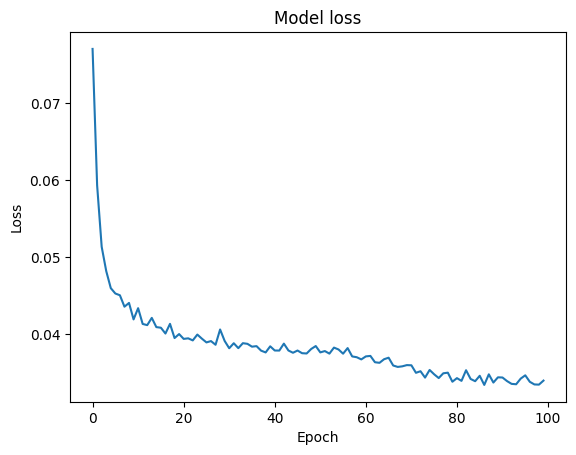

In [13]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [14]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

32/32 [==============================] - 1s 22ms/step


In [15]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [16]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 12.300397
C error per pixel [0, 255]: 13.056788


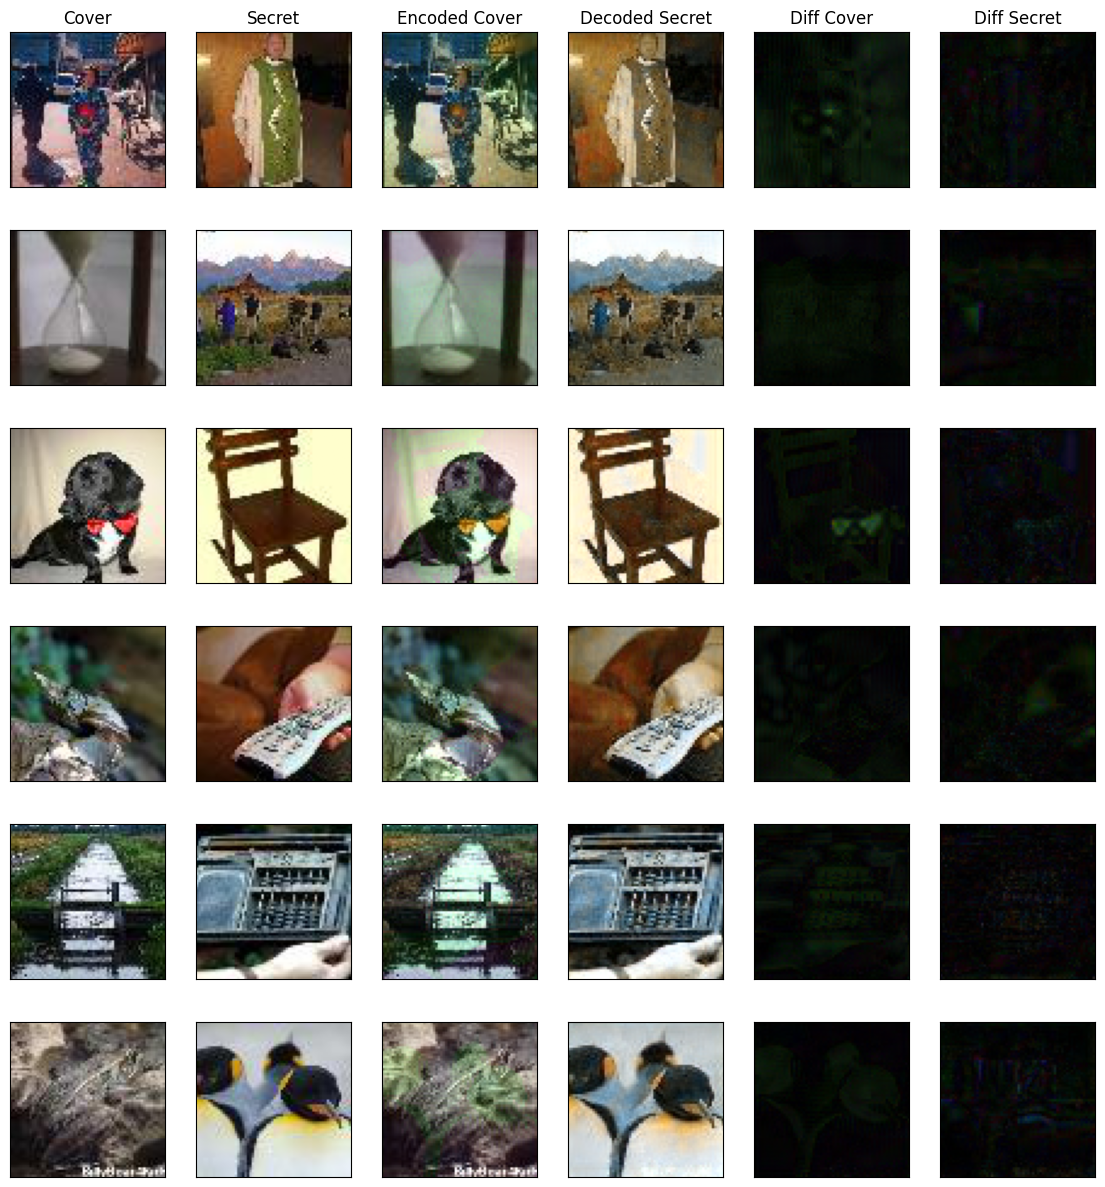

In [17]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()